In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
    
import warnings
warnings.filterwarnings('ignore')

import plotly

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import missingno as msno


In [2]:
def importFile(file_name):
    df = pd.read_csv(f'data/{file_name}.csv')
    return df

In [3]:

application_train = importFile('application_train')   
application_test = importFile('application_test')
bureau = importFile('bureau')
bureau_balance = importFile('bureau_balance')
cc_balance = importFile('credit_card_balance')
installments_payments = importFile('installments_payments')
POS_CASH_balance = importFile('POS_CASH_balance')
previous_application = importFile('previous_application')

In [4]:
def nan_df_create(data):
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [5]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels

    '''
    
    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

In [6]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

In [7]:
def load_all_tables(directory_path = '', verbose = True):
    
    '''
    Function to load all the tables required
    
    Input:
        directory_path: str, default = ''
            Path of directory in which tables are stored in
        verbose: bool, default = True
            Whether to keep verbosity or not
        
    '''
    
    if verbose:
        print("Loading all the tables...")
        start = datetime.now()
    
    #making all the variables global to be used anywhere in the notebook
    global application_train, application_test, bureau, bureau_balance, cc_balance, installments_payments, POS_CASH_balance, previous_application
    
    application_train = pd.read_csv(directory_path + 'application_train.csv')
    if verbose:
        print("Loaded 1 table.")
       
    application_test = pd.read_csv(directory_path + 'application_test.csv')
    if verbose:
        print("Loaded 2 tables.")

    bureau = pd.read_csv(directory_path + 'bureau.csv')
    if verbose:
        print("Loaded 3 tables.")

    bureau_balance = pd.read_csv(directory_path + 'bureau_balance.csv')
    if verbose:
        print("Loaded 4 tables.")

    cc_balance = pd.read_csv(directory_path + 'credit_card_balance.csv')
    if verbose:
        print("Loaded 5 tables.")

    installments_payments = pd.read_csv(directory_path + 'installments_payments.csv')
    if verbose:
        print("Loaded 6 tables.")

    POS_CASH_balance = pd.read_csv(directory_path + 'POS_CASH_balance.csv')
    if verbose:
        print("Loaded 7 tables.")

    previous_application = pd.read_csv(directory_path + 'previous_application.csv')
    if verbose:
        print("Loaded 8 tables.")
        print("Done.")
        print(f'Time Taken to load 8 tables = {datetime.now() - start}')

In [8]:
def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    '''
    Function to Phi_k matrix for categorical features
    
    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        categorical_columns: list
            List of categorical columns whose PhiK values are to be plotted
        figsize: tuple, default = (25,23)
            Size of the figure to be plotted
        mask_upper: bool, default = True
            Whether to plot only the lower triangle of heatmap or plot full.
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        linewidth: float/int, default = 0.1
            The linewidth to use for heatmap
        fontsize: int, default = 10
            The font size for the X and Y tick labels
        cmap: str, default = 'Blues'
            The colormap to be used for heatmap
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''
    
    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()
    
    print('-'*100)
    
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100) 

In [9]:
def plot_categorical_variables_bar(data, column_name, figsize = (18,6), percentage_display = True, plot_defaulter = True, rotation = 0, horizontal_adjust = 0, fontsize_percent = 'xx-small'):
    
    '''
    Function to plot Categorical Variables Bar Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
        
    '''
    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()

In [10]:
def plot_categorical_variables_pie(data, column_name, plot_defaulter = True, hole = 0):
    
    '''
    Function to plot categorical variables Pie Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        plot_defaulter: bool
            Whether to plot the Pie Plot for Defaulters or not
        hole: int, default = 0
            Radius of hole to be cut out from Pie Chart
    '''
    
    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets', f'Percentage of Defaulters for each category of {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']
        
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index
    
    fig = make_subplots(rows = 1, cols = cols, 
                       specs = specs, 
                       subplot_titles = titles)
    
    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole, 
                         textinfo = 'label+percent', textposition = 'inside'), row = 1, col = 1)
    
    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)
        
        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index, 
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value'), row = 1, col = 2)
        
    fig.update_layout(title = f'Distribution of {column_name}')
    fig.show()

In [11]:
def print_unique_categories(data, column_name, show_counts = False):
    
    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables
    
        Inputs:
        data: DataFrame
            The DataFrame from which to print statistics
        column_name: str
            Column's name whose stats are to be printed
        show_counts: bool, default = False
            Whether to show counts of each category or not

    '''
    
    print('-'*100)
    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")
    print('-'*100)
    
    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
        print('-'*100)

In [12]:
def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):
    
    '''
    Function to plot CDF of a continuour variable
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose CDF is to be plotted
        log_scale: bool, default = True
            Whether to use log-scale (for widely varying values) or not
        figsize: tuple, default = (12,8)
            The size of figure to be plotted    
    '''
    
        
    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()

In [13]:
def print_percentiles(data, column_name, percentiles = None):
    
    '''
    Function to print percentile values for given column
    
    Inputs:
        data: DataFrame
            The DataFrame from which to print percentiles
        column_name: str
            Column's name whose percentiles are to be printed
        percentiles: list, default = None
            The list of percentiles to print, if not given, default are printed
    '''
    
    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)

In [14]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

#### debut eda

In [15]:
print('-'*100)
print(f'The shape of application_train.csv is: {application_train.shape}')
print('-'*100)
print(f'Number of duplicate values in application_train: {application_train.shape[0] - application_train.duplicated().shape[0]}')
print('-'*100)
display(application_train.head())

----------------------------------------------------------------------------------------------------
The shape of application_train.csv is: (307511, 122)
----------------------------------------------------------------------------------------------------
Number of duplicate values in application_train: 0
----------------------------------------------------------------------------------------------------


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [16]:
print('-'*100)
print(f'The shape of application_test.csv is: {application_test.shape}')
print('-'*100)
print(f'Number of duplicate values in application_test: {application_test.shape[0] - application_test.duplicated().shape[0]}')
print('-'*100)
display(application_test.head())

----------------------------------------------------------------------------------------------------
The shape of application_test.csv is: (48744, 121)
----------------------------------------------------------------------------------------------------
Number of duplicate values in application_test: 0
----------------------------------------------------------------------------------------------------


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

Number of columns having NaN values: 67 columns


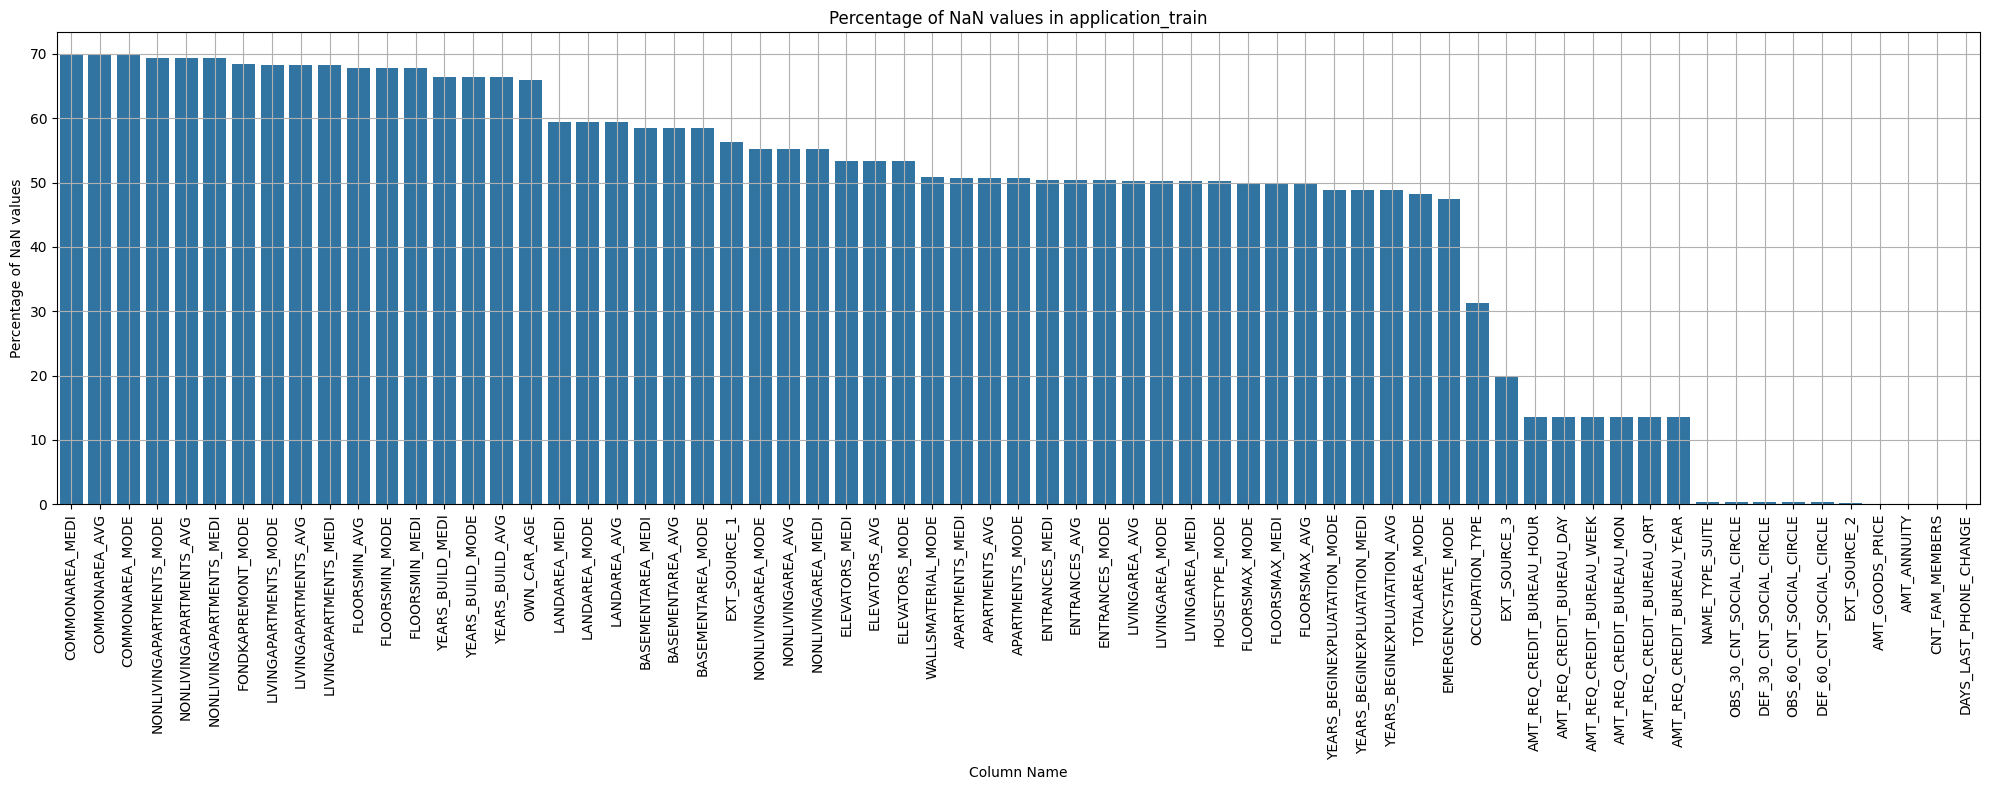

In [17]:
plot_nan_percent(nan_df_create(application_train), 'application_train', grid = True)

Number of columns having NaN values: 64 columns


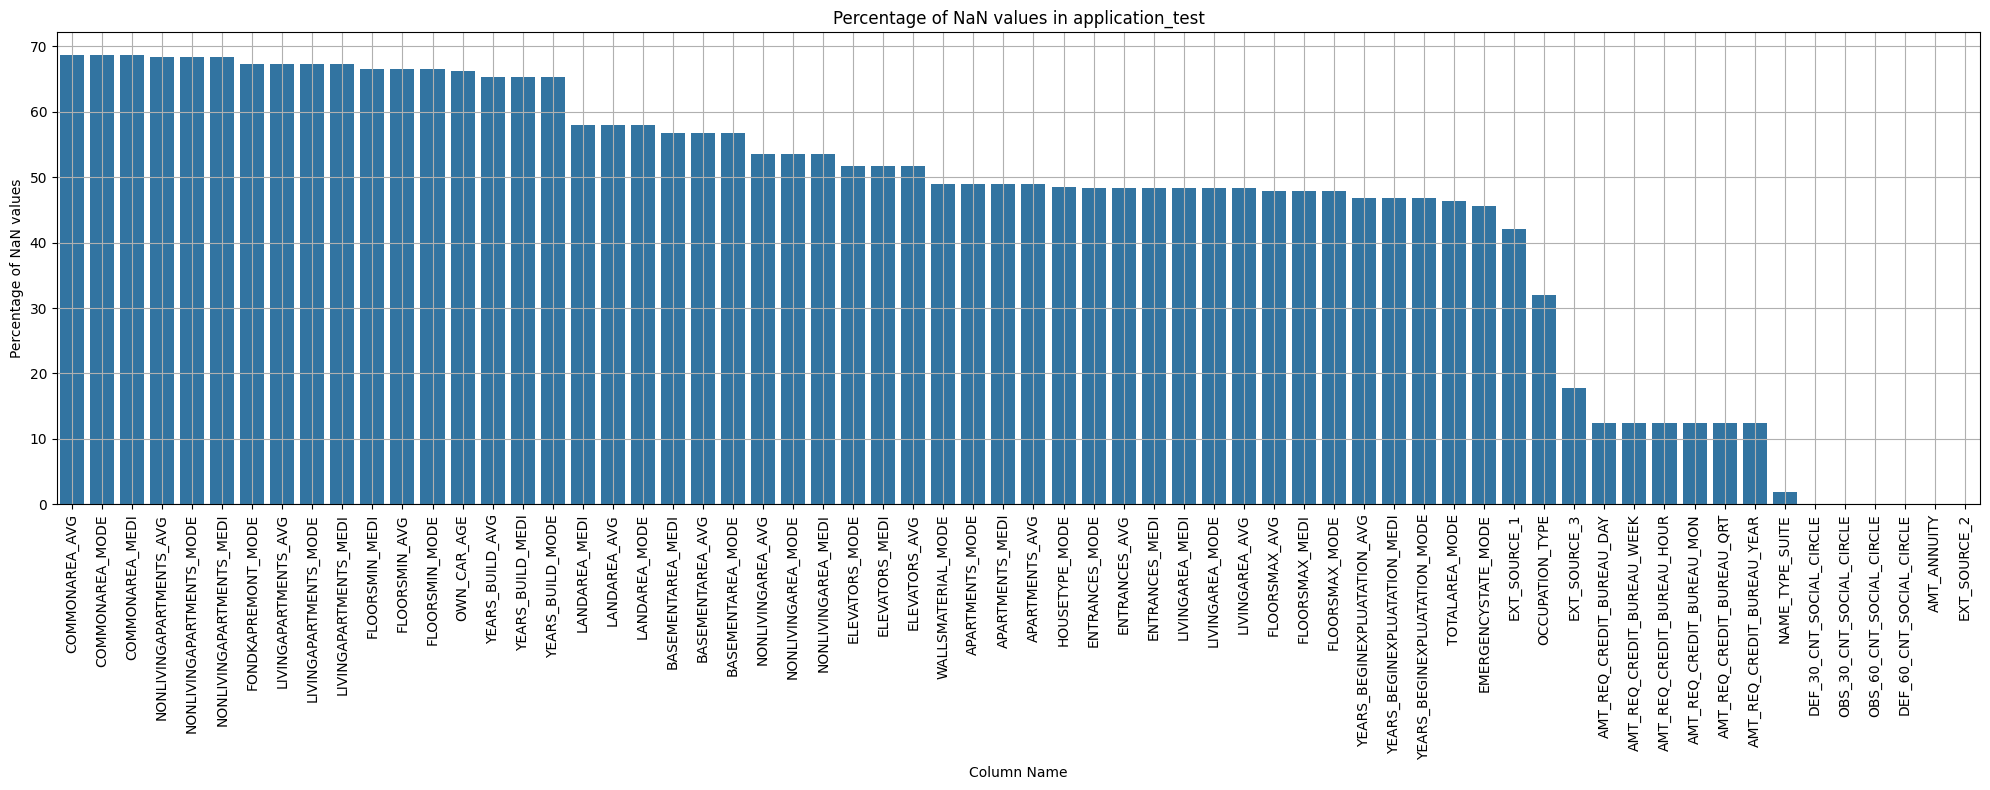

In [18]:
plot_nan_percent(nan_df_create(application_test), 'application_test', grid = True)

In [19]:
px.pie(application_train, names='TARGET')

----------------------------------------------------------------------------------------------------


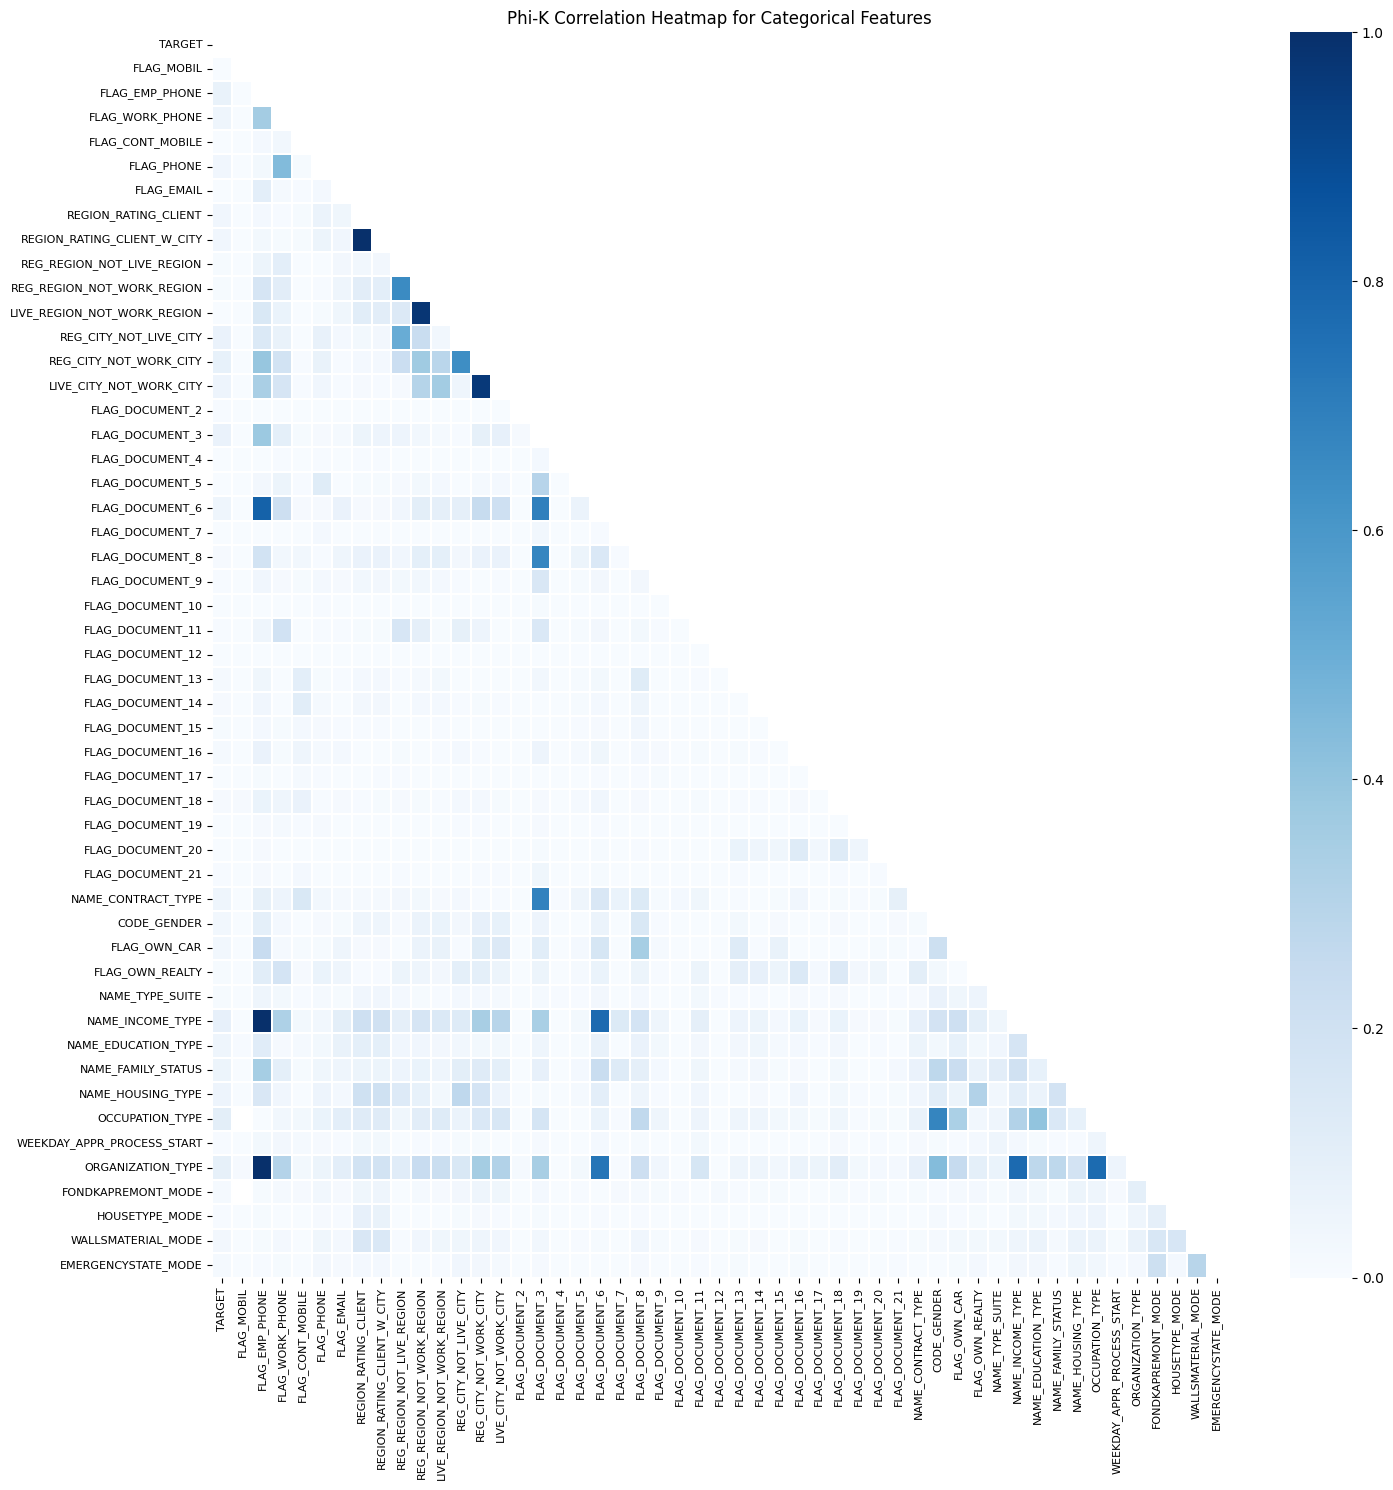

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
43          OCCUPATION_TYPE          0.102846
45        ORGANIZATION_TYPE          0.089164
39         NAME_INCOME_TYPE          0.084831
12   REG_CITY_NOT_WORK_CITY          0.079946
1            FLAG_EMP_PHONE          0.072087
11   REG_CITY_NOT_LIVE_CITY          0.069588
15          FLAG_DOCUMENT_3          0.069525
41       NAME_FAMILY_STATUS          0.056043
42        NAME_HOUSING_TYPE          0.051107
13  LIVE_CITY_NOT_WORK_CITY          0.050956

----------------------------------------------------------------------------------------------------


In [20]:
categorical_columns = ['TARGET','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                                   'FLAG_PHONE', 'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                                   'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                                'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2,22)] + application_train.dtypes[
                                    application_train.dtypes == 'object'].index.tolist()
plot_phik_matrix(application_train, categorical_columns, figsize = (15,15), fontsize = 8)

----------------------------------------------------------------------------------------------------


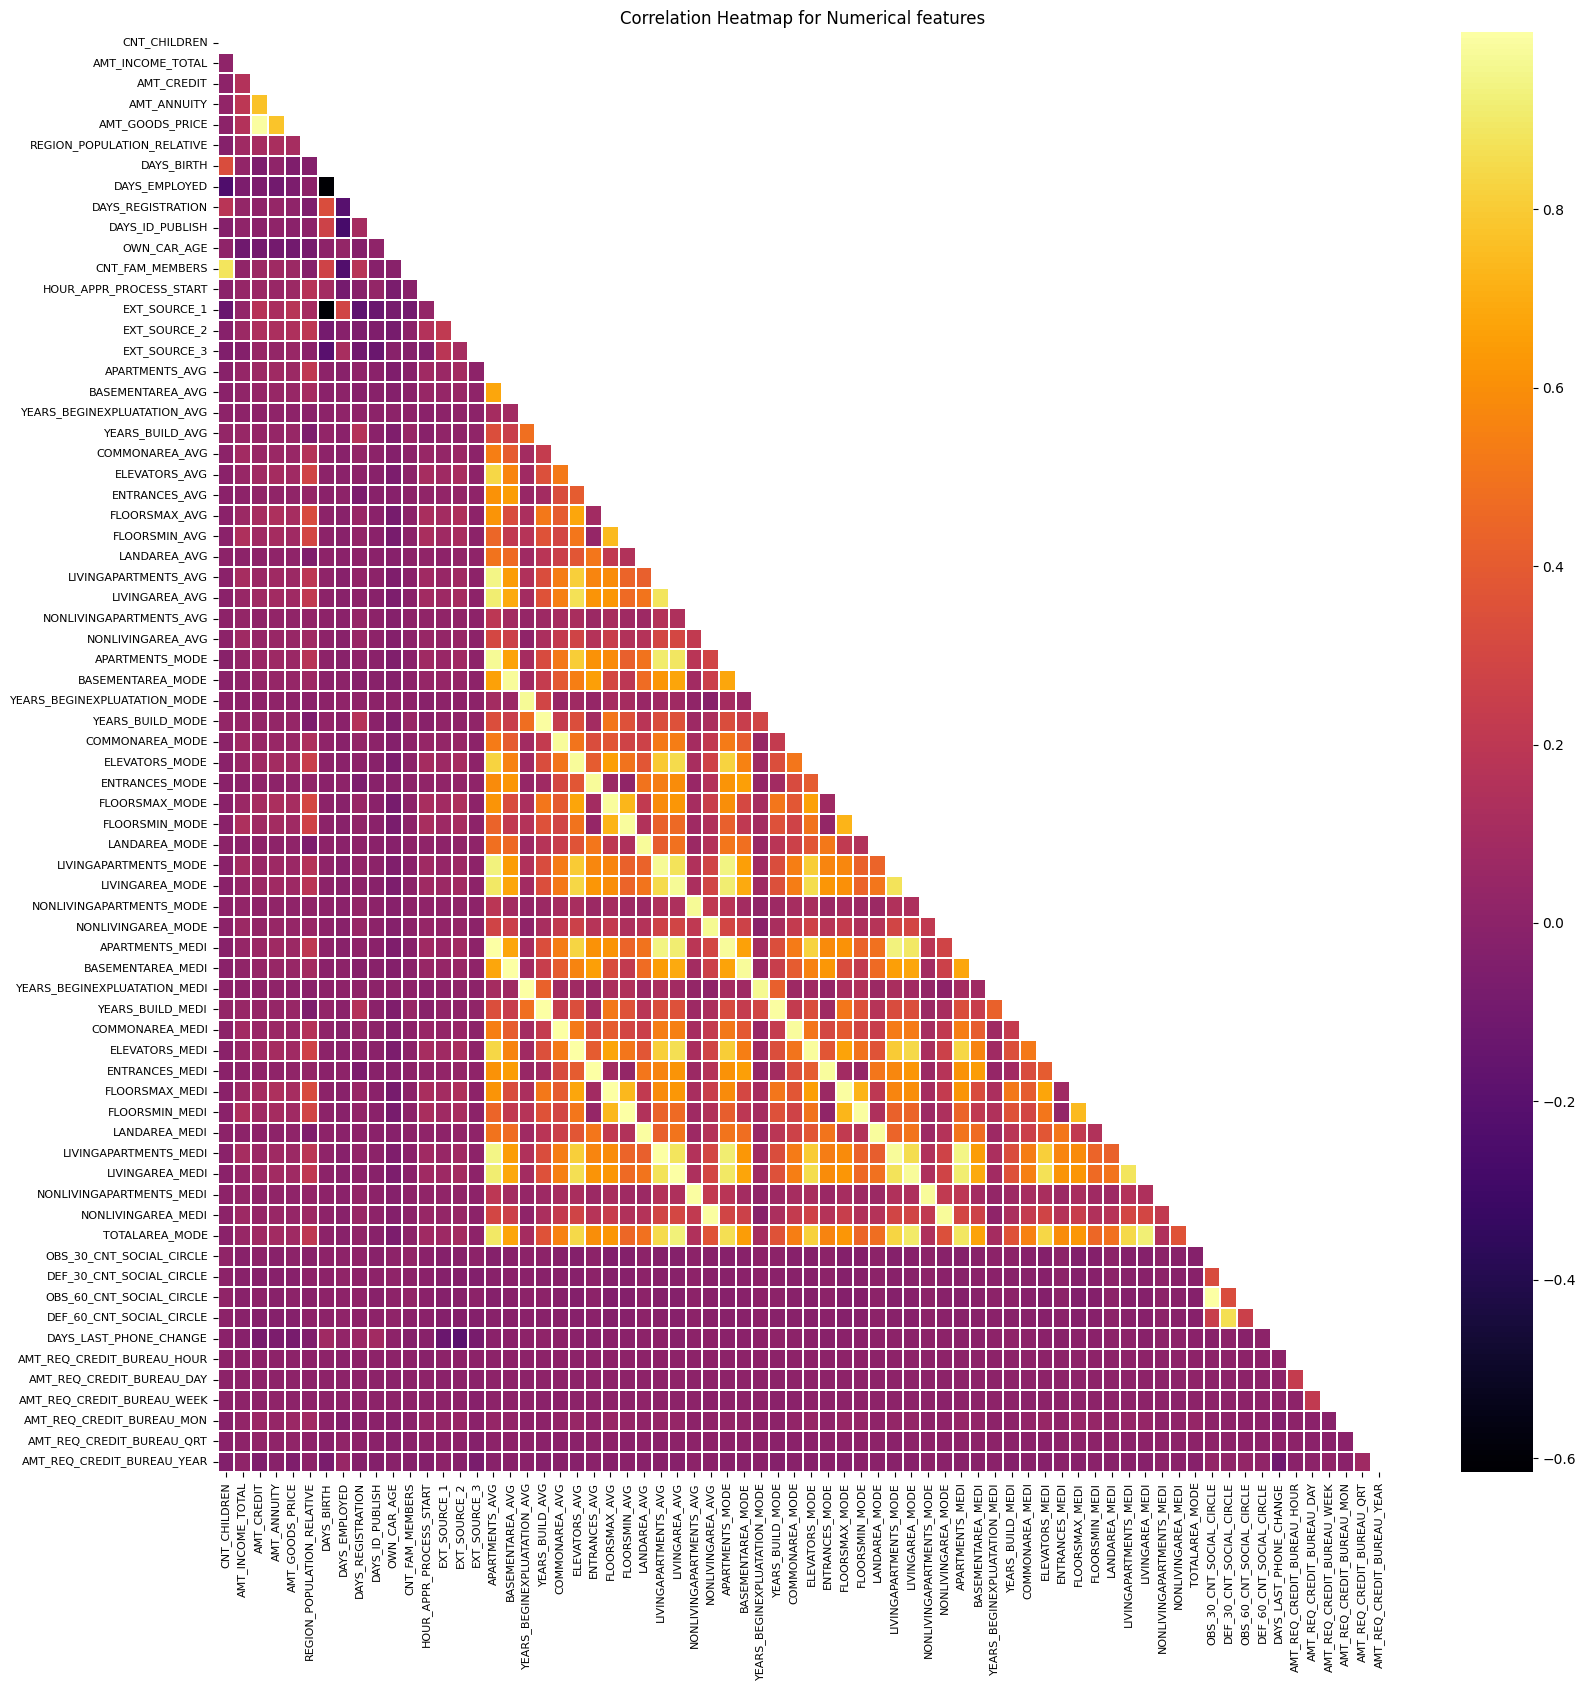

----------------------------------------------------------------------------------------------------


In [21]:
columns_to_drop = ['SK_ID_CURR'] + list(set(categorical_columns) - set(['TARGET']))
corr_mat = correlation_matrix(application_train, columns_to_drop, figsize = (17,17), fontsize = 8, cmap = 'inferno')
corr_mat.plot_correlation_matrix()

In [22]:
#Seeing the top columns with highest phik-correlation with the target variable in application_train table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']
interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_1']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_2']
interval columns 

Column Name  Phik-Correlation
15            EXT_SOURCE_3          0.247680
13            EXT_SOURCE_1          0.217846
14            EXT_SOURCE_2          0.213965
6               DAYS_BIRTH          0.102395
63  DAYS_LAST_PHONE_CHANGE          0.073215
7            DAYS_EMPLOYED          0.072094
9          DAYS_ID_PUBLISH          0.067769
4          AMT_GOODS_PRICE          0.059093
23           FLOORSMAX_AVG          0.058673
51          FLOORSMAX_MEDI          0.058445

----------------------------------------------------------------------------------------------------


In [23]:
#let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(application_train, 'NAME_CONTRACT_TYPE')

#plotting the Pie Plot for the column
plot_categorical_variables_pie(application_train, 'NAME_CONTRACT_TYPE', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Cash loans' 'Revolving loans']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


In [24]:
#let us first see the unique categories of 'CODE_GENDER'
print_unique_categories(application_train, 'CODE_GENDER', show_counts = True)

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, 'CODE_GENDER', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_GENDER' are:
['M' 'F' 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


La distribution de la fonction CODE_GENDER semble intéressante. Voici quelques éléments de discussion :

Le premier point à observer est qu'il y a 4 lignes dans le tableau application_train qui ont des genres 'XNA', ce qui n'a pas beaucoup de sens, et peut être compté comme des valeurs NaN. Puisqu'elles ne sont que 4 en nombre et qu'elles appartiennent uniquement à la catégorie Non-Defaulter. Nous pouvons donc éliminer ces lignes sans hésitation.
Le sous-graphe 1 montre que, pour l'ensemble de données donné, le nombre de candidates (65,8 %) est supérieur à celui des candidats (34,2 %).
Toutefois, contrairement au nombre de candidates, le deuxième graphique montre que les candidats masculins ont tendance à manquer à leurs obligations (10,14 %) par rapport aux candidates féminines (7 %).
On peut donc dire que les hommes ont plus tendance à manquer à leurs obligations que les femmes, d'après l'ensemble des données fournies.


In [25]:
#let us first see the unique categories of 'FLAG_EMP_PHONE'
print_unique_categories(application_train, 'FLAG_EMP_PHONE')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, column_name = 'FLAG_EMP_PHONE', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'FLAG_EMP_PHONE' are:
[1 0]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


Cette fonction comprend deux catégories, à savoir si le client a fourni ou non son numéro de téléphone professionnel au cours de la procédure d'inscription/de demande.

Le premier sous-graphe montre que la plupart des candidats n'ont pas fourni leur numéro de téléphone professionnel (82 %) et que seuls 18 % l'ont fait.
On constate également que la tendance au défaut de ceux qui fournissent leur numéro de téléphone professionnel est plus importante que celle de ceux qui ne le fournissent pas.
Cette caractéristique pourrait être attribuée au fait que les retardataires fournissent leur numéro de téléphone professionnel afin de ne pas être dérangés sur leur téléphone personnel.

_________________________________________
Distribution de la variable catégorielle REGION_RATING_CLIENT_W_CITY

Cette caractéristique est la note attribuée par le Crédit à domicile à la région de chaque client sur la base des enquêtes qu'il a pu réaliser. Cette note tient également compte de la ville dans laquelle le client habite.
La prise en compte de la ville est importante car même si certaines régions ont une bonne note dans une ville particulière, mais que cette ville n'a pas une note élevée, le demandeur se verra attribuer une note moyenne et non une note élevée.
Elle contient des valeurs comprises entre 1 et 3.

Traduit avec DeepL.com (version gratuite)

In [26]:
#let us first see the unique categories of 'REGION_RATING_CLIENT_W_CITY'
print_unique_categories(application_train, 'REGION_RATING_CLIENT_W_CITY')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, column_name = 'REGION_RATING_CLIENT_W_CITY')
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'REGION_RATING_CLIENT_W_CITY' are:
[2 1 3]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


Les graphiques ci-dessus nous permettent de tirer les conclusions suivantes :

Le premier sous-graphe montre que la plupart des clients (74,6 %) ont une note régionale de 2. Il s'agit de la valeur moyenne qui correspond à la plupart des demandeurs.
Très peu de demandeurs ont une note régionale de 1 (seulement 11,1%) et certains ont une note de 3 (14,3%).
Parmi les mauvais payeurs, on constate que la plupart d'entre eux ont une note régionale de 3 (11,4 %), ce qui est comparativement plus élevé que les deux autres notes, c'est-à-dire que les clients ayant une note de 1 ont un pourcentage de mauvais payeurs de seulement 4,84 % et ceux ayant une note de 2 ont un pourcentage de 7,92 %.
Cela montre que la note 3 pourrait être un attribut important pour prendre une décision sur les caractéristiques de défaillance.

______________________________________________________________________________________________________
Distribution de la variable catégorielle NAME_EDUCAtION_TYPE

Cette caractéristique décrit/répertorie le niveau d'études le plus élevé atteint par le client.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_EDUCATION_TYPE' are:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
----------------------------------------------------------------------------------------------------
Counts of each category are:
NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_EDUCATION_TYPE = 5


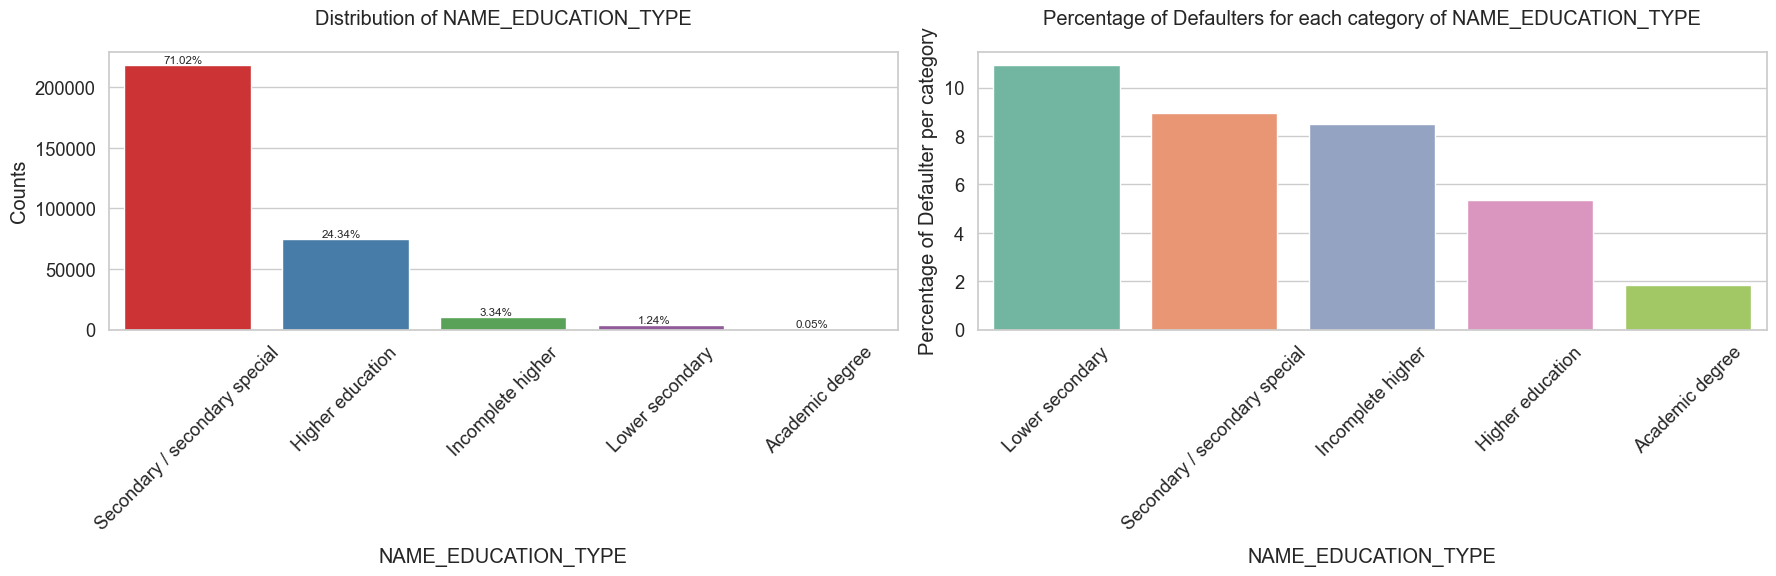

----------------------------------------------------------------------------------------------------


In [27]:
#let us first see the unique categories of 'NAME_EDUCATION_TYPE'
print_unique_categories(application_train, 'NAME_EDUCATION_TYPE', show_counts = True)

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(application_train, column_name = 'NAME_EDUCATION_TYPE', rotation = 45, horizontal_adjust = 0.25)
print('-'*100)

En examinant les graphiques ci-dessus, nous pouvons conclure ce qui suit :

Environ 71% des personnes n'ont reçu qu'une éducation secondaire, tandis que 24,34% des clients ont fait des études supérieures. Cela suggère que la plupart des clients/emprunteurs n'ont pas un niveau d'éducation élevé.
Le deuxième graphique montre que les personnes qui n'ont étudié que jusqu'au premier cycle du secondaire présentent les caractéristiques de défaillance les plus élevées, le secondaire et l'enseignement supérieur incomplet ayant des tendances de défaillance similaires.
Le groupe des personnes ayant fait des études supérieures a une tendance à la défaillance comparativement plus faible, ce qui est également logique. De même, les personnes titulaires d'un diplôme universitaire affichent le taux de défaillance le plus faible. Toutefois, le groupe des titulaires d'un diplôme universitaire est très peu nombreux, de sorte que ces données pourraient ne pas être très utiles.

____________________________________________________________________________________________________________
Distribution de la variable catégorielle OCCUPATION_TYPE

Cette caractéristique indique le type de profession exercée par le client. Il s'agit d'une caractéristique très importante qui peut décrire les caractéristiques de défaillance d'un client. Voyons les graphiques correspondants.

----------------------------------------------------------------------------------------------------
The unique categories of 'OCCUPATION_TYPE' are:
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of OCCUPATION_TYPE = 19


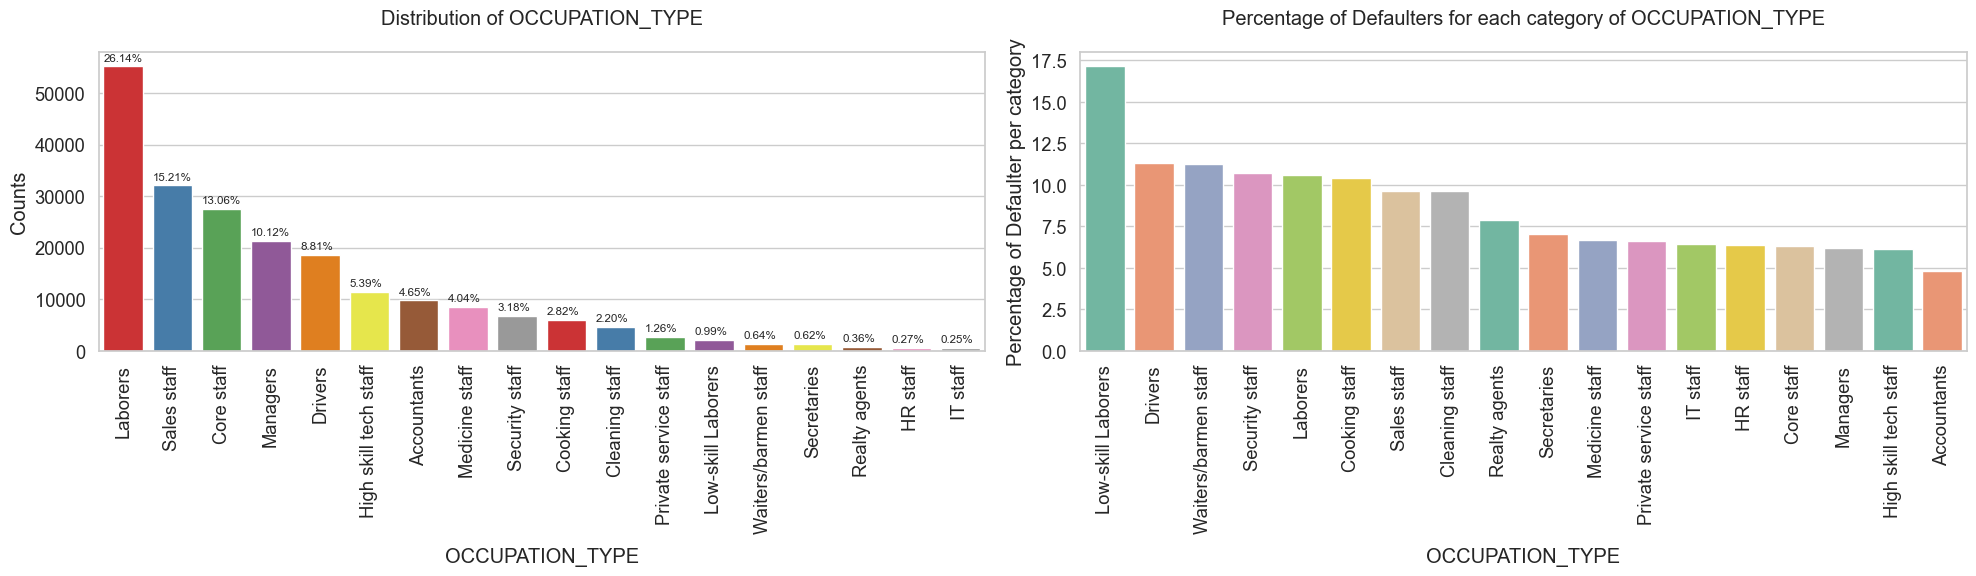

----------------------------------------------------------------------------------------------------


In [28]:
#let us first see the unique categories of 'OCCUPATION_TYPE'
print_unique_categories(application_train, 'OCCUPATION_TYPE')

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(application_train, column_name = 'OCCUPATION_TYPE', figsize = (20,6), rotation = 90)
print('-'*100)

Les graphiques relatifs au type de profession permettent de faire les observations suivantes :

Parmi les candidats, le type de profession le plus courant est celui de manœuvre, qui représente près de 26 % des candidatures. Viennent ensuite les vendeurs, puis le personnel de base et les cadres.
Le taux de défaillance des travailleurs peu qualifiés est le plus élevé de tous les types de professions (~17,5 %). Viennent ensuite les chauffeurs, les serveurs, le personnel de sécurité, les ouvriers, le personnel de cuisine, etc. Tous ces emplois sont des emplois de bas niveau. Tous ces emplois sont des emplois subalternes, ce qui montre que les personnes occupant des emplois subalternes ont tendance à avoir un taux de défaillance plus élevé.
Le taux de défaillance le plus faible concerne les comptables, le personnel de base, les managers, le personnel technique hautement qualifié, le personnel des ressources humaines, etc. qui occupent des emplois de niveau moyen à élevé.
On peut donc en conclure que les travailleurs occupant des emplois de bas niveau ont tendance à être plus défaillants que les travailleurs occupant des emplois de niveau moyen à élevé.

______________________________________________________________________________________________________________________
Distribution de la variable catégorielle ORGANIZATION_TYPE

Tout comme le type de profession, le type d'organisation auquel appartient le client peut également être une caractéristique importante pour prédire le risque de défaut de ce client. Visualisons cette caractéristique plus en détail.

Total Number of categories of ORGANIZATION_TYPE = 58


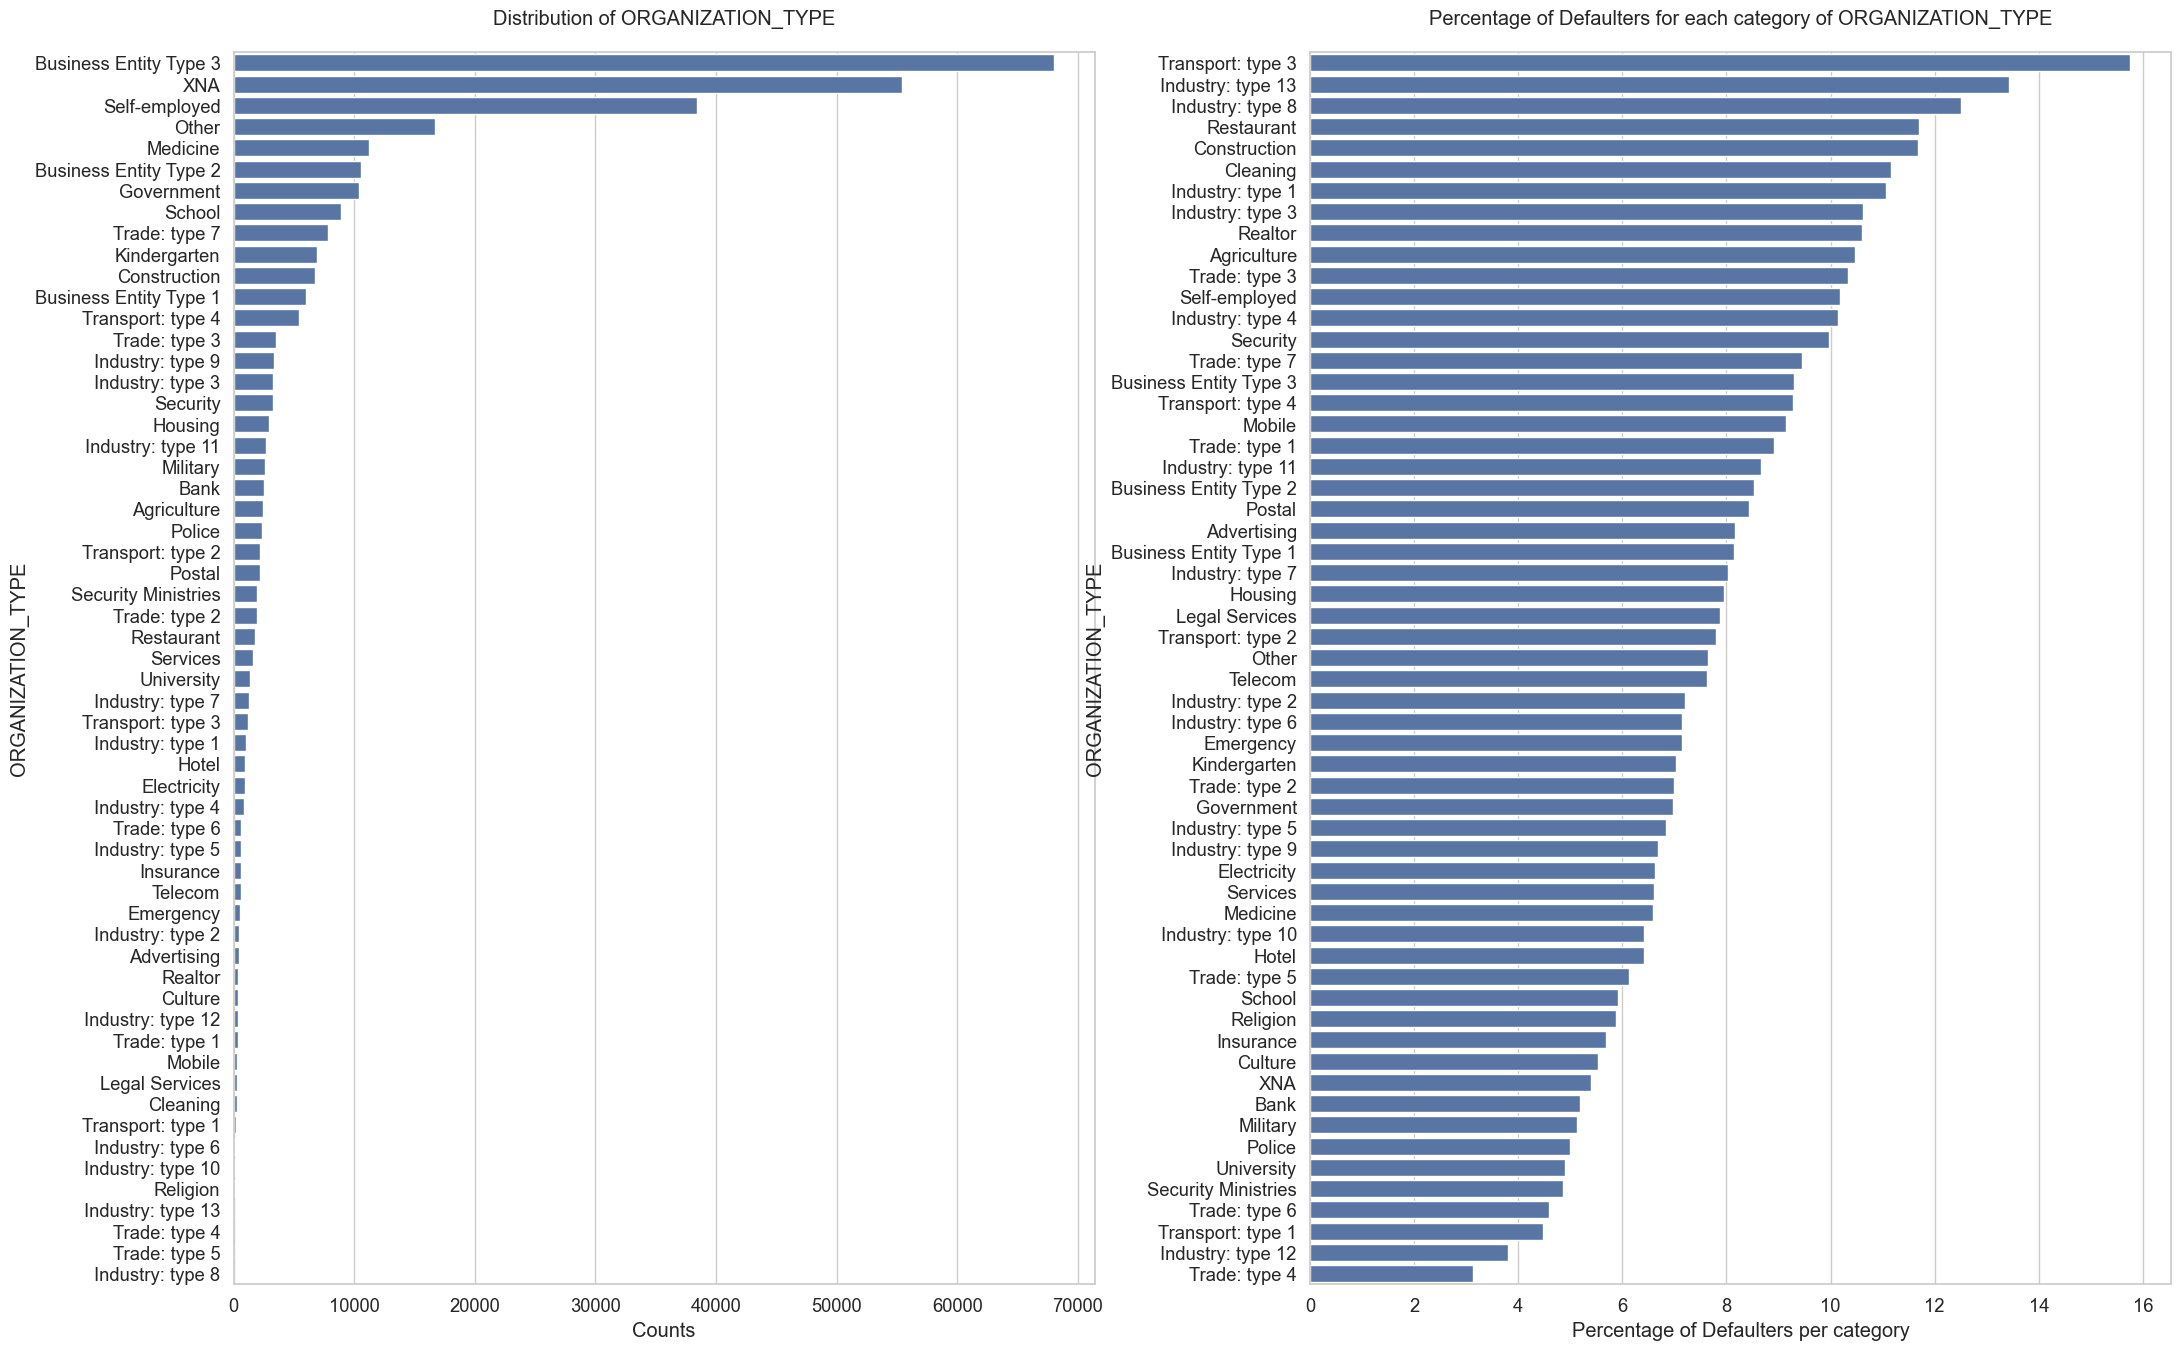

In [29]:
print(f"Total Number of categories of ORGANIZATION_TYPE = {len(application_train.ORGANIZATION_TYPE.unique())}")

plt.figure(figsize = (25,16))
sns.set(style = 'whitegrid', font_scale = 1.2)
plt.subplots_adjust(wspace=0.25)

plt.subplot(1,2,1)
count_organization = application_train.ORGANIZATION_TYPE.value_counts().sort_values(ascending = False)
sns.barplot(x = count_organization, y = count_organization.index)
plt.title('Distribution of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Counts')
plt.ylabel('ORGANIZATION_TYPE')

plt.subplot(1,2,2)
percentage_default_per_organization = application_train[application_train.TARGET == 1].ORGANIZATION_TYPE.value_counts() * 100 / count_organization
percentage_default_per_organization = percentage_default_per_organization.dropna().sort_values(ascending = False)
sns.barplot(x = percentage_default_per_organization, y = percentage_default_per_organization.index)
plt.title('Percentage of Defaulters for each category of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Percentage of Defaulters per category')
plt.ylabel('ORGANIZATION_TYPE')

plt.show()

Le client appartient à de nombreux types d'organisations, 58 pour être précis. Les graphiques ci-dessus permettent de faire les observations suivantes :

Le premier graphique montre que la plupart des demandeurs travaillent dans des organisations de type "Entité commerciale de type 3", "XNA" ou "Travailleur indépendant". Le type d'organisation "XNA" pourrait probablement désigner un type d'organisation non classifié.
Le deuxième graphique montre que les candidats appartenant à la catégorie "Transport : type 3" ont la plus forte tendance à la défaillance par rapport aux autres. Ils sont suivis par les organisations de type : "Industrie : type 13", "Industrie : type 8", "Restaurant", "Construction", etc.
Les organisations qui affichent les taux de défaillance les plus bas sont : "Commerce : type 4", "Industrie : type 12", etc.
Ces numéros de type pourraient également en dire plus sur l'organisation, mais nous ne disposons d'aucune information à ce sujet et nous nous en tiendrons donc uniquement à la dénomination qui nous a été fournie.

______________________________________________________________________________________________________________________
Distribution de la variable catégorielle REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY

REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY :
Ces colonnes indiquent si l'adresse permanente du client correspond ou non à son adresse de contact ou à son adresse professionnelle au niveau régional.

LIVE_CITY_NOT_WORK_CITY Cette colonne indique si l'adresse permanente du client correspond ou non à son adresse de contact au niveau de la ville.

Ici, 1 indique des adresses différentes et 0 indique les mêmes adresses.

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_LIVE_CITY = 2


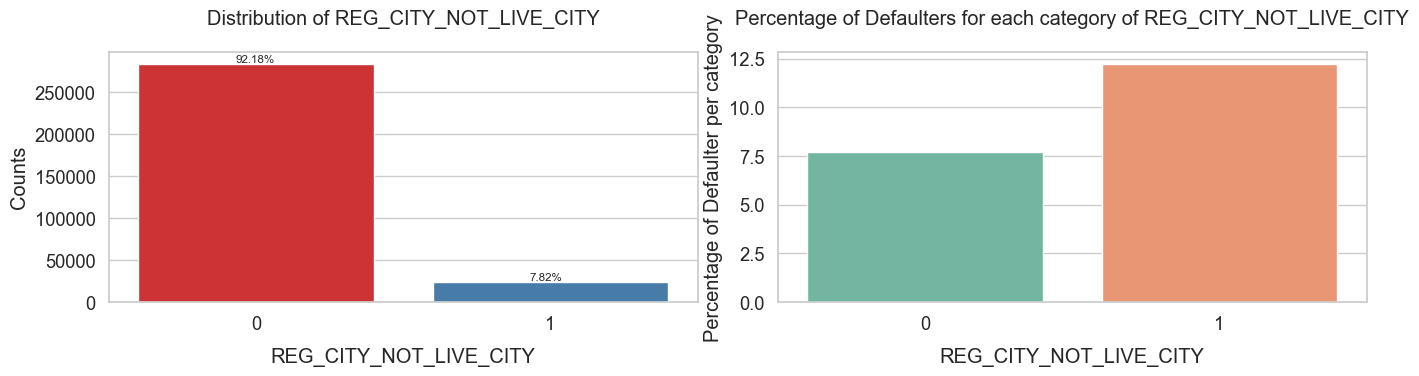

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_WORK_CITY = 2


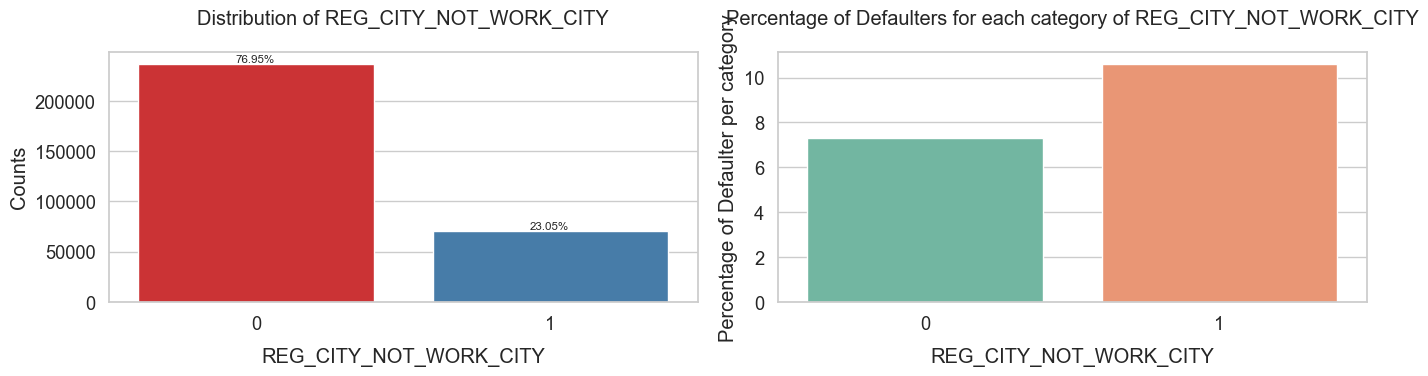

----------------------------------------------------------------------------------------------------
Total Number of unique categories of LIVE_CITY_NOT_WORK_CITY = 2


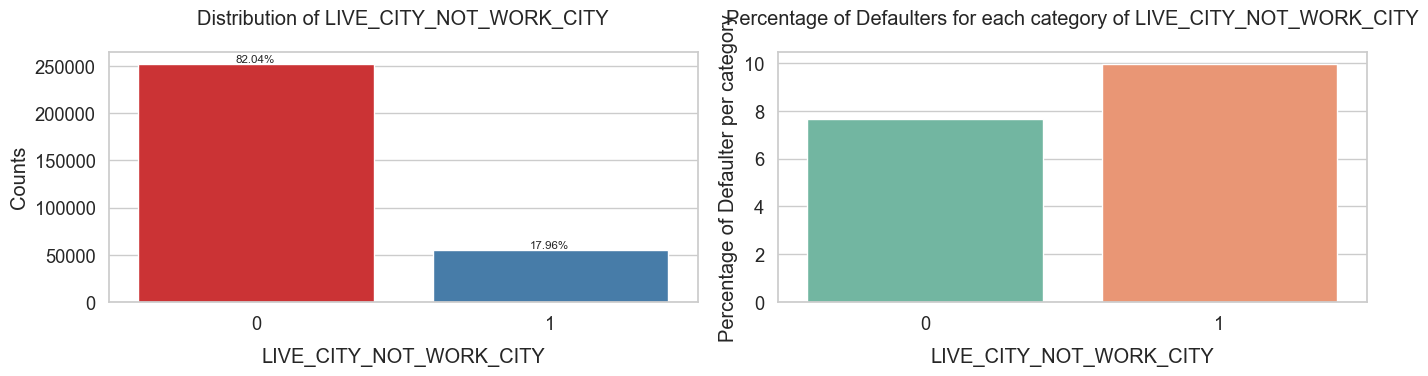

----------------------------------------------------------------------------------------------------


In [30]:
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'REG_CITY_NOT_LIVE_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'REG_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'LIVE_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)

Les trois graphiques ci-dessus permettent de tirer les conclusions suivantes :

Sur l'ensemble des candidats, il n'y a qu'une minorité de candidats dont les adresses ne correspondent pas.
Tout d'abord, seuls 7,52 % des candidats ont une adresse permanente différente de leur adresse de contact au niveau régional.
Deuxièmement, environ 23,05 % des personnes ont une adresse permanente différente de leur adresse professionnelle au niveau régional. Ce chiffre plus élevé s'explique par le fait qu'il est possible que ces personnes travaillent dans une région différente de celle de leur adresse permanente.
Enfin, environ 17,96 % des personnes ont une adresse permanente différente de leur adresse de contact au niveau de la ville.
Si nous examinons les caractéristiques de défaillance, nous constatons que la tendance à la défaillance est maximale chez les personnes dont l'adresse permanente et l'adresse de contact sont différentes au niveau de la région, suivie de l'adresse permanente et de l'adresse de travail différentes et enfin de l'adresse permanente et de l'adresse de contact différentes au niveau de la ville.
Dans tous les cas, on constate que la tendance à la défaillance des personnes ayant des adresses différentes est plus élevée que celle des personnes ayant la même adresse. Cela signifie que, quelque part, cette différence d'adresse peut suggérer un risque de défaillance.

______________________________________________________________________________________________________________________
Distribution des variables catégorielles FLAG_DOCUMENT_3

Cette colonne contient l'indicateur d'un document qui devait être soumis par le demandeur. Sa valeur est de 0 si le client a fourni le document et de 1 dans le cas contraire.

Total Number of unique categories of FLAG_DOCUMENT_3 = 2


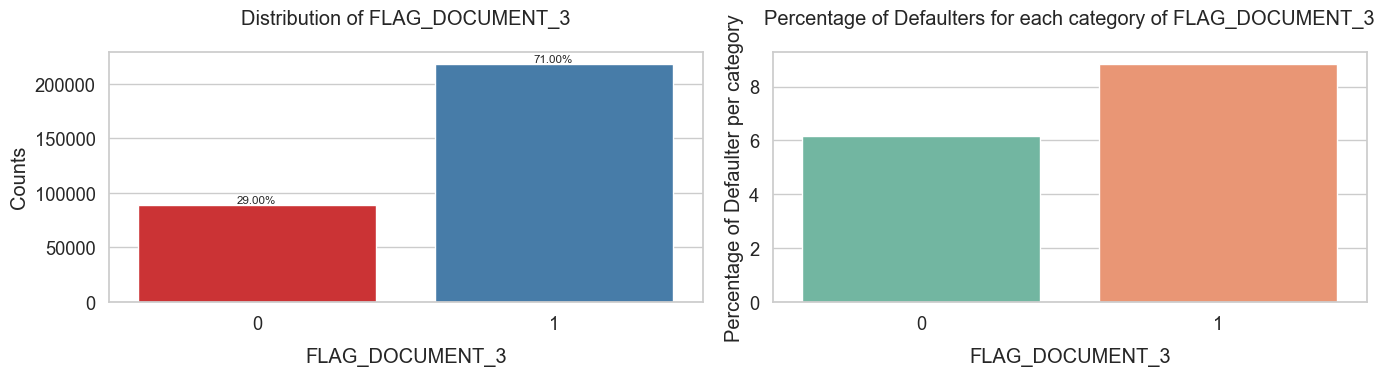

In [31]:
plot_categorical_variables_bar(application_train, column_name = 'FLAG_DOCUMENT_3', figsize = (14, 4), horizontal_adjust = 0.33)

Le graphique ci-dessus montre que :

Le premier sous-graphe montre que la plupart des clients n'ont pas fourni ce document (~71%) et que seuls 29% l'ont fait.
Le deuxième sous-graphe montre que ceux qui ont fourni ce document ont un taux de défaillance plus élevé que ceux qui ne l'ont pas fourni. Cela signifie que les candidats qui ont fourni le Document_3 ont tendance à être plus défaillants que ceux qui ne l'ont pas fourni.
Il pourrait s'agir d'un certificat BPL ou autre, mais cette information ne nous a pas été fournie et nous ne pouvons donc pas nous prononcer sur le type de document en question.

______________________________________________________________________________________________________________________
Distribution de la variable continue Âge du demandeur

Pour l'ensemble de données donné, l'âge est indiqué en jours, ce qui peut être plus difficile à interpréter. Nous allons donc créer une variable latente pour stocker les âges en années, ce qui sera plus facile à analyser et à interpréter.

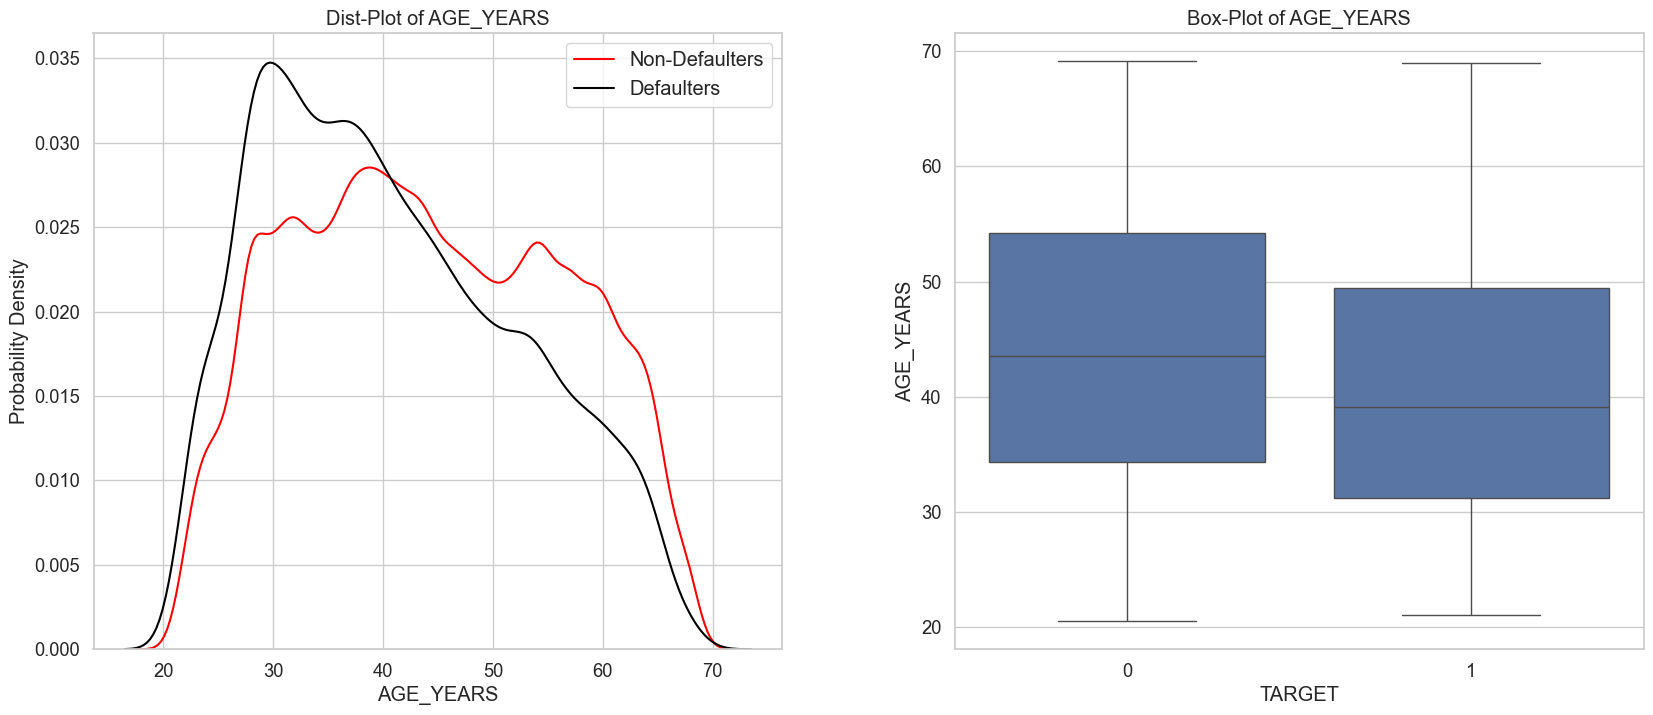

In [32]:
application_train['AGE_YEARS'] = application_train['DAYS_BIRTH'] * -1 / 365
plot_continuous_variables(application_train, 'AGE_YEARS', plots = ['distplot','box'])
_ = application_train.pop('AGE_YEARS')

Les deux graphiques ci-dessus nous permettent de tirer quelques conclusions importantes.

Le diagramme de distribution nous permet d'observer le pic d'âge des personnes en défaut de paiement, qui est proche de 30 ans. En outre, à ce stade, les personnes qui ne sont pas en défaut de paiement ont une densité de probabilité assez faible. Une autre chose à noter est que le PDF de l'âge des mauvais payeurs commence un peu à gauche de celui des mauvais payeurs, et est également un peu partout dans l'intervalle. Cela signifie que les mauvais payeurs sont généralement plus jeunes que les non mauvais payeurs.
La fonction de distribution cumulative montre également que la probabilité d'un défaut de paiement est plus élevée que celle d'un défaut de paiement.
Le diagramme en boîte permet également de mieux visualiser la même chose. L'âge des mauvais payeurs est généralement inférieur à celui des non mauvais payeurs. Tous les quantiles de l'âge des mauvais payeurs sont inférieurs à ceux des non mauvais payeurs. La valeur du 75e percentile des non-défaillants est d'environ 54 ans, tandis que celle des défaillants est proche de 49 ans.
Ces observations impliquent que les mauvais payeurs sont généralement plus jeunes que les non mauvais payeurs.

______________________________________________________________________________________________________________________
Distribution des variables continues avec les caractéristiques DAYS

DAYS_EMPLOYED

Cette caractéristique indique le nombre de jours pendant lesquels le demandeur a été employé à partir du jour de la demande. Pour faciliter l'interprétation, nous convertirons les jours en années.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_EMPLOYED is -17912.0
The 25th percentile value of DAYS_EMPLOYED is -2760.0
The 50th percentile value of DAYS_EMPLOYED is -1213.0
The 75th percentile value of DAYS_EMPLOYED is -289.0
The 90th percentile value of DAYS_EMPLOYED is 365243.0
The 92th percentile value of DAYS_EMPLOYED is 365243.0
The 94th percentile value of DAYS_EMPLOYED is 365243.0
The 96th percentile value of DAYS_EMPLOYED is 365243.0
The 98th percentile value of DAYS_EMPLOYED is 365243.0
The 100th percentile value of DAYS_EMPLOYED is 365243.0
----------------------------------------------------------------------------------------------------


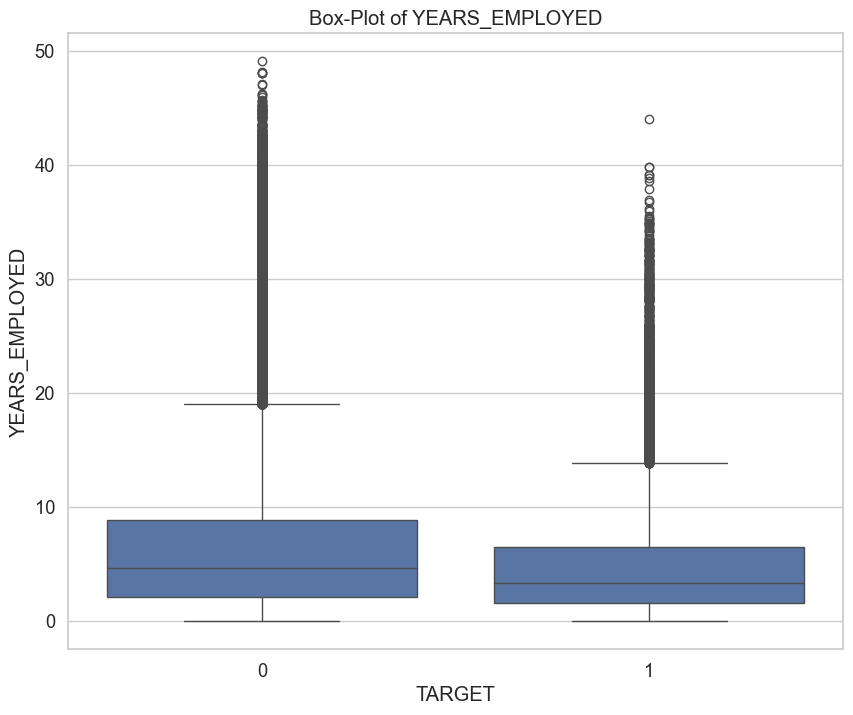

In [33]:
application_train['YEARS_EMPLOYED'] = application_train.DAYS_EMPLOYED * -1 / 365
print_percentiles(application_train, 'DAYS_EMPLOYED')
plot_continuous_variables(application_train, 'YEARS_EMPLOYED', plots = ['box'], scale_limits = [0,70], figsize = (10,8))
_ = application_train.pop('YEARS_EMPLOYED')

Nous constatons que la colonne DAYS_EMPLOYED contient des points de données erronés avec des valeurs 365243. Il s'agit apparemment de valeurs erronées/non sensibles.
Le diagramme en boîte montre que les mauvais payeurs semblent avoir un nombre d'années d'emploi inférieur à celui des non mauvais payeurs. Tous les 25e, 50e et 75e quantiles des mauvais payeurs sont inférieurs à ceux des non mauvais payeurs.

______________________________________________________________________________________________________________________
DAYS_ID_PUBLISH

Cette colonne indique le nombre de jours écoulés depuis le jour de l'enregistrement, au cours desquels le client a modifié la pièce d'identité avec laquelle il a demandé un prêt.

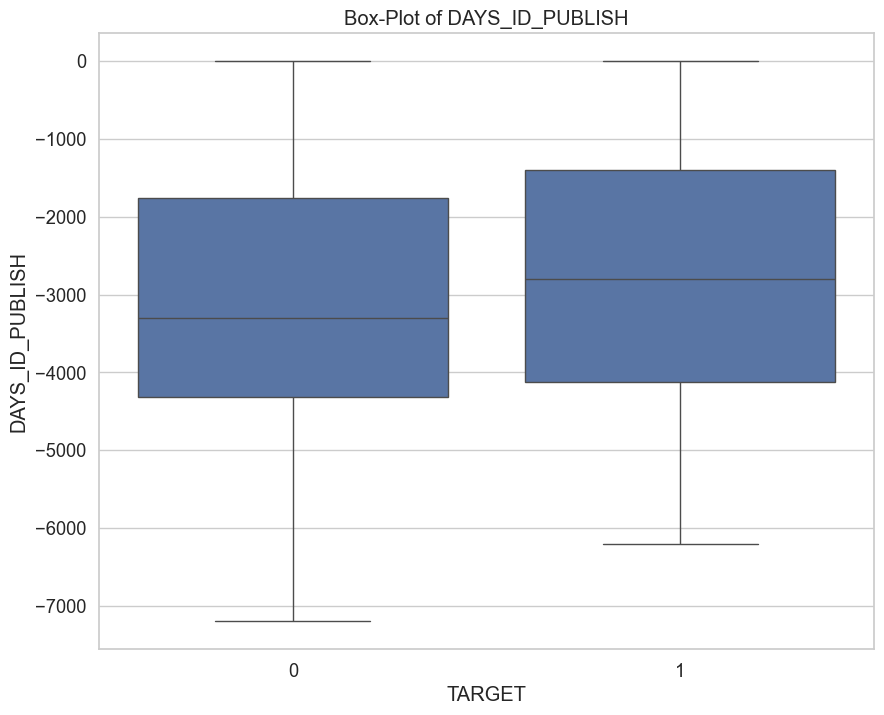

In [34]:
plot_continuous_variables(application_train, 'DAYS_ID_PUBLISH', plots = ['box'], figsize = (10,8))

Observations et conclusions :
Le diagramme en boîte ci-dessus montre une tendance similaire à celle observée pour le paramètre DAYS_REGISTRATION, dans lequel les mauvais payeurs ont généralement moins de jours depuis qu'ils ont changé de pièce d'identité. Les non-défaillants ont un nombre de jours plus élevé pour tous les quantiles depuis qu'ils ont changé de document d'identité.

____________________________________________________________________________________________________________________
Distribution des EXT_SOURCES

Les colonnes EXT_SOURCES sont au nombre de trois et contiennent des valeurs comprises entre 0 et 1. Il s'agit de notes normalisées provenant de différentes sources.

----------------------------------------------------------------------------------------------------


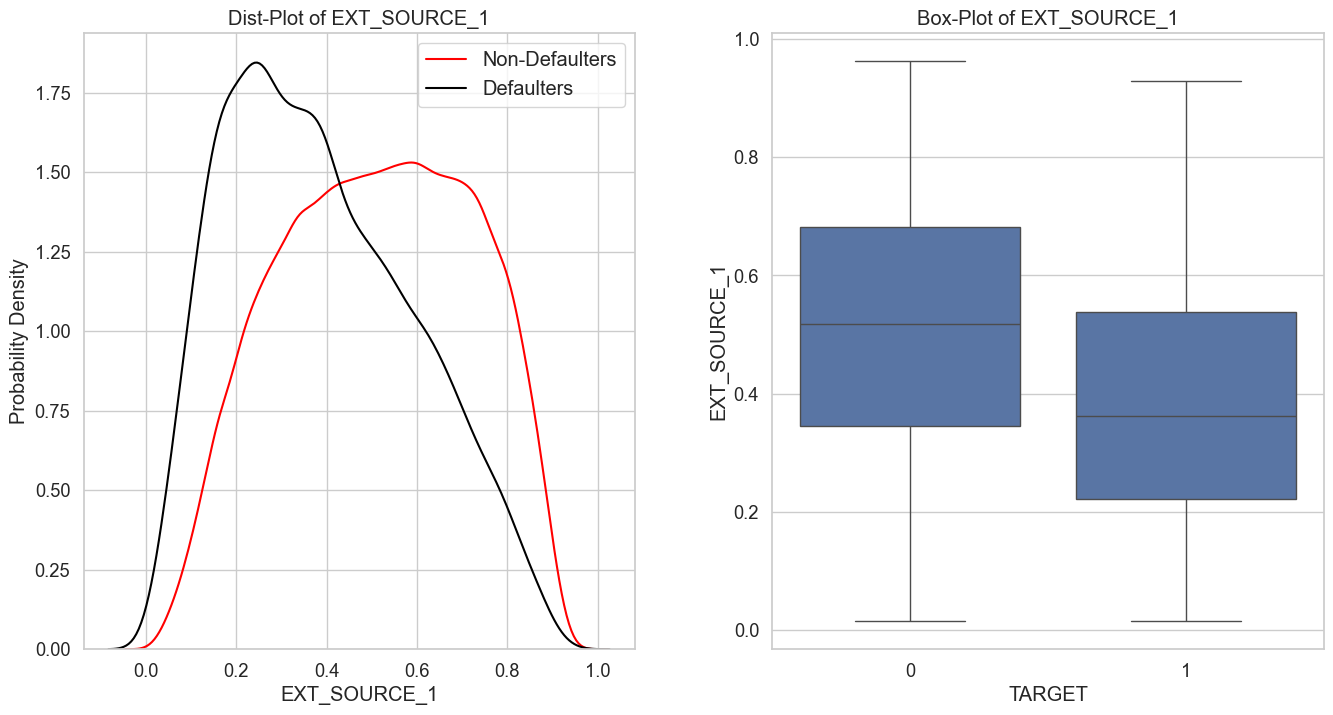

----------------------------------------------------------------------------------------------------


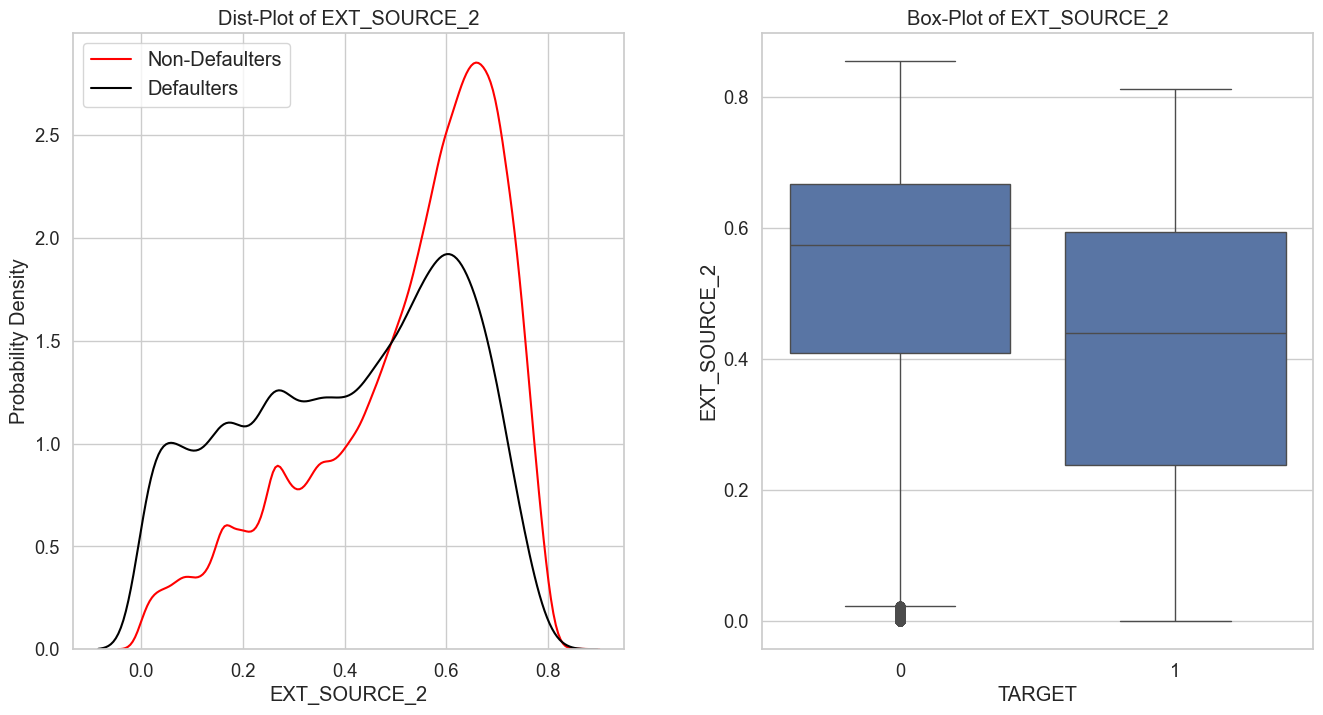

----------------------------------------------------------------------------------------------------


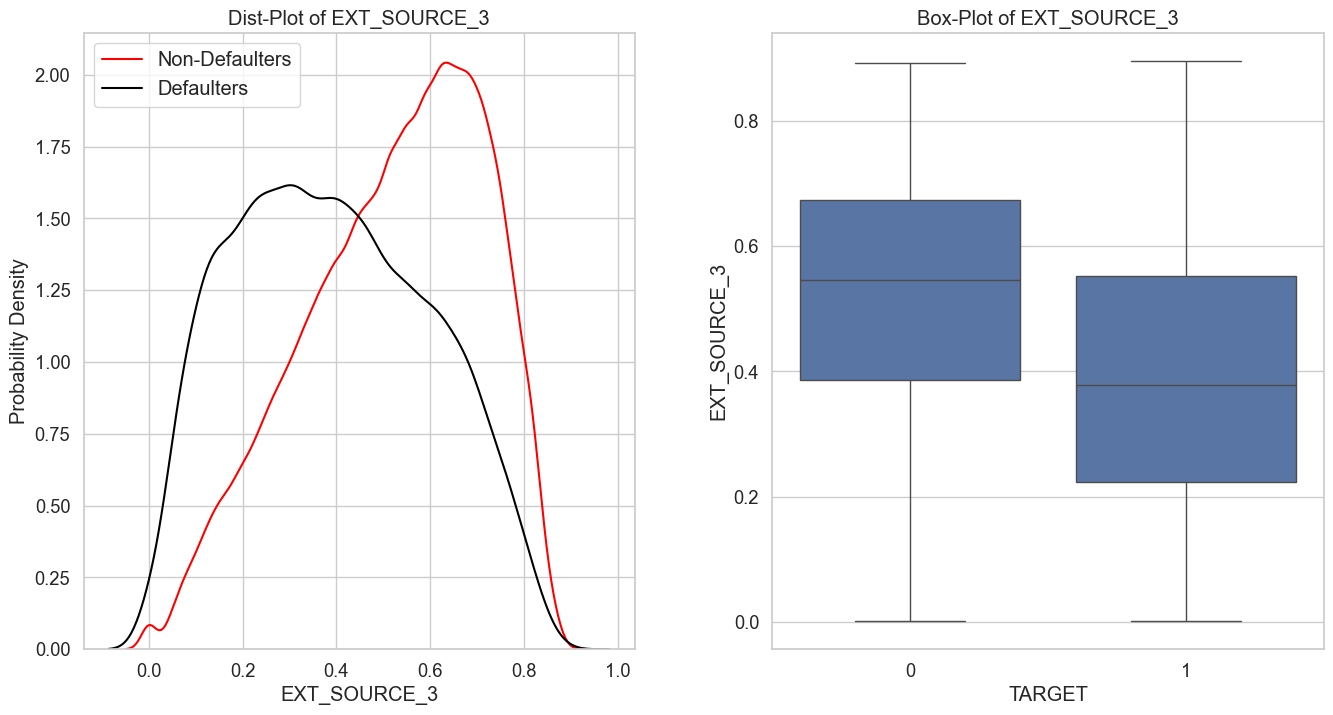

----------------------------------------------------------------------------------------------------


In [35]:
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_1', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_2', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_3', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)

Les trois graphiques ci-dessus nous permettent de tirer les conclusions suivantes :

Si nous examinons les diagrammes en boîte, nous pouvons clairement observer une tendance similaire pour les trois colonnes EXT_SOURCE, à savoir que les défaillants ont tendance à avoir des valeurs considérablement plus faibles.
Cette tendance se retrouve également dans les PDF. Les non-défaillants présentent un pic plus élevé pour les valeurs EXT_SOURCE élevées, et les densités de probabilité sont très faibles pour les valeurs faibles. Cela signifie que les non-défaillants ont généralement des valeurs élevées pour ces scores.
Il est intéressant de noter que la valeur médiane des mauvais payeurs est presque égale ou inférieure aux valeurs du 25e percentile des mauvais payeurs.
Les colonnes EXT_SOURCE_1 et EXT_SOURCE_3 tendent à montrer une meilleure discrimination/séparabilité par rapport à EXT_SOURCE_2.
Ces trois caractéristiques semblent être celles qui séparent le mieux les personnes en défaut de paiement et les personnes non en défaut de paiement de manière linéaire parmi toutes les caractéristiques utilisées jusqu'à présent.

______________________________________________________________________________________________________________________
Distribution de FLOORSMAX_AVG et FLOORSMIN_MODE

Ces colonnes décrivent les scores normalisés de la moyenne du nombre maximum d'étages et du mode du nombre minimum d'étages dans le bâtiment du demandeur.

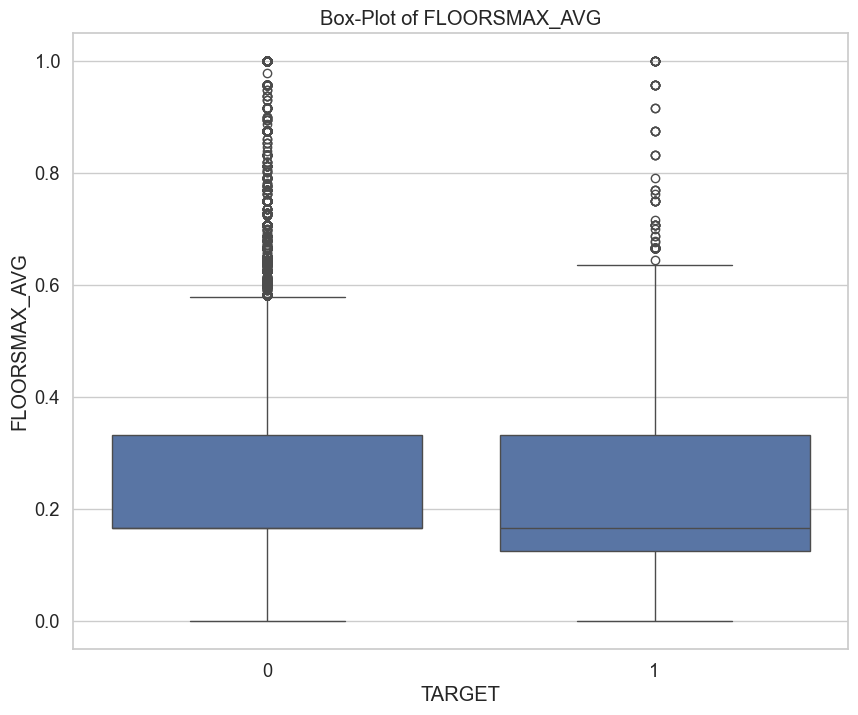

In [36]:
plot_continuous_variables(application_train, 'FLOORSMAX_AVG', plots = ['box'], figsize = (10,8))

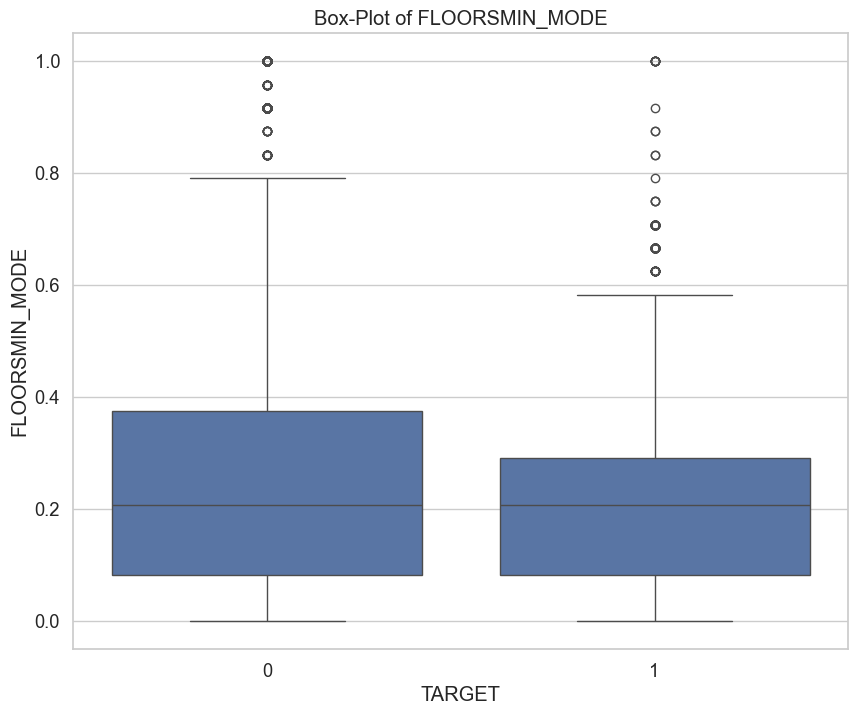

In [37]:

plot_continuous_variables(application_train, 'FLOORSMIN_MODE', plots = ['box'], figsize = (10,8))

Le graphique ci-dessus nous permet de tirer les conclusions suivantes :

La valeur médiane de la caractéristique FLOORSMAX_AVG est plus faible chez les mauvais payeurs que chez les non mauvais payeurs. Les valeurs du 75e percentile des personnes défaillantes et non défaillantes sont plus ou moins identiques, mais la valeur du 25e percentile des personnes non défaillantes est presque supérieure à la médiane des personnes défaillantes, ce qui pourrait constituer une caractéristique importante.
Les non-défaillants ont également tendance à afficher une valeur plus élevée de FLLORSMIN_MODE que les défaillants. La valeur du 75e percentile des non-défaillants est significativement plus élevée que la valeur du 75e percentile des défaillants.

## bureau

In [38]:
print(f'The shape of bureau.csv is: {bureau.shape}')
print('-'*100)
print(f'Number of unique SK_ID_BUREAU in bureau.csv are: {len(bureau.SK_ID_BUREAU.unique())}')
print(f'Number of unique SK_ID_CURR in bureau.csv are: {len(bureau.SK_ID_CURR.unique())}')
print(f'Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in bureau: {bureau.shape[0] - bureau.duplicated().shape[0]}')
print('-'*100)
display(bureau.head(5))

The shape of bureau.csv is: (1716428, 17)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_BUREAU in bureau.csv are: 1716428
Number of unique SK_ID_CURR in bureau.csv are: 305811
Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: 263491
Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: 42320
----------------------------------------------------------------------------------------------------
Number of duplicate values in bureau: 0
----------------------------------------------------------------------------------------------------


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

Le fichier bureau.csv contient près de 1,7 million de points de données, avec 17 caractéristiques. Parmi ces 17 caractéristiques, deux sont SK_ID_CURR et SK_ID_BUREAU.
SK_ID_BUREAU est l'identifiant du prêt précédent du client auprès d'autres institutions financières. Il peut y avoir plusieurs prêts antérieurs correspondant à un seul SK_ID_CURR, ce qui dépend des habitudes d'emprunt du client.
SK_ID_CURR est l'identifiant du prêt actuel du client auprès de Home Credit.
Les autres caractéristiques contiennent d'autres statistiques telles que DAYS_CREDIT, AMT_CREDIT_SUM, CREDIT_TYPE, etc.
Il y a 305 000 SK_ID_CURR uniques dans le bureau, dont 263 000 SK_ID_CURR uniques :
Il y a 263k SK_ID_CURR dans le bureau qui sont présents dans application_train sur un total de 307k SK_ID_CURR uniques dans application_train. Cela signifie que certains des demandeurs de prêt actuels auprès du Home Credit Group n'ont pas d'antécédents de crédit auprès du service des bureaux de crédit.
De même, 42,3k SK_ID_CURR du bureau sont présents dans application_test, sur un total de 48k SK_ID_CURR uniques de application_test.

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 7 columns


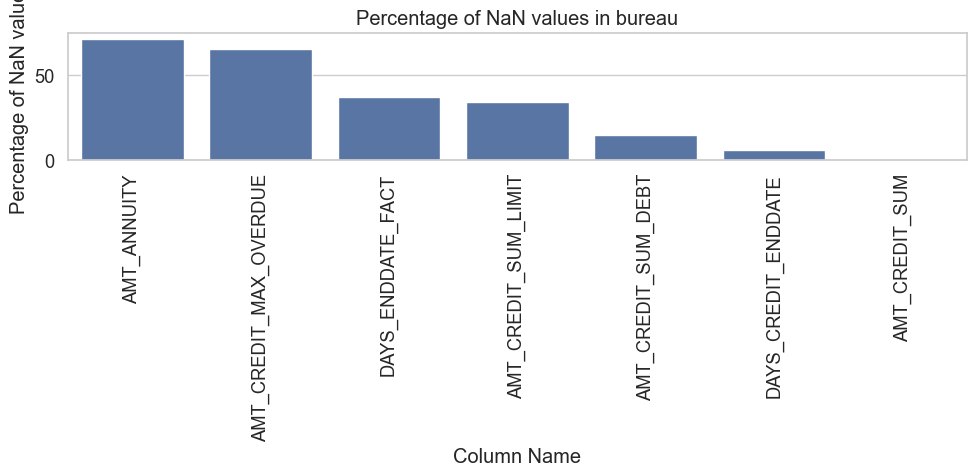

----------------------------------------------------------------------------------------------------


In [39]:
nan_df_bureau = nan_df_create(bureau)
print("-"*100)
plot_nan_percent(nan_df_bureau, 'bureau', tight_layout = False, figsize = (10,5))
print('-'*100)

##### merge bureau et application_train

In [40]:
print("-"*100)
print("Merging TARGET with bureau Table")
bureau_merged = application_train.iloc[:,:2].merge(bureau, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with bureau Table


----------------------------------------------------------------------------------------------------


In [41]:
bureau_merged

SK_ID_CURR  TARGET  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  \
0            100002       1     6158904.0        Closed      currency 1   
1            100002       1     6158905.0        Closed      currency 1   
2            100002       1     6158906.0        Closed      currency 1   
3            100002       1     6158907.0        Closed      currency 1   
4            100002       1     6158908.0        Closed      currency 1   
...             ...     ...           ...           ...             ...   
1509340      456255       0     5126333.0        Active      currency 1   
1509341      456255       0     5126334.0        Active      currency 1   
1509342      456255       0     5126335.0        Closed      currency 1   
1509343      456255       0     5126336.0        Closed      currency 1   
1509344      456255       0     5126337.0        Closed      currency 1   

         DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  \
0            -1125.0                 0.0              -1038.0   
1             -476.0                 0.0                  NaN   
2            -1437.0                 0.0              -1072.0   
3            -1121.0                 0.0               -911.0   
4             -645.0                 0.0                 85.0   
...              ...                 ...                  ...   
1509340       -363.0                 0.0               1463.0   
1509341       -451.0                 0.0                279.0   
1509342      -1512.0                 0.0                315.0   
1509343      -2337.0                 0.0               8620.0   
1509344      -2337.0                 0.0              -1243.0   

         DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
0                  -1038.0                     NaN                 0.0   
1                    -48.0                     NaN                 0.0   
2                  -1185.0                   0.000                 0.0   
3                   -911.0                3321.000                 0.0   
4                    -36.0                5043.645                 0.0   
...                    ...                     ...                 ...   
1509340                NaN                   0.000                 0.0   
1509341                NaN               15439.905                 0.0   
1509342             -781.0               25578.000                 0.0   
1509343             -779.0                2646.000                 1.0   
1509344            -1621.0               16618.500                 0.0   

         AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
0               40761.0                  NaN                   NaN   
1                   0.0                 0.00                   NaN   
2              135000.0                 0.00                   0.0   
3               19071.0                  NaN                   NaN   
4              120735.0                 0.00                   0.0   
...                 ...                  ...                   ...   
1509340        436032.0            363573.54                   0.0   
1509341        450000.0            191005.47                   0.0   
1509342        900000.0                  NaN                   NaN   
1509343         38925.0                  NaN                   NaN   
1509344        450000.0                  NaN                   NaN   

         AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  \
0                           0.0      Credit card             -1038.0   
1                           0.0      Credit card               -47.0   
2                           0.0  Consumer credit             -1185.0   
3                           0.0  Consumer credit              -906.0   
4                           0.0  Consumer credit               -34.0   
...                         ...              ...                 ...   
1509340                     0.0  Consumer credit               -25.0   
1509341              

----------------------------------------------------------------------------------------------------


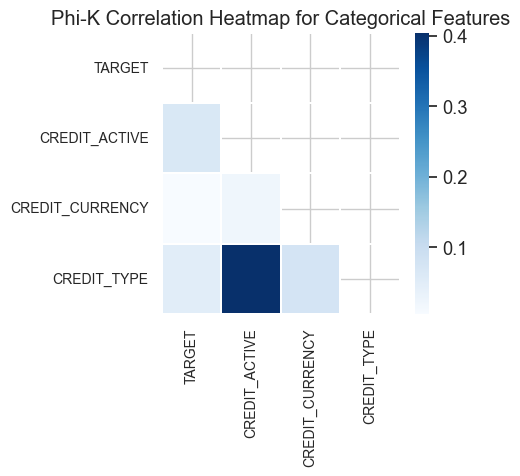

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
0    CREDIT_ACTIVE          0.064481
2      CREDIT_TYPE          0.049954
1  CREDIT_CURRENCY          0.004993

----------------------------------------------------------------------------------------------------


In [42]:
cols_for_phik = ['TARGET','CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE']
plot_phik_matrix(bureau_merged, cols_for_phik,  figsize = (5,5))

In [43]:
bureau_merged

SK_ID_CURR  TARGET  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  \
0            100002       1     6158904.0        Closed      currency 1   
1            100002       1     6158905.0        Closed      currency 1   
2            100002       1     6158906.0        Closed      currency 1   
3            100002       1     6158907.0        Closed      currency 1   
4            100002       1     6158908.0        Closed      currency 1   
...             ...     ...           ...           ...             ...   
1509340      456255       0     5126333.0        Active      currency 1   
1509341      456255       0     5126334.0        Active      currency 1   
1509342      456255       0     5126335.0        Closed      currency 1   
1509343      456255       0     5126336.0        Closed      currency 1   
1509344      456255       0     5126337.0        Closed      currency 1   

         DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  \
0            -1125.0                 0.0              -1038.0   
1             -476.0                 0.0                  NaN   
2            -1437.0                 0.0              -1072.0   
3            -1121.0                 0.0               -911.0   
4             -645.0                 0.0                 85.0   
...              ...                 ...                  ...   
1509340       -363.0                 0.0               1463.0   
1509341       -451.0                 0.0                279.0   
1509342      -1512.0                 0.0                315.0   
1509343      -2337.0                 0.0               8620.0   
1509344      -2337.0                 0.0              -1243.0   

         DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
0                  -1038.0                     NaN                 0.0   
1                    -48.0                     NaN                 0.0   
2                  -1185.0                   0.000                 0.0   
3                   -911.0                3321.000                 0.0   
4                    -36.0                5043.645                 0.0   
...                    ...                     ...                 ...   
1509340                NaN                   0.000                 0.0   
1509341                NaN               15439.905                 0.0   
1509342             -781.0               25578.000                 0.0   
1509343             -779.0                2646.000                 1.0   
1509344            -1621.0               16618.500                 0.0   

         AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
0               40761.0                  NaN                   NaN   
1                   0.0                 0.00                   NaN   
2              135000.0                 0.00                   0.0   
3               19071.0                  NaN                   NaN   
4              120735.0                 0.00                   0.0   
...                 ...                  ...                   ...   
1509340        436032.0            363573.54                   0.0   
1509341        450000.0            191005.47                   0.0   
1509342        900000.0                  NaN                   NaN   
1509343         38925.0                  NaN                   NaN   
1509344        450000.0                  NaN                   NaN   

         AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  \
0                           0.0      Credit card             -1038.0   
1                           0.0      Credit card               -47.0   
2                           0.0  Consumer credit             -1185.0   
3                           0.0  Consumer credit              -906.0   
4                           0.0  Consumer credit               -34.0   
...                         ...              ...                 ...   
1509340                     0.0  Consumer credit               -25.0   
1509341              

La carte thermique ci-dessus montre les valeurs de corrélation Phi-K entre les valeurs catégorielles.

Le coefficient de corrélation Phi-K montre que la variable CREDIT_TYPE est associée à la variable CREDIT_ACTIVE.
Nous constatons que les variables catégorielles ne sont pas vraiment associées à la variable TARGET, en particulier la caractéristique CREDIT_CURRENCY.

----------------------------------------------------------------------------------------------------


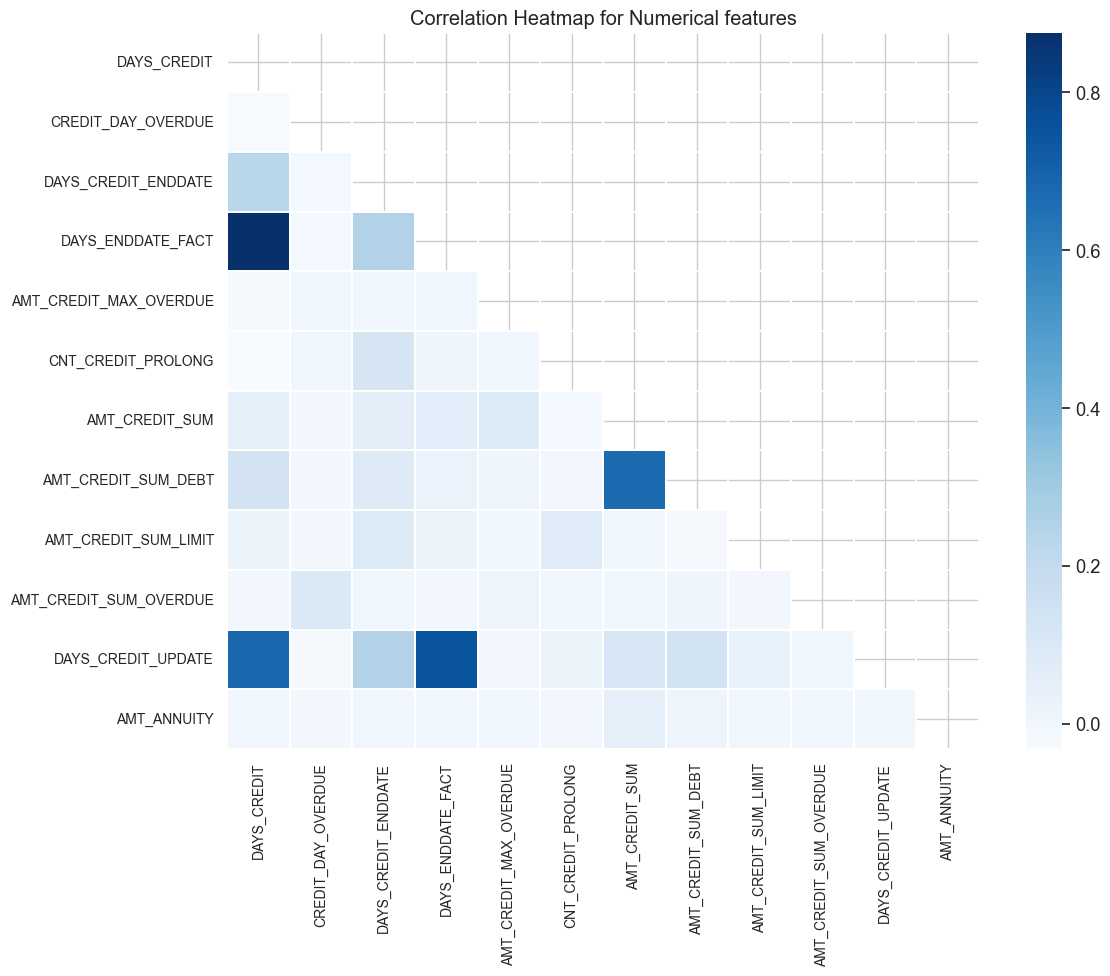

----------------------------------------------------------------------------------------------------


In [44]:
colonnes_numeriques = bureau_merged.select_dtypes(exclude=['object'])
corr_mat = correlation_matrix(colonnes_numeriques, ['SK_ID_CURR','SK_ID_BUREAU'], cmap = 'Blues', figsize = (12,10))
corr_mat.plot_correlation_matrix()

In [45]:

#Seeing the top columns with highest phik-correlation with the target variable in bureau table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT']
interval columns not set, guessing: ['TARGET', 'CREDIT_DAY_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_ENDDATE']
interval columns not set, guessing: ['TARGET', 'DAYS_ENDDATE_FACT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_MAX_OVERDUE']
interval columns not set, guessing: ['TARGET', 'CNT_CREDIT_PROLONG']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_DEBT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_LIMIT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_UPDATE']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


Column Name  Phik-Correlation
0              DAYS_CREDIT          0.088648
2      DAYS_CREDIT_ENDDATE          0.018997
9   AMT_CREDIT_SUM_OVERDUE          0.005654
8     AMT_CREDIT_SUM_LIMIT          0.005107
4   AMT_CREDIT_MAX_OVERDUE          0.004280
5       CNT_CREDIT_PROLONG          0.003862
1       CREDIT_DAY_OVERDUE          0.002528
10      DAYS_CREDIT_UPDATE          0.002158
7      AMT_CREDIT_SUM_DEBT          0.001695
6           AMT_CREDIT_SUM          0.000670

----------------------------------------------------------------------------------------------------


La heatmap ci-dessus montre la corrélation entre chaque caractéristique du tableau du bureau et le reste des caractéristiques.
On peut observer que la plupart des couleurs de la carte thermique sont claires, ce qui indique une corrélation faible ou nulle.
Cependant, nous pouvons voir quelques teintes foncées qui représentent une forte corrélation.
La corrélation élevée est particulièrement observée pour les caractéristiques suivantes : DAYS_CREDIT et DAYS_CREDIT :
DAYS_CREDIT et DAYS_CREDIT_UPDATE
DAYS_ENDDATE_FACT et DAYS_CREDIT_UPDATE
AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT
DAYS_ENDDATE_FACT et DAYS_CREDIT
Nous pouvons également constater que les caractéristiques ne présentent pas de corrélation particulièrement bonne/élevée avec Target en tant que tel, à l'exception de la caractéristique DAYS_CREDIT. Cela signifie qu'il n'existe pas de relation linéaire directe entre Target et les caractéristiques.

_____________________________________________________________
Représentation graphique des variables catégorielles
Nous allons maintenant tracer certaines des variables catégorielles de la table bureau et voir leur impact sur la variable cible.

Distribution de la variable catégorielle CREDIT_ACTIVE

Cette colonne décrit l'état du prêt précédent indiqué par le bureau de crédit.

----------------------------------------------------------------------------------------------------
The unique categories of 'CREDIT_ACTIVE' are:
['Closed' 'Active' nan 'Sold' 'Bad debt']
----------------------------------------------------------------------------------------------------
Counts of each category are:
CREDIT_ACTIVE
Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CREDIT_ACTIVE = 5


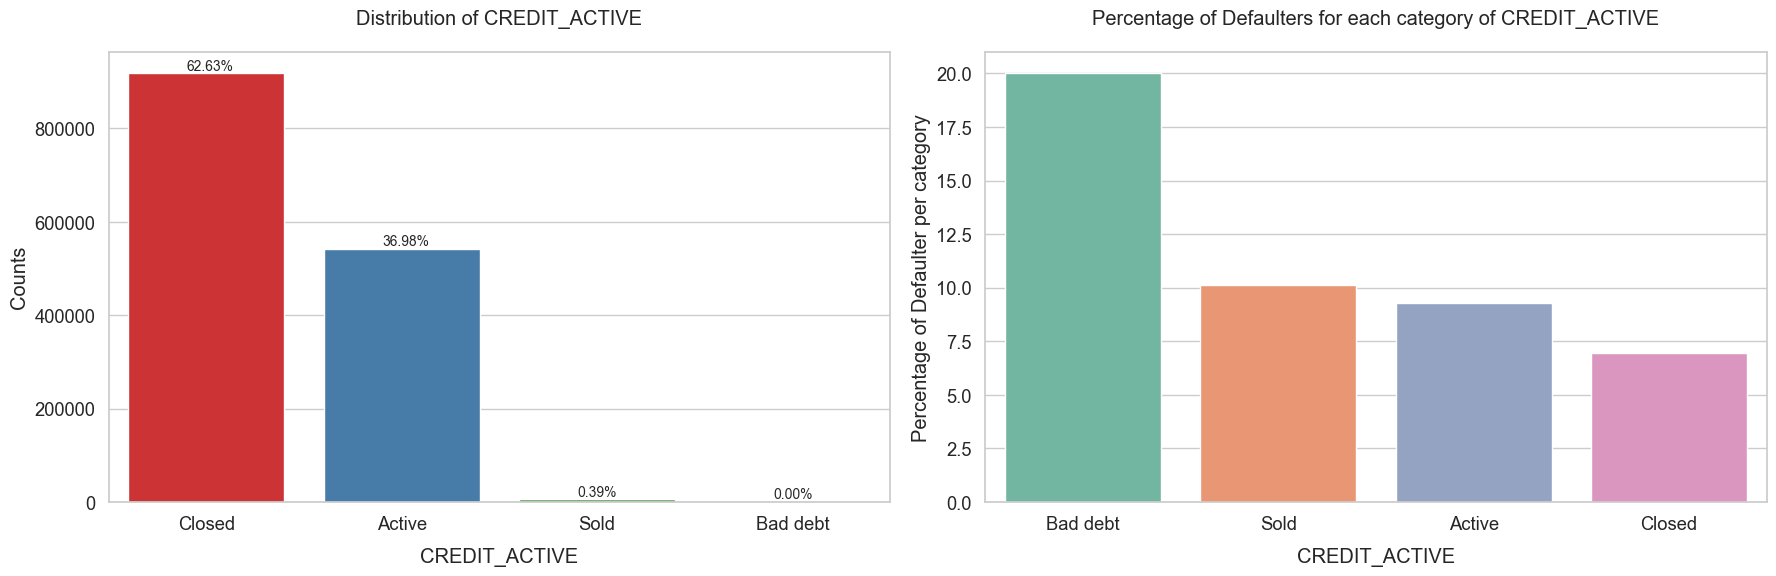

----------------------------------------------------------------------------------------------------


In [46]:
#let us first see the unique categories of 'CREDIT_ACTIVE'
print_unique_categories(bureau_merged, 'CREDIT_ACTIVE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(bureau_merged, column_name = 'CREDIT_ACTIVE', horizontal_adjust = 0.3, fontsize_percent = 'x-small')
print('-'*100)

Le graphique ci-dessus nous permet de tirer les conclusions suivantes :

Le premier sous-graphe montre que la majorité des prêts accordés précédemment par d'autres institutions financières sont des prêts fermés (62,63 %), suivis par 36,98 % de prêts actifs. Les prêts vendus et les prêts irrécouvrables sont très peu nombreux.
Si nous examinons le pourcentage de défaillants par catégorie, nous constatons qu'environ 20 % des personnes ayant contracté un prêt pour dettes douteuses ont été défaillantes, ce qui représente le taux de défaillance le plus élevé. Viennent ensuite les prêts vendus et les prêts actifs. Le taux de défaillance le plus faible concerne les prêts clôturés, qui témoignent d'un bon historique du client. La tendance observée ici est donc tout à fait logique et attendue.

______________________________________________________________
Représentation graphique des variables continues
Distribution d'une variable continue avec les caractéristiques DAYS

DAYS_CREDIT

Cette colonne indique le nombre de jours précédant la demande actuelle lorsque le client a demandé un crédit à l'agence d'évaluation du crédit. Pour faciliter l'interprétation, nous convertirons ces jours en années.

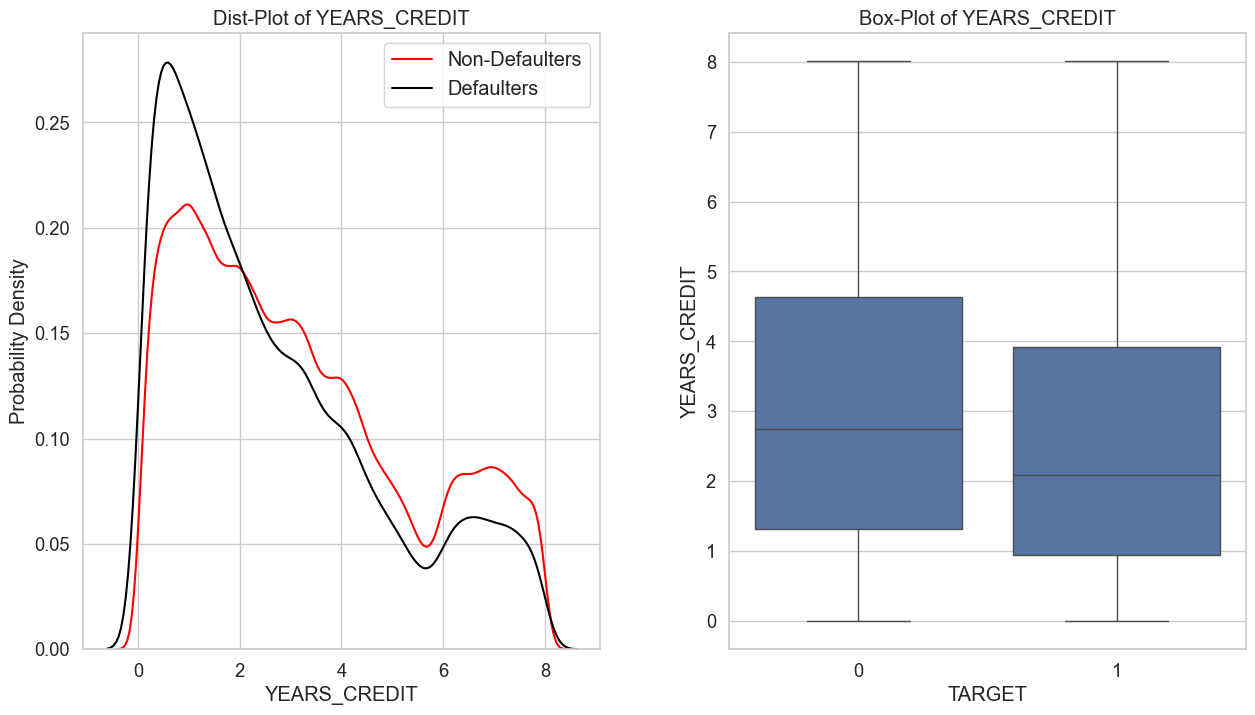

In [47]:
bureau_merged['YEARS_CREDIT'] = bureau_merged['DAYS_CREDIT'] / -365
plot_continuous_variables(bureau_merged, 'YEARS_CREDIT', plots = ['distplot', 'box'], figsize = (15,8))
_ = bureau_merged.pop('YEARS_CREDIT')

Les graphiques ci-dessus montrent que :

D'après le PDF, nous constatons que les mauvais payeurs ont tendance à avoir des pics plus élevés que les non mauvais payeurs lorsque le nombre d'années est inférieur. Cela signifie que les candidats qui ont demandé un prêt à l'agence d'évaluation du crédit récemment ont davantage tendance à être défaillants que ceux qui ont demandé un prêt il y a longtemps. Le PDF des mauvais payeurs est également un peu plus à gauche que celui des non mauvais payeurs.
Sur le diagramme en boîte, nous constatons également que les mauvais payeurs ont généralement moins de YEARS_CREDIT que les mauvais payeurs.

_____________________________________________________________
JOURS_CREDIT_ENDDATE

Cette colonne indique la durée restante du crédit du bureau de crédit au moment de la demande de prêt en crédit immobilier.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_ENDDATE is -42060.0
The 2th percentile value of DAYS_CREDIT_ENDDATE is -2487.0
The 4th percentile value of DAYS_CREDIT_ENDDATE is -2334.0
The 6th percentile value of DAYS_CREDIT_ENDDATE is -2202.0
The 8th percentile value of DAYS_CREDIT_ENDDATE is -2073.9199999999983
The 10th percentile value of DAYS_CREDIT_ENDDATE is -1939.0
The 25th percentile value of DAYS_CREDIT_ENDDATE is -1144.0


The 50th percentile value of DAYS_CREDIT_ENDDATE is -334.0
The 75th percentile value of DAYS_CREDIT_ENDDATE is 473.0
The 100th percentile value of DAYS_CREDIT_ENDDATE is 31199.0
----------------------------------------------------------------------------------------------------


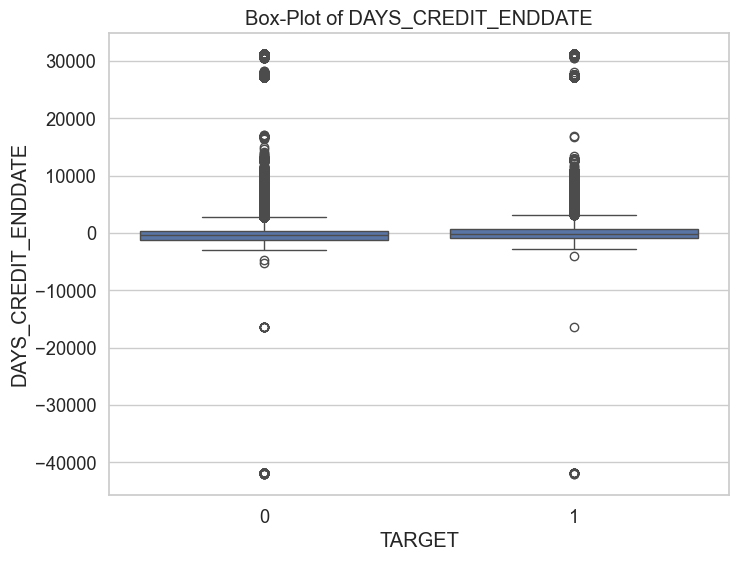

----------------------------------------------------------------------------------------------------


In [48]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_ENDDATE', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_ENDDATE', plots = ['box'], figsize = (8,6))
print('-'*100)

Observations et conclusions :
Les valeurs percentiles ci-dessus et le diagramme en boîte révèlent une valeur erronée pour DAYS_CREDIT_ENDDATE, la valeur du 0e percentile remontant jusqu'à 42060 jours ou 115 ans. Cela n'a pas beaucoup de sens, car cela implique que le prêt précédent du client remonte à 115 ans. Il pourrait également s'agir d'un prêt hérité, mais nous ne pouvons pas faire de commentaires à ce sujet. Nous essaierons de supprimer ces valeurs lors de la phase de prétraitement des données.

______________________________________________________________DAYS_ENDDATE_FACT

Cette colonne indique le nombre de jours depuis lesquels le crédit du bureau de crédit a été clôturé au moment de la demande de prêt dans le crédit à l'habitat. Ces valeurs ne concernent que les crédits clôturés.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_ENDDATE_FACT is -42023.0
The 2th percentile value of DAYS_ENDDATE_FACT is -2561.0
The 4th percentile value of DAYS_ENDDATE_FACT is -2450.0
The 6th percentile value of DAYS_ENDDATE_FACT is -2351.0
The 8th percentile value of DAYS_ENDDATE_FACT is -2265.0
The 10th percentile value of DAYS_ENDDATE_FACT is -2173.0


The 25th percentile value of DAYS_ENDDATE_FACT is -1503.0
The 50th percentile value of DAYS_ENDDATE_FACT is -900.0
The 75th percentile value of DAYS_ENDDATE_FACT is -427.0
The 100th percentile value of DAYS_ENDDATE_FACT is 0.0
----------------------------------------------------------------------------------------------------


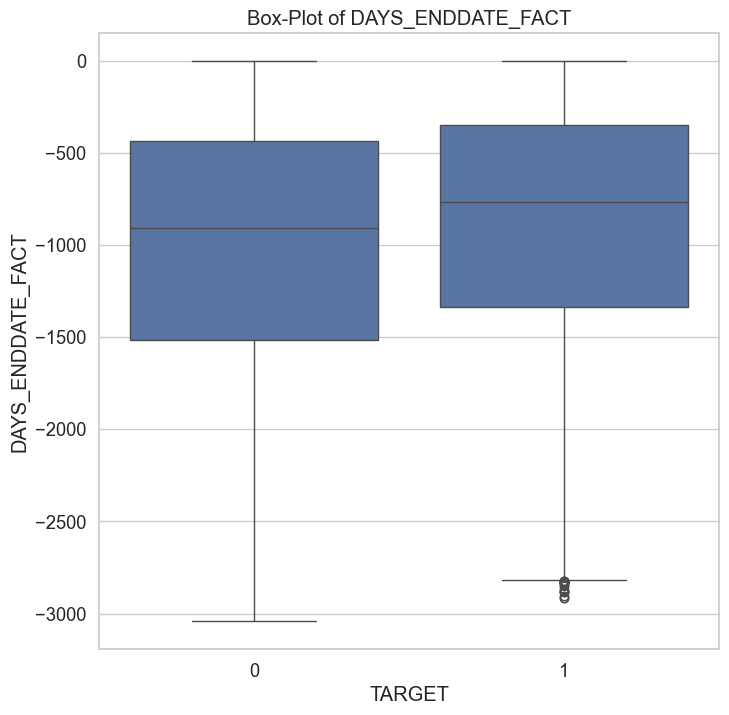

----------------------------------------------------------------------------------------------------


In [49]:
print_percentiles(bureau_merged, 'DAYS_ENDDATE_FACT', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_ENDDATE_FACT', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 0])
print('-'*100)

Observations et conclusions :
Tout comme la colonne précédente, nous constatons que le 0e percentile de cette colonne semble également erroné, puisqu'il est de 42023 jours ou ~115 ans. Nous devrions supprimer ces valeurs, car elles n'ont pas beaucoup de sens.
En examinant le diagramme en boîte, nous constatons que les mauvais payeurs ont tendance à avoir un nombre de jours inférieur depuis la fin de leur crédit au bureau de crédit. Chez les non-défaillants, les crédits précédents sont généralement terminés depuis plus longtemps que chez les défaillants.

______________________________________________________________
JOURS_MISE_À_JOUR_DU_CRÉDIT

Cette colonne indique le nombre de jours depuis lesquels les informations du bureau de crédit ont été mises à jour au moment de la demande de prêt dans le cadre du crédit à l'habitat.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_UPDATE is -41947.0
The 2th percentile value of DAYS_CREDIT_UPDATE is -2415.0
The 4th percentile value of DAYS_CREDIT_UPDATE is -2213.0
The 6th percentile value of DAYS_CREDIT_UPDATE is -2002.0
The 8th percentile value of DAYS_CREDIT_UPDATE is -1766.0
The 10th percentile value of DAYS_CREDIT_UPDATE is -1582.0


The 25th percentile value of DAYS_CREDIT_UPDATE is -904.0
The 50th percentile value of DAYS_CREDIT_UPDATE is -406.0
The 75th percentile value of DAYS_CREDIT_UPDATE is -33.0
The 100th percentile value of DAYS_CREDIT_UPDATE is 372.0
----------------------------------------------------------------------------------------------------


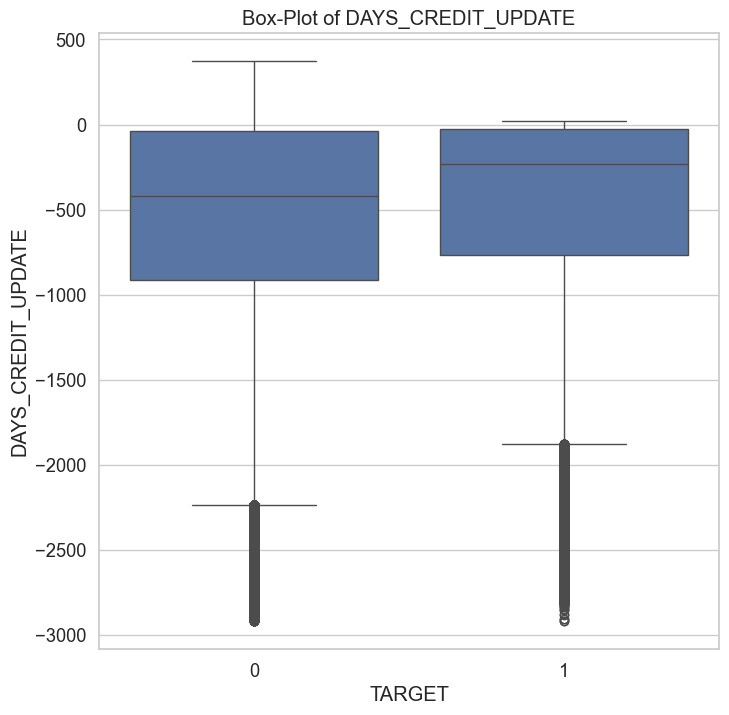

----------------------------------------------------------------------------------------------------


In [50]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_UPDATE', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_UPDATE', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 400])
print('-'*100)

Observations et conclusions :
La tendance des valeurs erronées est à nouveau très similaire à celle de la colonne des autres jours où cette valeur du 0e centile semble être erronée. De plus, étant donné que seule la valeur du 0e centile est si étrange et que les autres semblent correctes, cette valeur est définitivement erronée. Nous supprimerons également cette valeur.
D'après le diagramme en boîte, nous pouvons dire que les mauvais payeurs ont tendance à avoir un nombre inférieur de jours depuis que leurs informations sur le crédit du bureau de crédit ont été reçues. Leurs valeurs médiane et 75e percentile sont toutes inférieures à celles des non-défaillants.

# bureau_balance

___________________________________________________________
bureau_balance.csv
Description de la table
Ce tableau comprend le solde mensuel de chaque crédit pour chacun des crédits antérieurs que le client avait auprès d'institutions financières autres que Home Credit.

In [51]:
print(f'The shape of bureau_balance.csv is: {bureau_balance.shape}')
print('-'*100)
print(f'Number of duplicate values in bureau_balance: {bureau_balance.shape[0] - bureau_balance.duplicated().shape[0]}')
print('-'*100)
display(bureau_balance.head(5))

The shape of bureau_balance.csv is: (27299925, 3)
----------------------------------------------------------------------------------------------------


Number of duplicate values in bureau_balance: 0
----------------------------------------------------------------------------------------------------


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [52]:
print("-"*100)
print(f'Number of unique SK_ID_BUREAU in bureau_balance.csv are: {len(bureau_balance.SK_ID_BUREAU.unique())}')
print('-'*100)
print(f'Number of unique values for STATUS are: {len(bureau_balance.STATUS.unique())}')
print(f"Unique values of STATUS are:\n{bureau_balance.STATUS.unique()}")
print('-'*100)
print(f"Max number of months for Months Balance: {np.abs(bureau_balance.MONTHS_BALANCE.min())}")
print('-'*100)

----------------------------------------------------------------------------------------------------


Number of unique SK_ID_BUREAU in bureau_balance.csv are: 817395
----------------------------------------------------------------------------------------------------
Number of unique values for STATUS are: 8
Unique values of STATUS are:
['C' '0' 'X' '1' '2' '3' '5' '4']
----------------------------------------------------------------------------------------------------
Max number of months for Months Balance: 96
----------------------------------------------------------------------------------------------------


La table bureau_balance.csv contient environ 27,29 millions de lignes et 3 colonnes.
Cette table contient le statut mensuel de chaque prêt précédent pour un demandeur particulier, rapporté par le département du bureau de crédit.
Il y a 8 valeurs uniques pour le STATUS qui sont encodées. Chacune d'entre elles a une signification particulière.
C signifie fermé, X signifie statut inconnu, 0 signifie pas de DPD, 1 signifie que le maximum a été fait pendant le mois entre 1-30, 2 signifie DPD 31-60,... 5 signifie DPD 120+ ou vendu ou passé par pertes et profits.
Le solde du mois le plus ancien dont nous disposons est le statut de 96 mois en arrière, c'est-à-dire que le statut a été fourni jusqu'à 8 ans d'historique pour les prêts pour lesquels il existe.

In [53]:
plot_nan_percent(nan_df_create(bureau_balance), 'bureau_balance')

The dataframe bureau_balance does not contain any NaN values.


### previous_application

Description
This table contains the static data of the previous loan which the client had with Home Credit.

In [54]:
print(f'The shape of previous_application.csv is: {previous_application.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in previous_application.csv are: {len(previous_application.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in previous_application.csv are: {len(previous_application.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in previous_application: {previous_application.shape[0] - previous_application.duplicated().shape[0]}')
print('-'*100)
display(previous_application.head(5))

The shape of previous_application.csv is: (1670214, 37)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in previous_application.csv are: 1670214
Number of unique SK_ID_CURR in previous_application.csv are: 338857
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: 291057
Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: 47800
----------------------------------------------------------------------------------------------------
Number of duplicate values in previous_application: 0
----------------------------------------------------------------------------------------------------


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

La table previous_application.csv comprend 1,67 million de lignes au total. Chaque ligne correspond à chacun des prêts antérieurs que le client a contractés auprès du Home Credit Group. Il est possible pour un seul client de la demande actuelle d'avoir plusieurs prêts antérieurs avec le Home Credit Group.
Il y a 37 colonnes dans previous_application.csv, qui contiennent les détails du prêt précédent.
Il y a 338k SK_ID_CURR uniques dans previous_application, dont 291k correspondent aux SK_ID_CURR de application_train et 47,8k correspondent aux SK_ID_CURR de application_test.

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 16 columns


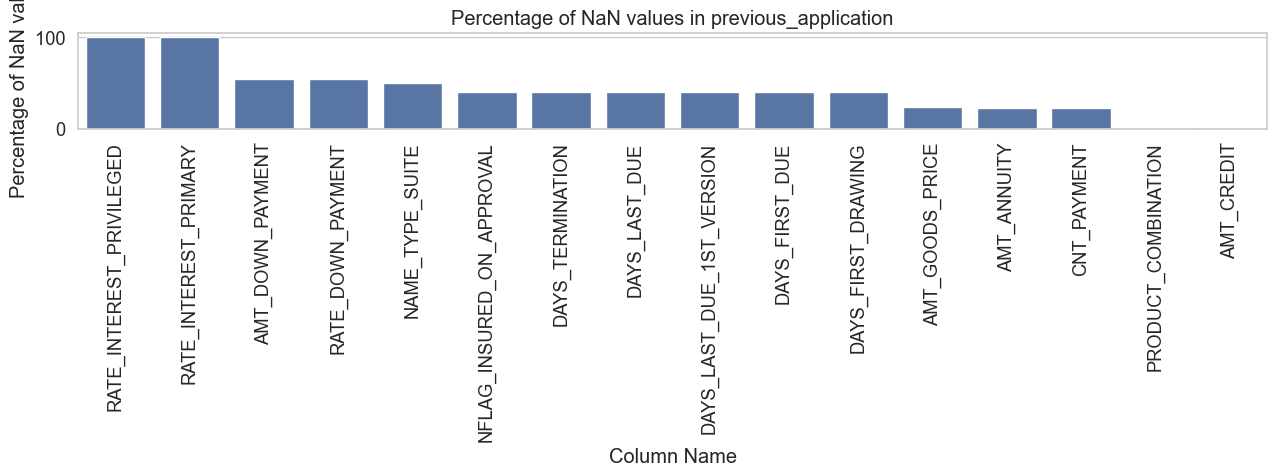

----------------------------------------------------------------------------------------------------


In [55]:
previous_application_nan = nan_df_create(previous_application)
print('-' * 100)
plot_nan_percent(previous_application_nan, 'previous_application', tight_layout = False, figsize = (13,5))
print('-' * 100)
del previous_application_nan

Sur les 37 colonnes, 16 contiennent des valeurs NaN.
Deux de ces colonnes ont 99,64 % de valeurs manquantes, ce qui est très élevé, et nous devrons trouver un moyen intelligent de traiter des valeurs NaN aussi élevées. Nous ne pouvons pas écarter directement une caractéristique à ce stade.
Hormis ces deux colonnes, le reste des colonnes contient également > 40 % de valeurs NaN, à l'exception de 5 colonnes.

In [56]:
print("-"*100)
print("Merging TARGET with previous_application Table")
prev_merged = application_train.iloc[:,:2].merge(previous_application, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with previous_application Table


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


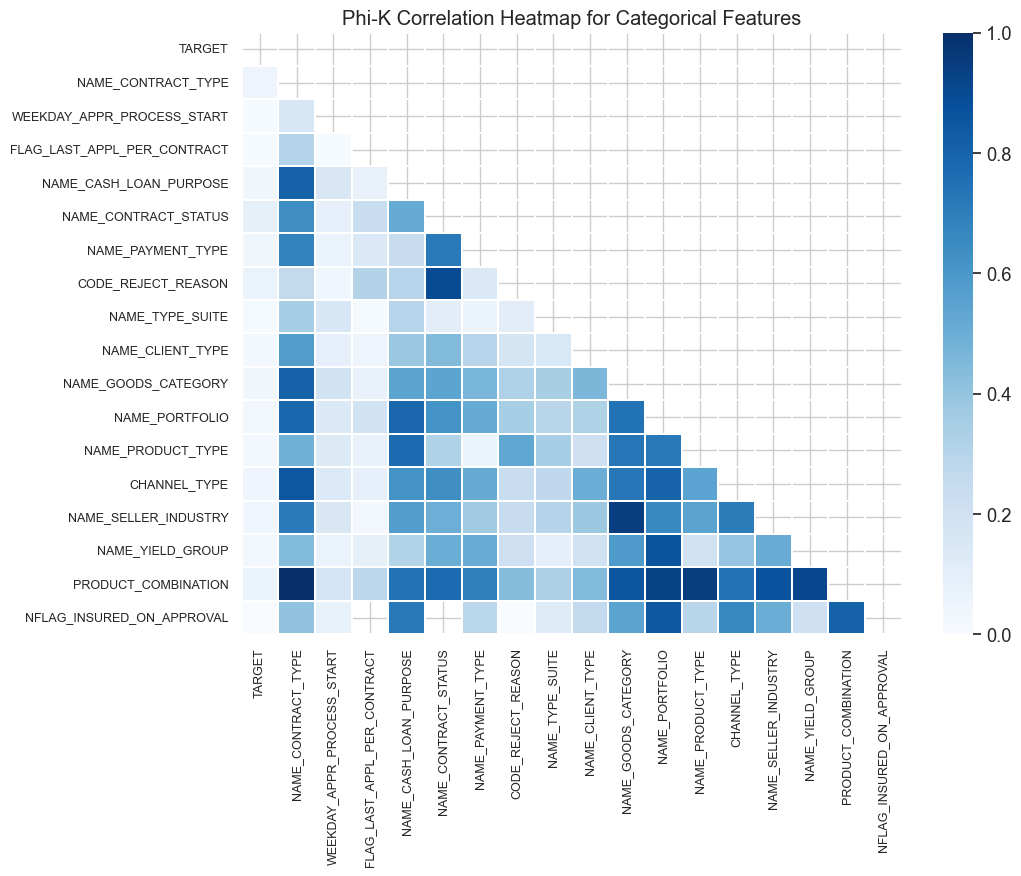

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
4     NAME_CONTRACT_STATUS          0.088266
15     PRODUCT_COMBINATION          0.063839
6       CODE_REJECT_REASON          0.062771
0       NAME_CONTRACT_TYPE          0.050859
12            CHANNEL_TYPE          0.050302
9      NAME_GOODS_CATEGORY          0.042951
3   NAME_CASH_LOAN_PURPOSE          0.040305
5        NAME_PAYMENT_TYPE          0.039752
13    NAME_SELLER_INDUSTRY          0.038077
14        NAME_YIELD_GROUP          0.034626

----------------------------------------------------------------------------------------------------


In [57]:
cols_for_phik = ['TARGET'] + prev_merged.dtypes[prev_merged.dtypes == 'object'].index.tolist() + ['NFLAG_INSURED_ON_APPROVAL']
plot_phik_matrix(prev_merged, cols_for_phik, cmap = 'Blues', figsize = (11,9), fontsize = 9)

La heatmap ci-dessus des valeurs du coefficient Phi-K pour les caractéristiques catégorielles montre que :

La caractéristique PRODUCT_COMBINATION est associée à de nombreuses autres caractéristiques telles que NAME_CONTRACT_TYPE, NAME_PRODUCT_TYPE, NAME_PORTFOLIO, etc.
La caractéristique NAME_GOODS_CATEGORY est également fortement associée à NAME_SELLER_INDUSTRY.
Si nous examinons l'association avec la variable TARGET, nous constatons que les caractéristiques NAME_CONTRACT_STATUS, PRODUCT_COMBINATION, CODE_REJECT_REASON sont parmi les caractéristiques les plus fortement associées et devraient faire l'objet d'un examen plus approfondi.

----------------------------------------------------------------------------------------------------


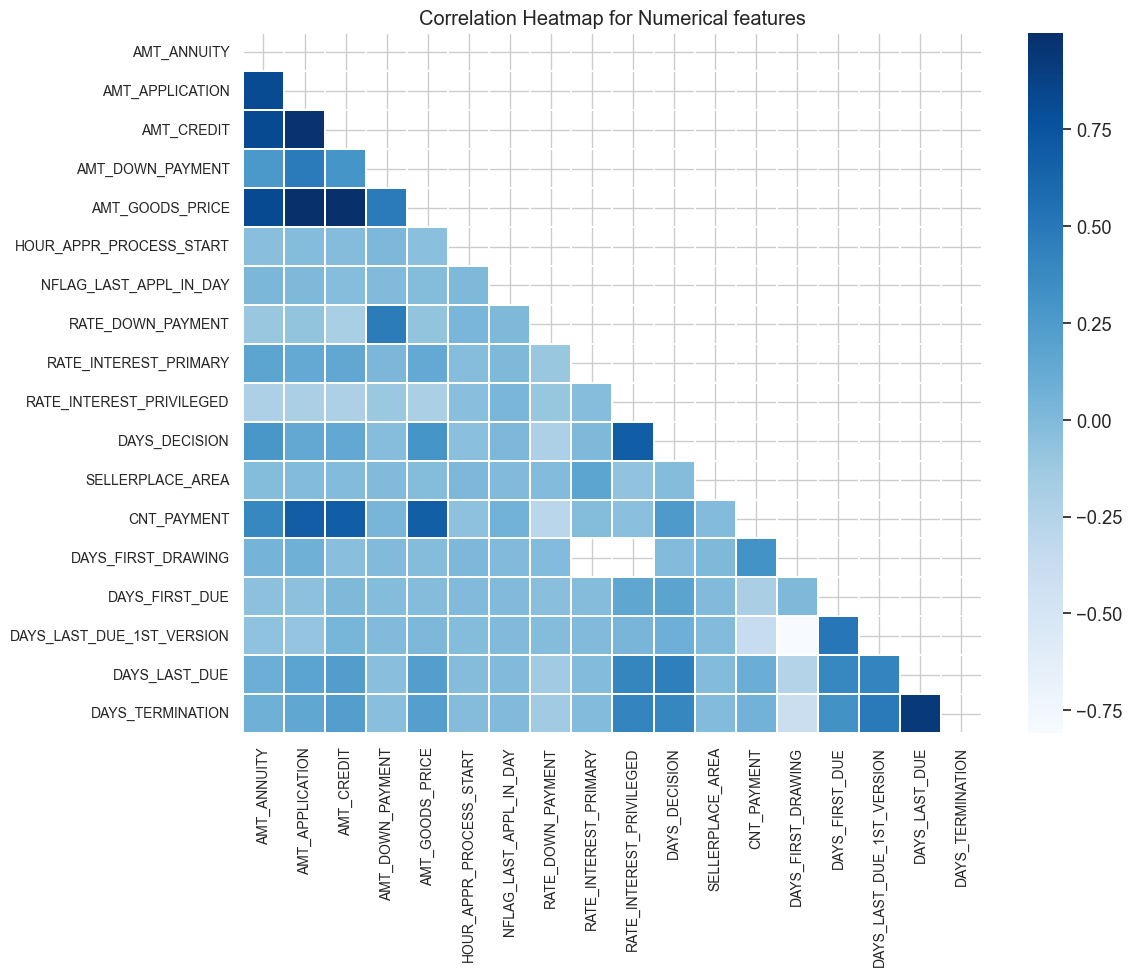

----------------------------------------------------------------------------------------------------


In [58]:
colonnes_numeriques = prev_merged.select_dtypes(exclude=['object'])
corr_mat = correlation_matrix(colonnes_numeriques, ['SK_ID_CURR','SK_ID_PREV','NFLAG_INSURED_ON_APPROVAL'], cmap = 'Blues', figsize = (12,10))
corr_mat.plot_correlation_matrix()

In [59]:
#Seeing the top columns with highest phik-correlation with the target variable in previous_applications table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_APPLICATION']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'NFLAG_LAST_APPL_IN_DAY']
interval columns not set, guessing: ['TARGET', 'RATE_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIMARY']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIVILEGED']
interval columns not set, guessing: ['TARGET', 'DAYS_DECISION']
interval columns not set, guessing: ['TARGET', 'SELLERPLACE_AREA']
interval columns not set, guessing: ['TARGET', 'CNT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DRAWING']
interval columns not set, guessing: ['TARGET', 'DAYS_F

Column Name  Phik-Correlation
12                CNT_PAYMENT          0.056639
10              DAYS_DECISION          0.053695
13         DAYS_FIRST_DRAWING          0.048990
7           RATE_DOWN_PAYMENT          0.039592
5     HOUR_APPR_PROCESS_START          0.038121
9    RATE_INTEREST_PRIVILEGED          0.028204
15  DAYS_LAST_DUE_1ST_VERSION          0.027877
16              DAYS_LAST_DUE          0.027321
17           DAYS_TERMINATION          0.026480
0                 AMT_ANNUITY          0.013808

----------------------------------------------------------------------------------------------------


La heatmap ci-dessus montre la corrélation entre chaque caractéristique de la table application_précédente et le reste des caractéristiques.
Sur la carte thermique, nous pouvons voir certaines caractéristiques fortement corrélées qui ont une couleur plus foncée.
La corrélation élevée est particulièrement observée pour les caractéristiques suivantes :
DAYS_TERMINATION et DAYS_LAST_DUE
AMT_CREDIT et AMT_APPLICATION
AMT_APPLICATION et AMT_GOODS_PRICE
AMT_CREDIT et AMT_ANNUITÉ
AMT_ANNUITÉ et AMT_CREDIT
AMT_CREDIT et AMT_GOODS_PRICE
Nous pouvons également constater que les caractéristiques ne présentent pas de corrélation particulièrement bonne/élevée avec Target en tant que tel. Cela signifie qu'il n'y a pas vraiment de relation linéaire directe entre Target et les caractéristiques.

Représentation graphique des variables catégorielles
Traçons maintenant certaines des variables catégorielles de la table previous_application et voyons comment elles influencent la variable cible.

Distribution de la variable catégorielle TYPE_CONTRAT_NOM

Cette colonne décrit le type de contrat du prêt précédent avec le Home Credit Group.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Consumer loans' 'Cash loans' 'Revolving loans' nan 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
NAME_CONTRACT_TYPE
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_TYPE = 5


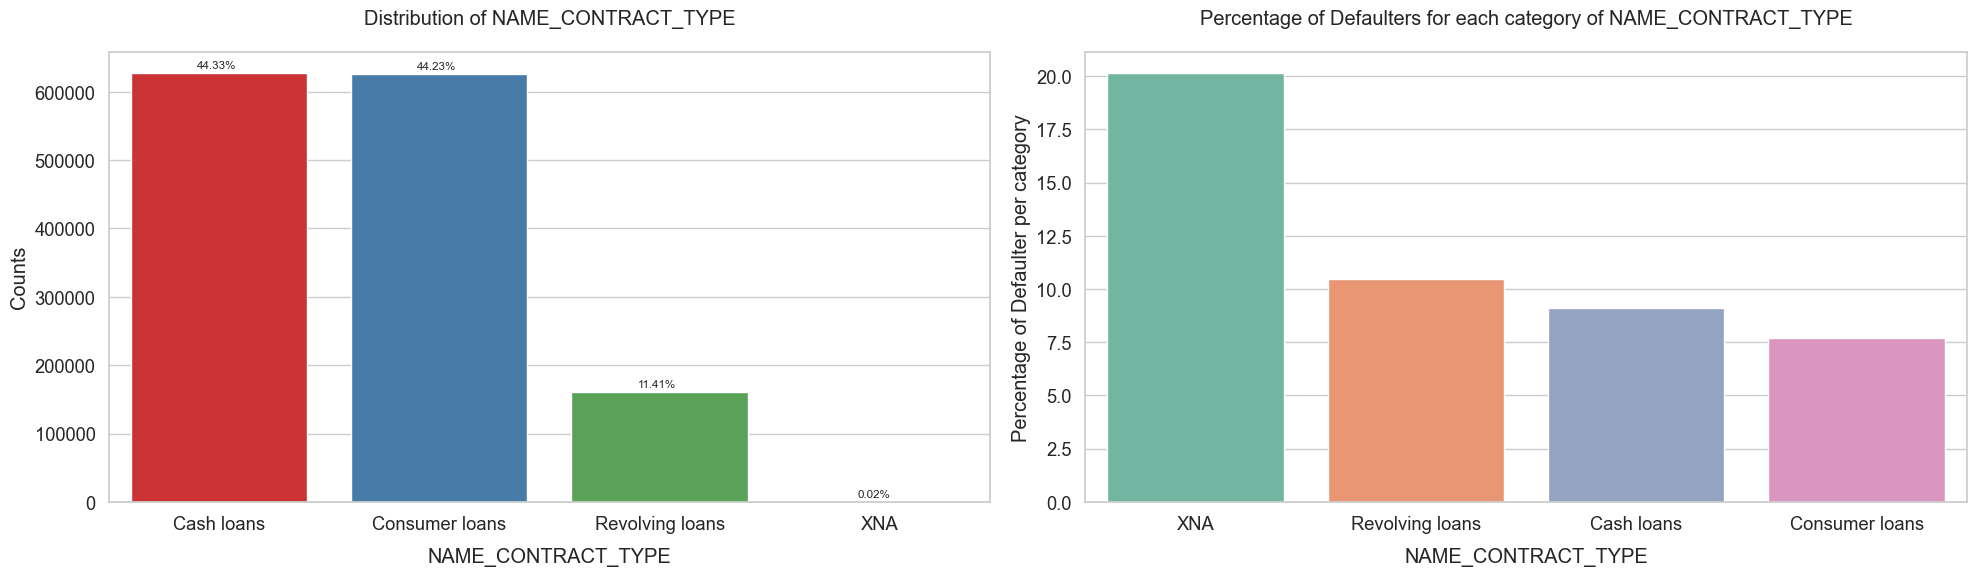

----------------------------------------------------------------------------------------------------


In [60]:

#let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(prev_merged, 'NAME_CONTRACT_TYPE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_TYPE', horizontal_adjust = 0.3, figsize = (20, 6))
print('-'*100)

Les graphiques ci-dessus nous permettent d'observer ce qui suit :

Le premier sous-graphe montre que la plupart des prêts précédents étaient des prêts de trésorerie ou des prêts à la consommation, qui représentent chacun environ 44 % des prêts. Les 11,41 % restants correspondent à des prêts renouvelables, et il y a quelques prêts nommés XNA dont les types ne sont pas connus, mais ils sont très peu nombreux.
En examinant le deuxième sous-graphe, nous constatons que le pourcentage de défaillants pour les prêts de type XNA est le plus élevé, avec un taux de défaillance de 20 %. Le deuxième taux de défaillance le plus élevé est celui des prêts renouvelables, qui avoisine les 10,5 %.
Les prêts de trésorerie ont des taux de défaillance moins élevés, environ 9 %, tandis que les prêts à la consommation ont tendance à avoir le plus faible pourcentage de défaillants, qui est proche de 7,5 %.

_____________________________________________________________
Distribution de la variable catégorielle NOM_CONTRACT_STATUS

Cette colonne décrit le statut du contrat du prêt précédent avec Home Credit, c'est-à-dire s'il est actif ou fermé, etc.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_STATUS' are:
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_STATUS = 5


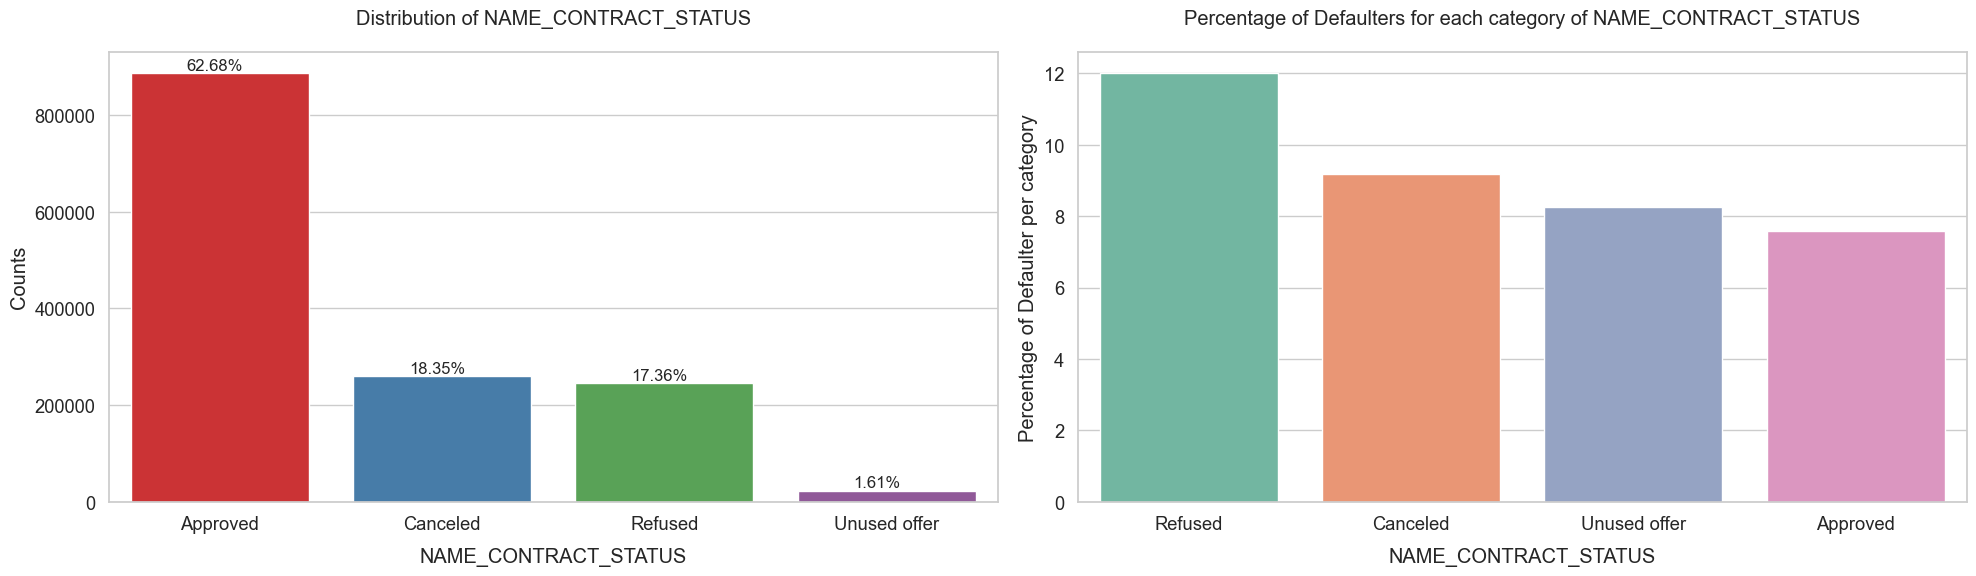

----------------------------------------------------------------------------------------------------


In [61]:
#let us first see the unique categories of 'NAME_CONTRACT_STATUS'
print_unique_categories(prev_merged, 'NAME_CONTRACT_STATUS')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_STATUS', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small')
print('-'*100)

Les graphiques ci-dessus montrent que :

Le type de statut de contrat le plus courant est le statut approuvé. Environ 63% des crédits précédents ont un statut approuvé. Les deux autres statuts les plus courants sont Annulé et Refusé, qui correspondent tous deux à environ 18% des prêts. Cela signifie que la plupart des prêts sont approuvés et que seule une partie d'entre eux ne le sont pas. Le statut de contrat le moins fréquent est l'offre inutilisée, qui correspond à seulement 1,61 % de tous les prêts.
Si l'on examine le deuxième sous-graphe relatif au pourcentage de défaillants, on constate que les prêts qui avaient précédemment le statut Refusé ont tendance à être les plus défaillants dans les prêts actuels. Ils correspondent à environ 12 % des défaillants de cette catégorie. Ils sont suivis par les prêts annulés qui correspondent à près de 9 % du taux de défaillance. Ce comportement est tout à fait logique, puisque ces personnes ont dû être refusées parce qu'elles n'avaient pas le profil adéquat. Le taux de défaillance le plus faible est observé pour le statut de contrat approuvé.

______________________________________________________________
Distribution de la variable catégorielle CODE_REJECT_REASON

Cette colonne décrit la raison du rejet d'un prêt précédemment demandé au Home Credit Group.

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_REJECT_REASON' are:
['XAP' 'LIMIT' nan 'HC' 'SCO' 'SCOFR' 'VERIF' 'CLIENT' 'XNA' 'SYSTEM']
----------------------------------------------------------------------------------------------------
Counts of each category are:
CODE_REJECT_REASON
XAP       1145533
HC         145984
LIMIT       47773
SCO         32636
CLIENT      22771
SCOFR       10875
XNA          4378
VERIF        3079
SYSTEM        672
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CODE_REJECT_REASON = 10


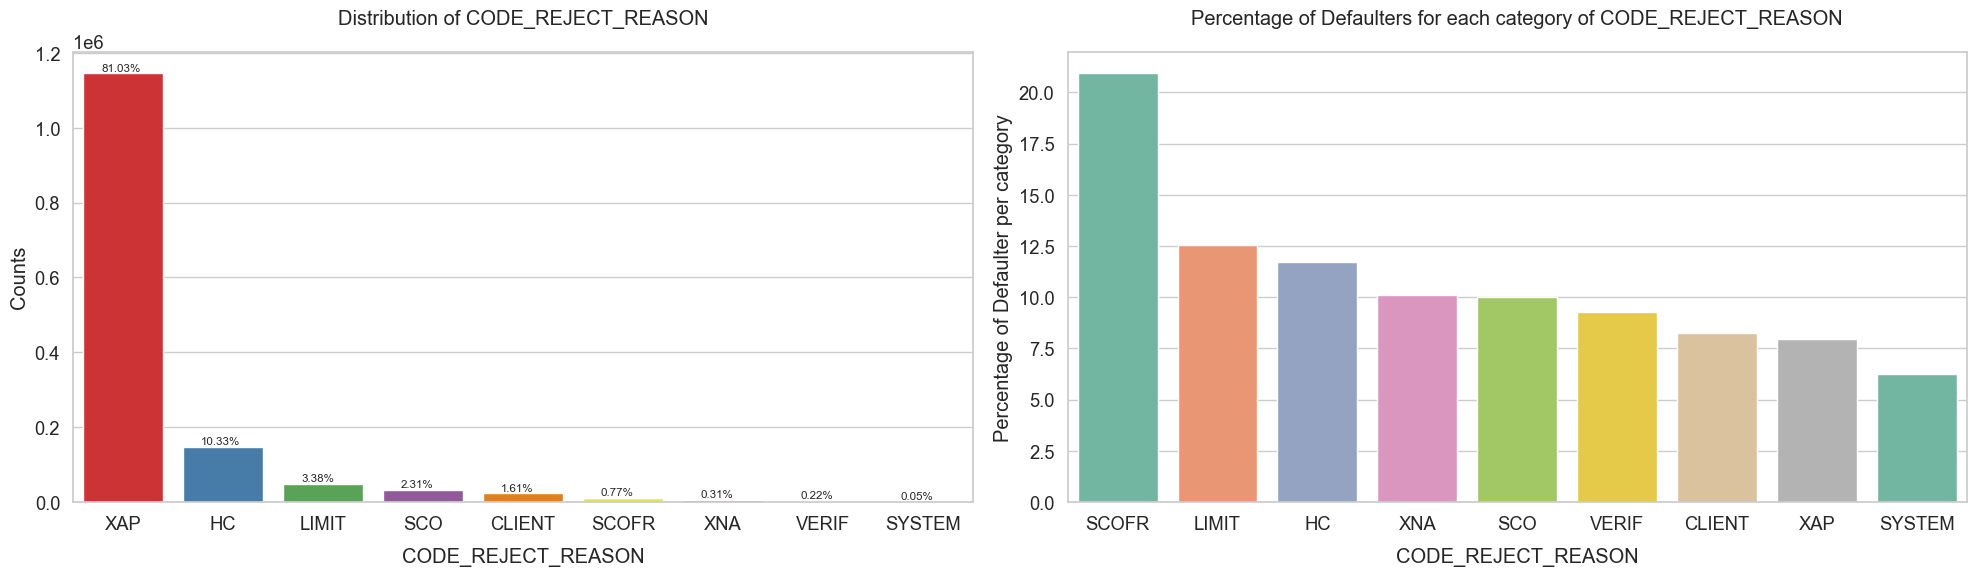

----------------------------------------------------------------------------------------------------


In [62]:
#let us first see the unique categories of 'CODE_REJECT_REASON'
print_unique_categories(prev_merged, 'CODE_REJECT_REASON', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'CODE_REJECT_REASON', horizontal_adjust = 0.18, figsize = (20, 6))
print('-'*100)

Observations et conclusions :
Le graphique ci-dessus montre la distribution de la variable catégorielle CODE_REJECT_REASON. Les observations suivantes peuvent être tirées du graphique ci-dessus :

Le type de motif de rejet le plus courant est XAP, soit environ 81 %. Les autres motifs ne représentent qu'une petite partie des motifs de rejet. HC est le deuxième motif de rejet le plus fréquent avec seulement 10,33% des occurrences.
La distribution du pourcentage de demandeurs défaillants pour chaque catégorie de CODE_REJECT_REASON est assez intéressante. Les candidats dont les demandes précédentes ont été rejetées par le code SCOFT ont le pourcentage le plus élevé de défaillants parmi eux (~21%). Viennent ensuite LIMIT et HC, qui comptent respectivement 12,5 % et 12 % de mauvais payeurs.
Le motif de rejet le plus courant, XAP, ne concerne que 7,5 % des candidats défaillants, soit le pourcentage le plus faible après le code SYSTEM.

___________________________________________________________
Distribution de la variable catégorielle CHANNEL_TYPE

Cette colonne décrit le canal par lequel le client a été acquis pour le prêt précédent dans le cadre du crédit à domicile.

----------------------------------------------------------------------------------------------------
The unique categories of 'CHANNEL_TYPE' are:
['Stone' 'Credit and cash offices' 'Country-wide' 'Regional / Local'
 'AP+ (Cash loan)' 'Contact center' nan 'Channel of corporate sales'
 'Car dealer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CHANNEL_TYPE = 9


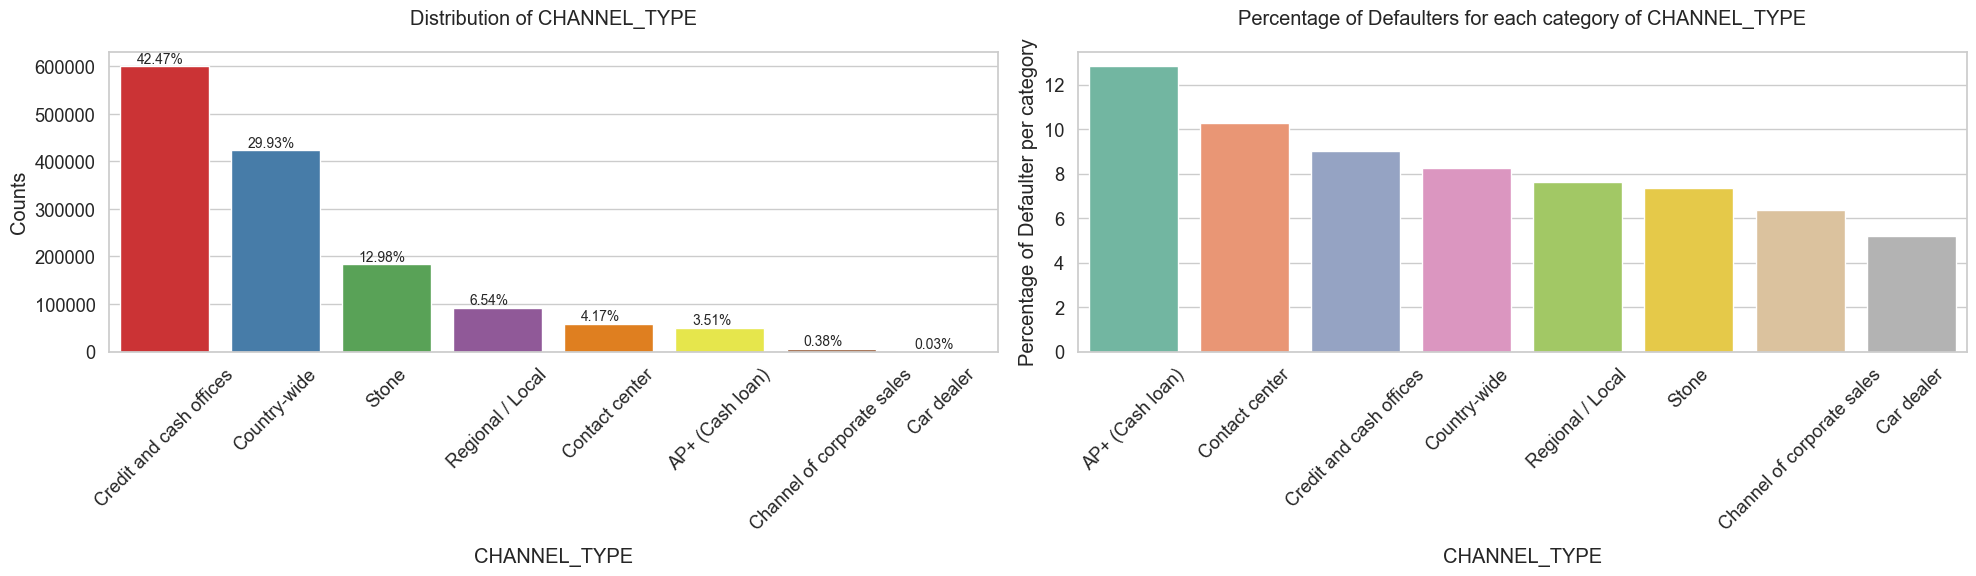

----------------------------------------------------------------------------------------------------


In [63]:
#let us first see the unique categories of 'CHANNEL_TYPE'
print_unique_categories(prev_merged, 'CHANNEL_TYPE')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'CHANNEL_TYPE', horizontal_adjust = 0.15, rotation = 45, figsize = (20, 6), fontsize_percent = 'x-small')
print('-'*100)

Les deux graphiques ci-dessus montrent la distribution de CHANNEL_TYPE pour les prêts antérieurs dans le crédit à domicile.

Le premier graphique montre que la plupart des demandes ont été faites par l'intermédiaire des bureaux de crédit et des caisses, soit environ 42,47 % des demandes, suivis par le canal national, qui correspond à 29,93 % des demandes. Les autres types de canaux ne correspondent qu'à un nombre limité de demandes.
Le pourcentage de défaillance le plus élevé a été observé parmi les demandes qui avaient un type de canal AP+ (prêt en espèces), ce qui correspondait à environ 13 % de défaillants dans cette catégorie. Les autres canaux affichent des pourcentages de défaillance inférieurs à celui-ci. Le canal des concessionnaires automobiles a affiché le plus faible pourcentage de défaillants dans cette catégorie (seulement 5 %).

______________________________________________________________
Distribution de la variable catégorielle PRODUCT_COMBINATION

Cette colonne donne des détails sur la combinaison de produits des demandes précédentes.

----------------------------------------------------------------------------------------------------
The unique categories of 'PRODUCT_COMBINATION' are:
['POS other with interest' 'Cash X-Sell: low' 'POS industry with interest'
 'POS household with interest' 'POS mobile without interest' 'Card Street'
 'Card X-Sell' 'Cash X-Sell: high' 'Cash' 'Cash Street: high'
 'Cash X-Sell: middle' 'POS mobile with interest'
 'POS household without interest' 'POS industry without interest'
 'Cash Street: low' nan 'Cash Street: middle'
 'POS others without interest']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of PRODUCT_COMBINATION = 18


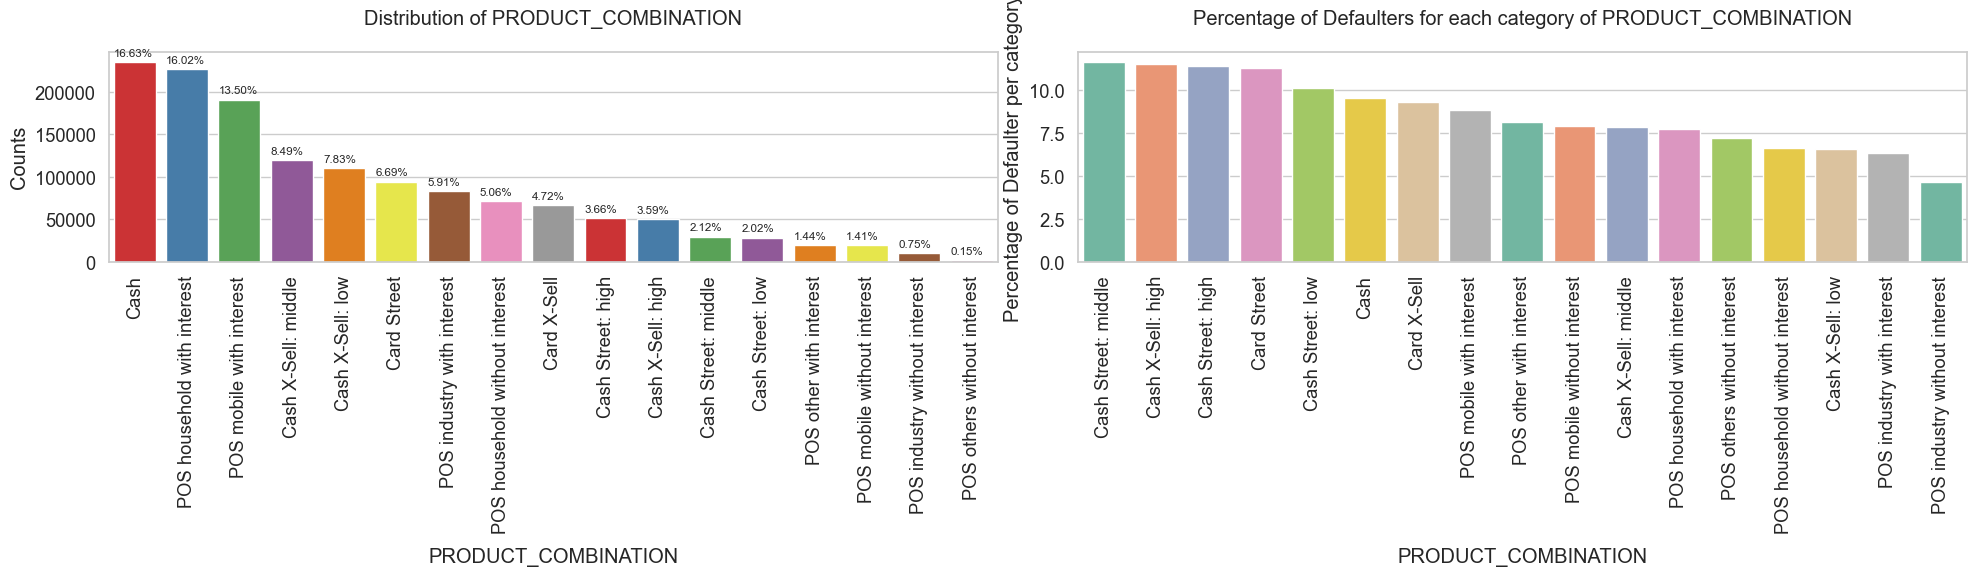

----------------------------------------------------------------------------------------------------


In [64]:
#let us first see the unique categories of 'PRODUCT_COMBINATION'
print_unique_categories(prev_merged, 'PRODUCT_COMBINATION')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'PRODUCT_COMBINATION', rotation = 90, figsize = (20, 6))
print('-'*100)

A partir de la distribution de PRODUCT_COMBINATION, nous pouvons générer les informations suivantes :

Les 3 types de combinaison de produits les plus courants sont l'argent liquide, les points de vente domestiques avec intérêt et les points de vente mobiles avec intérêt. Ils correspondent à environ 50 % de toutes les demandes.
Si l'on examine le pourcentage de défaillants par catégorie, on constate que la tendance à la défaillance est la plus forte dans les catégories suivantes : Cash Street : mobile, Cash X-sell : élevé, Cash Street : élevé et Card Street, qui se situent toutes entre 11 et 11,5 % de défaillants par catégorie. Le pourcentage le plus faible de mauvais payeurs se trouve dans la catégorie Industrie des points de vente sans intérêt, qui correspond à environ 4,5 % de mauvais payeurs.

_____________________________________________________________
Représentation graphique des variables continues
Distribution d'une variable continue avec les caractéristiques DAYS

DAYS_DECISION

Cette colonne indique le nombre de jours par rapport à la demande actuelle où la décision a été prise concernant la demande précédente.

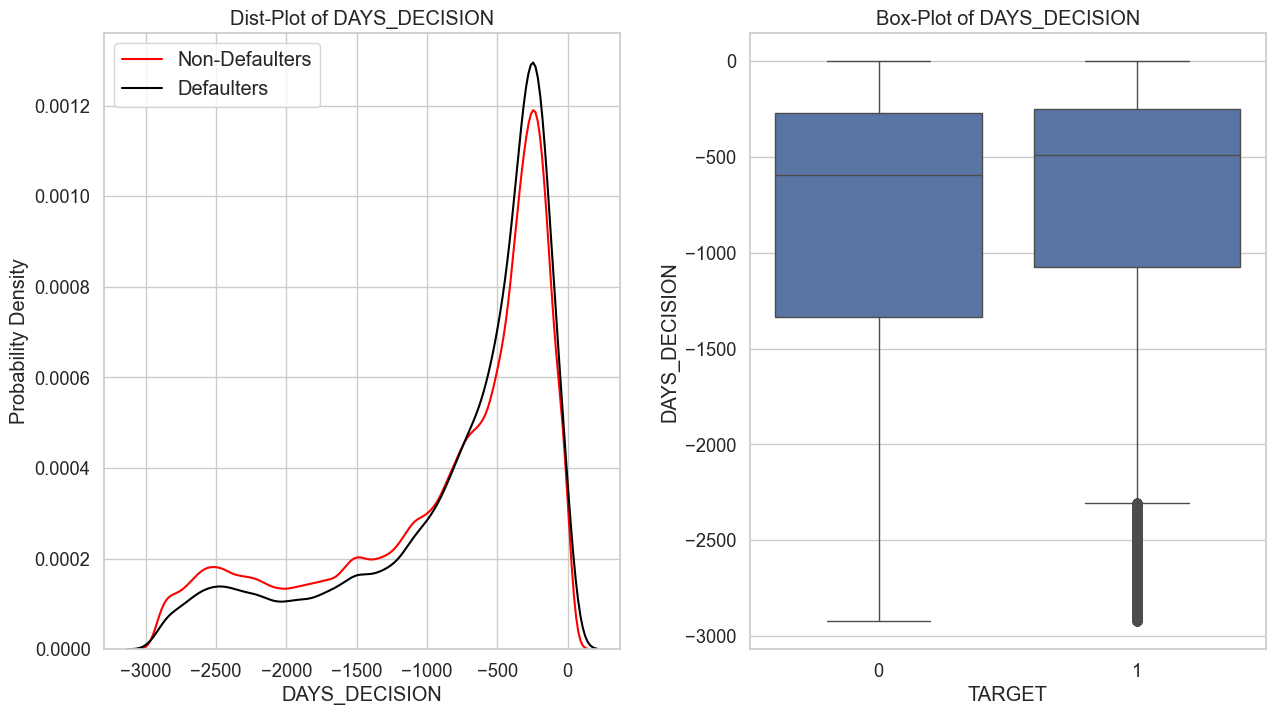

In [65]:
plot_continuous_variables(prev_merged, 'DAYS_DECISION', plots = ['distplot', 'box'], figsize = (15,8))

Observations et conclusions
Le graphique ci-dessus montre que pour les mauvais payeurs, le nombre de jours écoulés depuis la décision est légèrement inférieur à celui des non mauvais payeurs. Cela signifie que les défaillants ont généralement fait l'objet d'une décision plus récente que les non-défaillants.

_____________________________________________________________
JOURS_PREMIER_TIRAGE

Cette colonne indique le nombre de jours écoulés depuis la demande actuelle lorsque le premier versement de la demande précédente a été effectué.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DRAWING is -2922.0
The 1th percentile value of DAYS_FIRST_DRAWING is -2451.0
The 2th percentile value of DAYS_FIRST_DRAWING is -1179.0
The 3th percentile value of DAYS_FIRST_DRAWING is -674.0
The 4th percentile value of DAYS_FIRST_DRAWING is -406.0
The 5th percentile value of DAYS_FIRST_DRAWING is -262.0
The 6th percentile value of DAYS_FIRST_DRAWING is -156.0
The 7th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 8th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 9th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 10th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 20th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 40th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 60th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 80th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 100th percentile

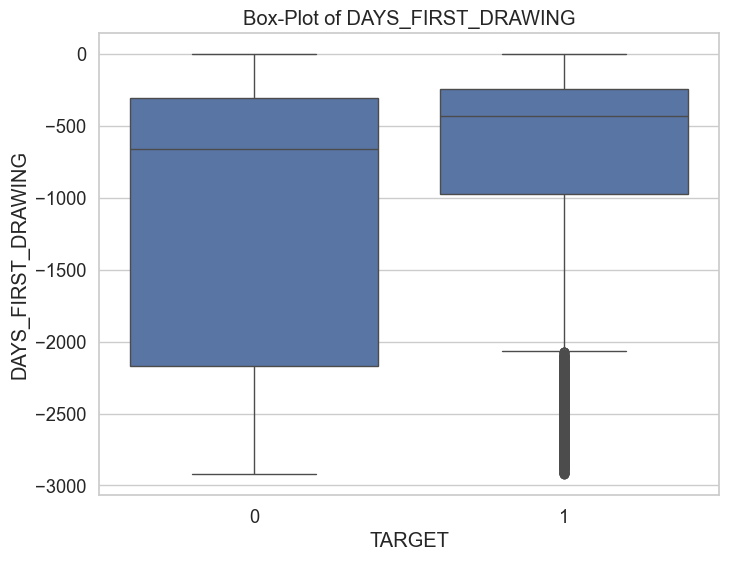

----------------------------------------------------------------------------------------------------


In [66]:
print_percentiles(prev_merged, 'DAYS_FIRST_DRAWING', percentiles = list(range(0,11)) + list(range(20,101,20)))
plot_continuous_variables(prev_merged, 'DAYS_FIRST_DRAWING', plots = ['box'], figsize = (8,6), scale_limits = [-3000,0])
print('-'*100)

Observations et conclusions :
En examinant les valeurs des percentiles de DAYS_FIRST_DRAWING, il semble que la plupart des valeurs soient erronées, à commencer par les valeurs du 7e percentile. Ces valeurs erronées devront être supprimées.
Si nous essayons d'analyser la distribution de cette colonne en supprimant les points erronés, nous constatons que la plupart des mauvais payeurs ont effectué leur premier prélèvement sur un crédit antérieur plus récemment que les non mauvais payeurs. La valeur du 75e percentile pour les mauvais payeurs est également nettement inférieure à celle des non mauvais payeurs.

______________________________________________________________
DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, et DAYS_TERMINATION

Ces colonnes indiquent également le nombre de jours écoulés depuis l'application en cours, au cours desquels certaines activités ont eu lieu.

In [67]:
print('-'*100)
print("Percentile Values for DAYS_FIRST_DUE")
print_percentiles(prev_merged, 'DAYS_FIRST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE_1ST_VERSION")
print_percentiles(prev_merged, 'DAYS_LAST_DUE_1ST_VERSION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE")
print_percentiles(prev_merged, 'DAYS_LAST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_TERMINATION")
print_percentiles(prev_merged, 'DAYS_TERMINATION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])

----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_FIRST_DUE
----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DUE is -2892.0
The 2th percentile value of DAYS_FIRST_DUE is -2759.0
The 4th percentile value of DAYS_FIRST_DUE is -2648.0
The 6th percentile value of DAYS_FIRST_DUE is -2555.0
The 8th percentile value of DAYS_FIRST_DUE is -2471.0
The 10th percentile value of DAYS_FIRST_DUE is -2388.0
The 20th percentile value of DAYS_FIRST_DUE is -1882.0
The 40th percentile value of DAYS_FIRST_DUE is -1070.0
The 60th percentile value of DAYS_FIRST_DUE is -647.0
The 80th percentile value of DAYS_FIRST_DUE is -329.0
The 100th percentile value of DAYS_FIRST_DUE is 365243.0
----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_LAST_DUE_1ST_VERSION
------------

Observations et conclusions
À partir de toutes les valeurs de percentile ci-dessus, nous nous rendons compte que toutes les colonnes des Jours ont ces valeurs erronées à un moment ou à un autre. Ces valeurs doivent donc être remplacées afin que notre modèle n'en soit pas affecté.

________________________________________________________________
installments_payments.csv
Description
Ce tableau énumère l’historique de remboursement de chacun des prêts que le demandeur a contractés auprès de Home Credit Group. Le tableau contient des caractéristiques telles que le montant des versements, le montant que le client a payé pour chaque versement, etc.

In [68]:
print(f'The shape of installments_payments.csv is: {installments_payments.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in installments_payments.csv are: {len(installments_payments.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in installments_payments.csv are: {len(installments_payments.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in installments_payments: {installments_payments.shape[0] - installments_payments.duplicated().shape[0]}')
print('-'*100)
display(installments_payments.head(5))

The shape of installments_payments.csv is: (13605401, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in installments_payments.csv are: 997752
Number of unique SK_ID_CURR in installments_payments.csv are: 339587
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: 291643
Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: 47944
----------------------------------------------------------------------------------------------------
Number of duplicate values in installments_payments: 0
----------------------------------------------------------------------------------------------------


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

Il y a environ 13,6 millions de points de données dans le tableau installments_payments.csv. Chaque ligne représente l’historique de chaque versement lié à un prêt particulier que le client avait précédemment auprès de Home Credit Group.
Il y a 997 000 prêts antérieurs uniques dans le installments_payments. Ceux-ci appartiennent à 339k SK_ID_CURR uniques, qui sont les pièces d’identité des demandeurs de prêt en cours.
Sur ces 339 0 SK_ID_CURR 3 03, 291 000 appartiennent au jeu de données d’apprentissage et 47,9 000 au jeu de données de test. Cela implique que près de 307 000 SK_ID_CURR uniques en application_train, 291 000 avaient déjà contracté une forme de prêt auprès du crédit immobilier. De même, pour 48,7 000 d’entre eux dans l’ensemble de données de test, 47,9 000 avaient déjà contracté un prêt avec Home Credit.
Le tableau comporte 8 caractéristiques uniques, dont 6 décrivent les statistiques de chaque versement pour le prêt précédent.


In [69]:

print('-'*100)
print("Columns with NaN values and their percentages:")
installments_payments_nan = nan_df_create(installments_payments)
display(installments_payments_nan[installments_payments_nan.percent != 0])
print('-'*100)
del installments_payments_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


column   percent
5  DAYS_ENTRY_PAYMENT  0.021352
7         AMT_PAYMENT  0.021352

----------------------------------------------------------------------------------------------------


Il n’y a que 2 colonnes qui contiennent les valeurs NaN des 8 colonnes de installments_payments.
Ces colonnes contiennent également une proportion très minime de valeurs de NaN, c’est-à-dire seulement 0,02 %, ce qui n’est pas très préoccupant.

In [70]:
print("-"*100)
print("Merging TARGET with installments_payments Table")
installments_merged = application_train.iloc[:,:2].merge(installments_payments, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with installments_payments Table
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


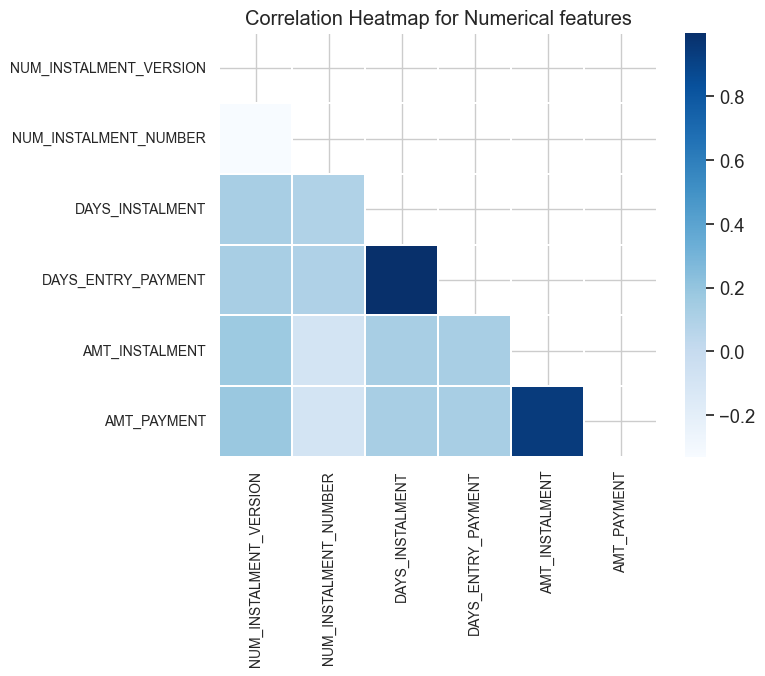

----------------------------------------------------------------------------------------------------


In [73]:
corr_mat = correlation_matrix(installments_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (8,7))
corr_mat.plot_correlation_matrix()

In [74]:

#Seeing the top columns with highest phik-correlation with the target variable in installments_payments table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_VERSION']
interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_NUMBER']
interval columns not set, guessing: ['TARGET', 'DAYS_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_ENTRY_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


Column Name  Phik-Correlation
3      DAYS_ENTRY_PAYMENT          0.047231
2         DAYS_INSTALMENT          0.046815
1   NUM_INSTALMENT_NUMBER          0.022993
4          AMT_INSTALMENT          0.004125
5             AMT_PAYMENT          0.003084
0  NUM_INSTALMENT_VERSION          0.002198

----------------------------------------------------------------------------------------------------


La carte thermique ci-dessus montre la corrélation entre chaque entité de installments_payments tableau avec le reste des entités.
À partir de la carte thermique de la matrice de corrélation, nous voyons quelques caractéristiques fortement corrélées. Il s’agit de :
AMT_INSTALMENT et AMT_PAYMENT
DAYS_INSTALMENT et DAYS_ENTRY_PAYMENT
Ces deux ensembles de caractéristiques corrélées sont compréhensibles, car il s’agit en fait des caractéristiques indiquant quand le versement devait être payé par rapport au moment où il a été payé, ainsi que le montant dû par rapport au montant qui a été payé.
Ces caractéristiques seront utiles pour créer de nouveaux ensembles d’entités complètement non corrélées.
La corrélation des entités avec la cible n’est pas perceptible, ce qui montre l’absence d’une relation linéaire entre la caractéristique et la variable cible.


__________________________________________________________________
Tracé de variables continues
Tout d’abord, nous allons regrouper par le champ « SK_ID_PREV » et agréger avec la moyenne, de sorte que nous obtenions une ligne moyenne pour chacun des prêts précédents que le client avait.

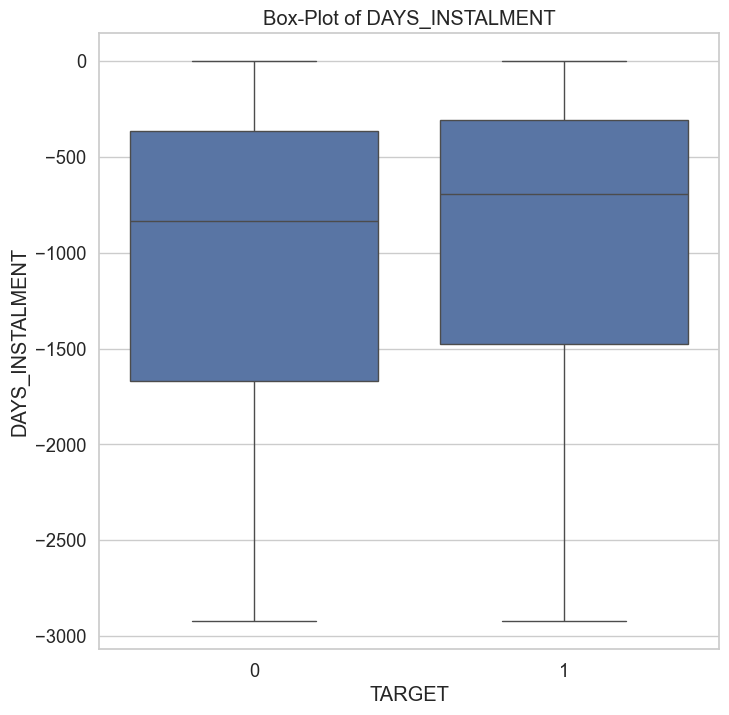

In [75]:
plot_continuous_variables(installments_merged, 'DAYS_INSTALMENT', plots = ['box'], figsize = (8,8))

Distribution de DAYS_ENTRY_PAYMENT continus

Cette colonne répertorie les jours où la mensualité du crédit précédent a été effectivement payée.

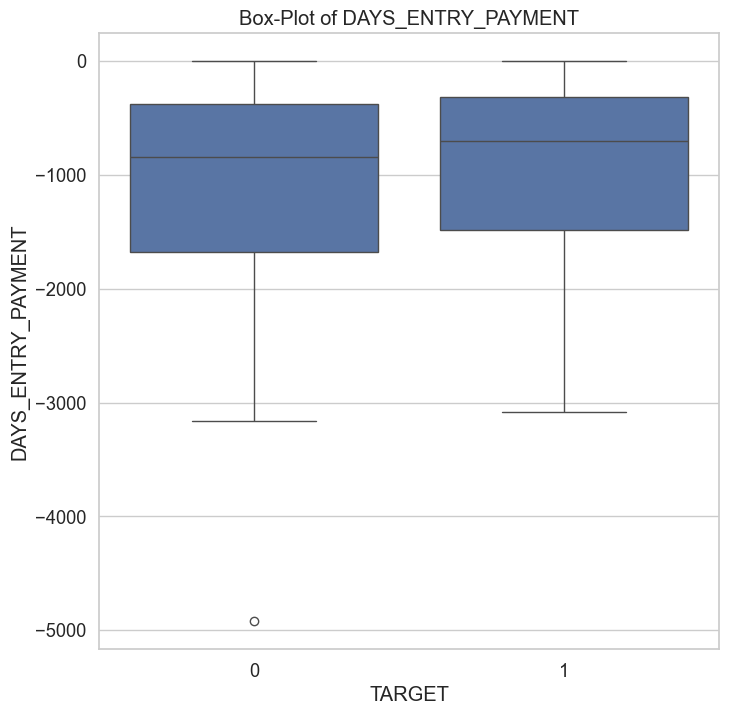

In [76]:
plot_continuous_variables(installments_merged, 'DAYS_ENTRY_PAYMENT', plots = ['box'], figsize = (8,8))
del installments_merged # permet de supprimer en memoir le installemnt merged


Observations and Conclusions
From the above two plots, we can see a similar pattern, where the Defaulters tend to have lesser number of days since their last payment, while Non-Defaulters have more number of days since their last payments. All quantiles of Defaulters have more recent days than those of Non-Defaulters. Thus, Non-Defaulters usually have more gap in their payments from the day of application as compared to Defaulters.

_____________________________________________________________________

POS_CASH_balance.csv
Description
Ce tableau contient les aperçus du solde mensuel des prêts aux points de vente et des prêts en espèces antérieurs que le demandeur a contractés auprès de Home Credit Group. Le tableau contient des colonnes telles que l’état du contrat, le nombre de versements restants, etc.

In [77]:

print(f'The shape of POS_CASH_balance.csv is: {POS_CASH_balance.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in POS_CASH_balance: {POS_CASH_balance.shape[0] - POS_CASH_balance.duplicated().shape[0]}')
print('-'*100)
display(POS_CASH_balance.head())

The shape of POS_CASH_balance.csv is: (10001358, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in POS_CASH_balance.csv are: 936325
Number of unique SK_ID_CURR in POS_CASH_balance.csv are: 337252
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: 289444
Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: 47808
----------------------------------------------------------------------------------------------------
Number of duplicate values in POS_CASH_balance: 0
----------------------------------------------------------------------------------------------------


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

Ce tableau contient environ 10 millions de points de données, où chaque ligne correspond à l’instantané mensuel de l’état du point de vente et du prêt en espèces précédents que le client avait avec Home Credit Group. Il se compose de 8 colonnes, dont deux sont SK_ID_CURR et SK_ID_PREV.
Il y a 936 000 identifiants de prêts antérieurs uniques dans le tableau, ce qui correspond à 337 000 demandeurs actuels uniques (SK_ID_CURR).
Sur ces 337k SK_ID_CURR, 289k appartiennent à l’ensemble d’entraînement et 47,8k à l’ensemble de test.

In [78]:
print('-'*100)
print("Columns with NaN values and their percentages:")
POS_CASH_nan = nan_df_create(POS_CASH_balance)
display(POS_CASH_nan[POS_CASH_nan.percent != 0])
print('-'*100)
del POS_CASH_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


column   percent
4  CNT_INSTALMENT_FUTURE  0.260835
3         CNT_INSTALMENT  0.260675

----------------------------------------------------------------------------------------------------


Il n’y a que 2 colonnes qui contiennent les valeurs NaN des 8 colonnes de POS_CASH_balance. Ces colonnes sont le nombre de versements restants et la durée du prêt.
Ces colonnes contiennent également une proportion très minime de valeurs de NaN, c’est-à-dire seulement 0,26 %, ce qui n’est pas non plus très préoccupant.

In [79]:
print("-"*100)
print("Merging TARGET with POS_CASH_balance Table")
pos_cash_merged = application_train.iloc[:,:2].merge(POS_CASH_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with POS_CASH_balance Table
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


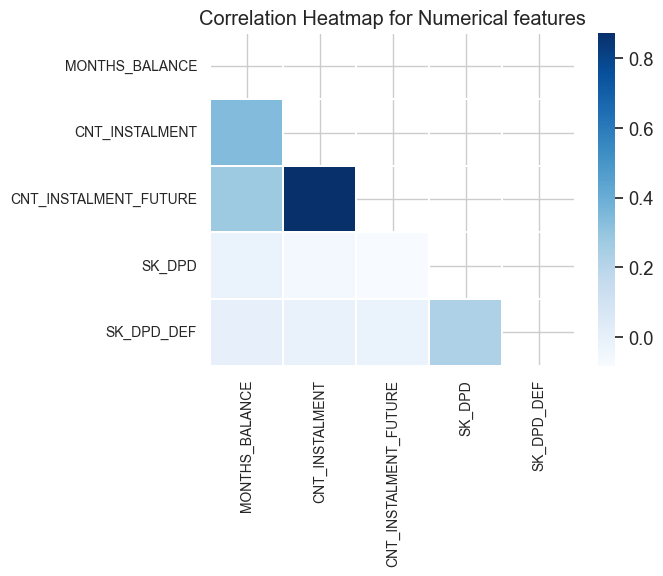

----------------------------------------------------------------------------------------------------


In [82]:
colonnes_numeriques = pos_cash_merged.select_dtypes(exclude=['object'])
corr_mat = correlation_matrix(colonnes_numeriques, ['SK_ID_CURR','SK_ID_PREV'], figsize = (7,6))
corr_mat.plot_correlation_matrix()

In [83]:

#Seeing the top columns with highest phik-correlation with the target variable in POS_CASH_balance table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT_FUTURE']
interval columns not set, guessing: ['TARGET', 'SK_DPD']
interval columns not set, guessing: ['TARGET', 'SK_DPD_DEF']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


Column Name  Phik-Correlation
2  CNT_INSTALMENT_FUTURE          0.033194
1         CNT_INSTALMENT          0.030947
0         MONTHS_BALANCE          0.027383
3                 SK_DPD          0.012773
4             SK_DPD_DEF          0.010539

----------------------------------------------------------------------------------------------------


La carte thermique ci-dessus montre la corrélation entre les fétuces
À partir de la carte thermique de la matrice de corrélation, nous avons un ensemble de caractéristiques modérément corrélées, qui sont : CNT_INSTALMENT et CNT_INSTALMENT_FUTURE.
La corrélation des caractéristiques avec la cible est très faible, ce qui montre l’absence d’une relation linéaire entre la caractéristique et la variable cible.

____________________________________________________________________

Tracé de variables continues
Tout d’abord, nous allons regrouper par le champ « SK_ID_PREV » et agréger avec la moyenne, de sorte que nous obtenions une ligne moyenne pour chacun des prêts précédents que le client avait.

In [85]:
pos_cash_merged_mean = colonnes_numeriques.groupby('SK_ID_PREV').mean()

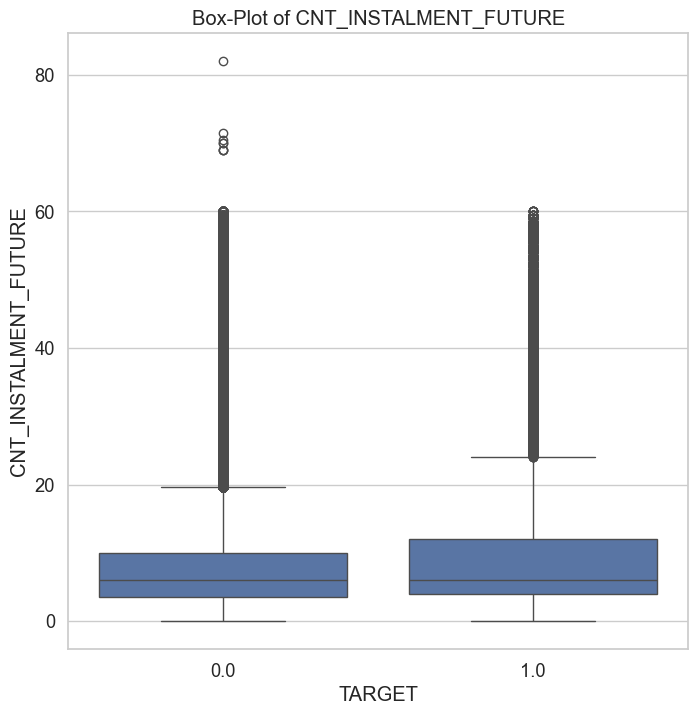

In [87]:

plot_continuous_variables(pos_cash_merged_mean, 'CNT_INSTALMENT_FUTURE', plots = ['box'], figsize = (8,8))
del pos_cash_merged_mean

En regardant la boîte à moustaches ci-dessus pour CNT_INSTALMENT_FUTURE, nous voyons que les valeurs de percentile >50% pour les défaillants sont généralement plus élevées que celles des non-défaillants. Même la limite supérieure pour les défaillants est plus élevée que celle des non-défaillants. Cela suggère que les mauvais payeurs ont tendance à avoir plus de versements restants sur leurs crédits précédents que les non-défaillants.

_____________________________________________________________________
credit_card_balance.csv
Description
Ce tableau présente les données mensuelles relatives à une ou plusieurs cartes de crédit que le demandeur détenait auprès du groupe de crédit résidentiel. Le tableau contient des champs tels que le solde, la limite de crédit, le montant des tirages, etc. pour chaque mois de la carte de crédit.

In [88]:

print(f'The shape of credit_card_balance.csv is: {cc_balance.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in credit_card_balance.csv are: {len(cc_balance.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in credit_card_balance.csv are: {len(cc_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(cc_balance.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(cc_balance.SK_ID_CURR.unique())))}')
print('-'*100)

print(f'Number of duplicate values in credit_card_balance: {cc_balance.shape[0] - cc_balance.duplicated().shape[0]}')
print('-'*100)
display(cc_balance.head(5))

The shape of credit_card_balance.csv is: (3840312, 23)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in credit_card_balance.csv are: 104307
Number of unique SK_ID_CURR in credit_card_balance.csv are: 103558
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: 86905
Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: 16653
----------------------------------------------------------------------------------------------------
Number of duplicate values in credit_card_balance: 0
----------------------------------------------------------------------------------------------------


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

Il y a environ 3,84 millions de lignes dans le tableau credit_card_balance.csv, chacune d’entre elles correspondant à l’état mensuel de la carte de crédit que le demandeur avait auprès de Home Credit Group. Ce tableau contient 23 caractéristiques qui contiennent les statistiques sur l’état de la carte de crédit de chaque mois, telles que le montant du solde, le montant des tirages, le nombre de tirages, le statut, etc.
Il y a 104.3k cartes de crédit uniques dont les détails sont dans ce tableau.
Sur ces 104,3 000, il y a 103,5 000 SK_ID_CURR uniques. Cela signifie que la plupart des demandeurs n’avaient qu’une seule carte de crédit sur eux, et que seuls quelques-uns d’entre eux en avaient plus d’une. Ces SK_ID_CURR sont les pièces d’identité des demandeurs qui ont actuellement fait une demande de prêt.
Sur les 103 000 SK_ID_CURR uniques, 86,9 000 de ces candidats appartiennent à l’ensemble d’apprentissage et 16,6 000 à l’ensemble d’applications de test.
Sur les 307 000 demandeurs figurant dans application_train tableau, seuls 86,9 000 d’entre eux avaient déjà une carte de crédit auprès de Home Credit Group.

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 9 columns


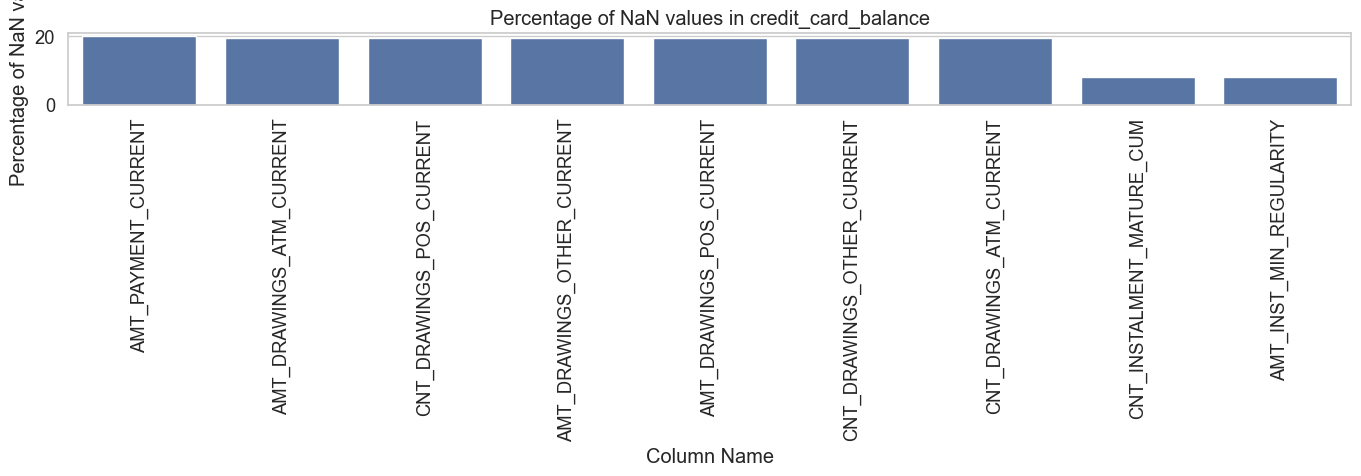

----------------------------------------------------------------------------------------------------


In [89]:
cc_balance_nan = nan_df_create(cc_balance)
print('-'*100)
plot_nan_percent(cc_balance_nan, 'credit_card_balance', tight_layout = False, rotation = 90, figsize = (14,5))
print('-'*100)
del cc_balance_nan

Sur les 23 caractéristiques, 9 d’entre elles contiennent des valeurs NaN.
Si nous regardons les pourcentages de valeurs NaN, ils sont considérablement inférieurs au reste des tableaux que nous avons vus jusqu’à présent.
7 de ces caractéristiques ont des valeurs de NaN proches de 20 %. Ces caractéristiques sont principalement liées aux quantités de dessins et au nombre de dessins. Deux autres fonctionnalités sont liées aux statistiques sur les versements.

In [90]:

print("-"*100)
print("Merging TARGET with credit_card_balance Table")
cc_balance_merged = application_train.iloc[:,:2].merge(cc_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with credit_card_balance Table
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


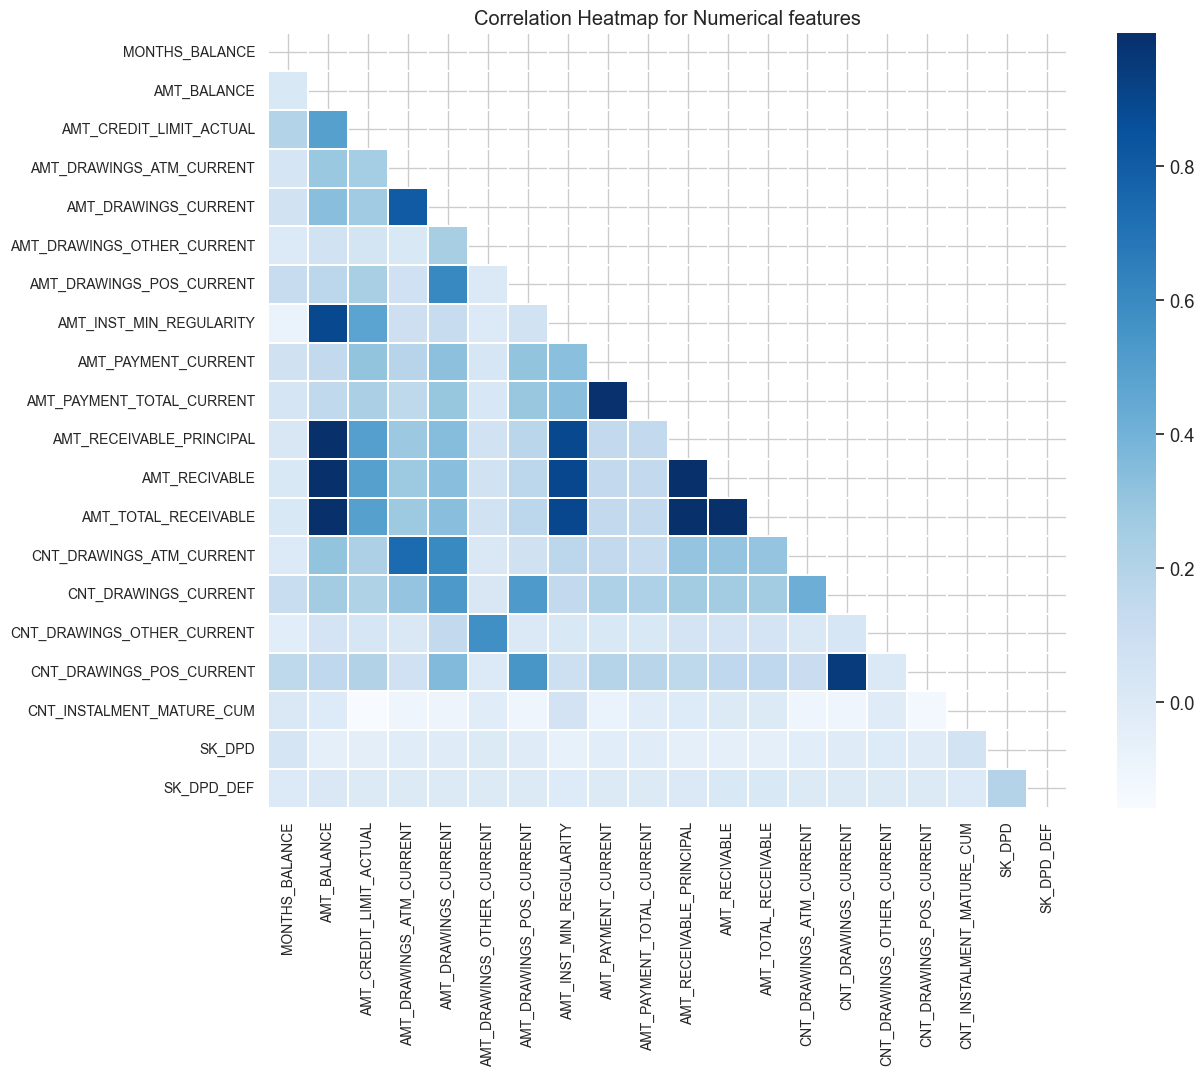

----------------------------------------------------------------------------------------------------


In [92]:
colonnes_numeriques = cc_balance_merged.select_dtypes(exclude=['object'])
corr_mat = correlation_matrix(colonnes_numeriques, ['SK_ID_CURR','SK_ID_PREV'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

In [93]:

#Seeing the top columns with highest phik-correlation with the target variable in credit_card_balance table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-" * 100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURREN

Column Name  Phik-Correlation
1                 AMT_BALANCE          0.059838
11              AMT_RECIVABLE          0.059311
12       AMT_TOTAL_RECEIVABLE          0.059288
10   AMT_RECEIVABLE_PRINCIPAL          0.058895
0              MONTHS_BALANCE          0.050330
7     AMT_INST_MIN_REGULARITY          0.042174
17  CNT_INSTALMENT_MATURE_CUM          0.037519
13   CNT_DRAWINGS_ATM_CURRENT          0.030052
2     AMT_CREDIT_LIMIT_ACTUAL          0.028752
14       CNT_DRAWINGS_CURRENT          0.027841

----------------------------------------------------------------------------------------------------


La carte thermique ci-dessus montre visuellement la corrélation entre les entités de credit_card_balance tableau.
À partir de la carte thermique de la matrice de corrélation, nous voyons quelques couples de caractéristiques fortement corrélées. Il s’agit de :
AMT_RECEIVABLE_PRINCIPLE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE et AMT_BALANCE
On observe également une forte corrélation entre ces 3 colonnes AMT_RECEIVABLE
AMT_PAYMENT_TOTAL_CURRENT et AMT_PAYMENT_CURRENT
Les ensembles de 2e et 3e caractéristiques corrélatives sont compréhensibles car ils racontent plus ou moins la même histoire.
La corrélation des entités avec la cible n’est pas perceptible, ce qui montre l’absence d’une relation linéaire entre la caractéristique et la variable cible.

_____________________________________________________________________


Tracé de variables continues
Tout d’abord, nous allons regrouper par le champ « SK_ID_PREV » et agréger avec la moyenne, de sorte que nous obtenions une ligne moyenne pour chacun des prêts précédents que le client avait.

In [94]:
cc_balance_merged_mean = colonnes_numeriques.groupby('SK_ID_PREV').mean()

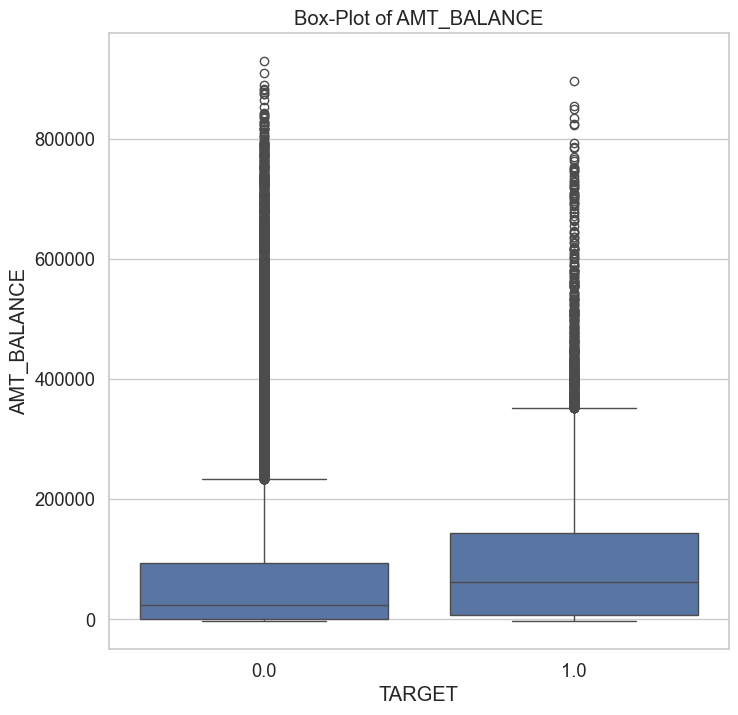

In [95]:
plot_continuous_variables(cc_balance_merged_mean, 'AMT_BALANCE', plots = ['box'], figsize = (8,8))

D’après le graphique ci-dessus, on peut voir que les défaillants ont une valeur de AMT_BALANCE plus élevée que les non-défaillants. Ils montrent des valeurs plus élevées de tous les quantiles et même des moustaches. Cela pourrait signifier que le montant du crédit pour les mauvais payeurs pourrait également être relativement plus élevé que pour les non-défaillants.

Nous constatons que les défaillants semblaient également avoir un versement minimum plus élevé chaque mois par rapport aux non-défaillants. Cela parle généralement des dépenses et des emprunts des gens. Les mauvais payeurs ont des habitudes de dépenses et d’emprunt plus élevées que les non-défaillants.

_____________________________________________________________________Distribution de AMT_TOTAL_RECEIVABLE continus

Cette colonne décrit la moyenne du montant total à recevoir sur le crédit précédent.


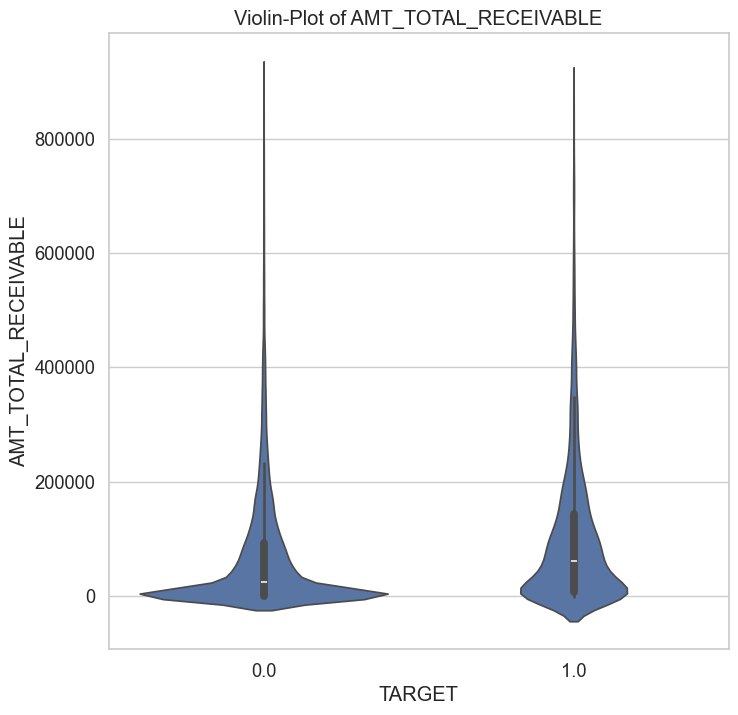

In [96]:
plot_continuous_variables(cc_balance_merged_mean, 'AMT_TOTAL_RECEIVABLE', plots = ['violin'], figsize = (8,8))

En regardant la boîte à moustaches de AMT_TOTAL_RECEIVABLE, nous constatons un comportement similaire à celui observé avec d’autres montants, à savoir que les mauvais payeurs avaient généralement un montant à recevoir plus élevé sur leur crédit précédent, ce qui peut impliquer les montants plus élevés de crédits qu’ils ont pu prendre. Le PDF montre également un pic très élevé à des montants inférieurs pour les non-défaillants par rapport aux défaillants.

_____________________________________________________________________
Distribution de CNT_INSTALMENT_MATURE_CUM continus

La colonne décrit le nombre moyen de versements payés sur les crédits précédents.


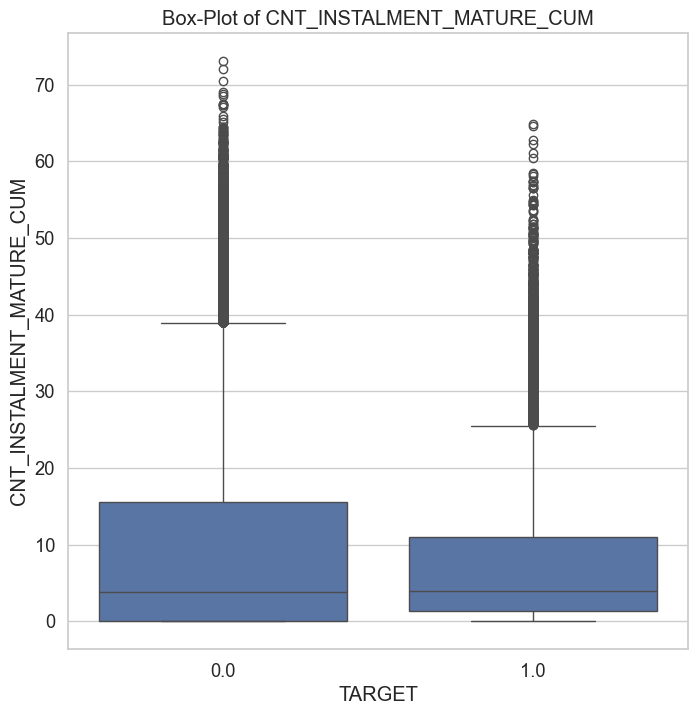

In [97]:
plot_continuous_variables(cc_balance_merged_mean, 'CNT_INSTALMENT_MATURE_CUM', plots = ['box'], figsize = (8,8))

D’après le graphique ci-dessus, nous voyons un comportement très intéressant. Ce graphique montre que les non-défaillants avaient généralement une fourchette de valeurs plus élevée pour le nombre de versements payés par rapport aux mauvais payeurs. Cela pourrait montrer le comportement de défaut, où les défaillants paieraient généralement moins de versements sur leur crédit précédent.

# conclusion de l'eda

1. Tout d’abord, l’ensemble de l’ensemble de données devra être fusionné avec un moyen ingénieux pour que les données fusionnées aient un sens.

2. Certaines catégories sont très discriminatoires entre les défaillants et les non-défaillants, ce qui pourrait être important aux fins de la classification.

3. Il y a peu de variables numériques continues qui contiennent des points erronés, nous devrions gérer ces points.

4. Nous avons également remarqué certaines caractéristiques corrélées, qui ne feraient qu’augmenter la dimensionnalité des données et n’ajouteraient pas beaucoup de valeur. Nous voudrions supprimer de telles fonctionnalités.

5. Dans l’ensemble, l’ensemble de données est déséquilibré, et nous aurions besoin de trouver des techniques pour gérer un tel déséquilibre.

6. Pour la prédiction du risque de défaut, les défaillants ont généralement tendance à avoir un comportement qui n’est pas normal, et par conséquent, nous ne pouvons pas supprimer les valeurs aberrantes ou les points éloignés, car ils peuvent suggérer une tendance importante à la défaillance.

7. Avec toutes ces informations, nous allons passer à la tâche de Data Clearning et d’ingénierie des fonctionnalités.